<a href="https://colab.research.google.com/github/hisunnytang/HaloEGNN/blob/main/notebooks/HaloEGNN_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torchdiffeq
!pip install gdown
!git clone https://github.com/hisunnytang/HaloEGNN.git

In [ ]:
import numpy as np
import torch
import glob
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
import pickle
from HaloEGNN.HaloEGNNFlows.EGNNFlows.models import get_model
from HaloEGNN.HaloEGNNFlows.EGNNFlows.datasets import \
(
 ProgenitorDataset,
 find_closest_redshift_slice, 
 prepare_input_data
 )

from HaloEGNN.HaloEGNNFlows.EGNNFlows.viz.utils import compute_metric_features
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flows.utils import assert_correctly_masked
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flow_forward import  flow_forward
from HaloEGNN.HaloEGNNFlows.train import prepare_filelist_and_transformer
import re
from collections import OrderedDict

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!cp /content/drive/MyDrive/HaloEGNN_sample_data/newdata.zip .


In [ ]:
%%capture 
!unzip newdata.zip

In [ ]:
!cp /content/drive/MyDrive/HaloEGNN_sample_data/egnn_11_val=66.989.pt .

In [ ]:
# The "scalar" feature bounded to the progenitors
feature_columns = ["SubhaloMass", "SubhaloMergeRedshift"]
# The "positional" feature bounded to the progenitors
position_columns = ["SubhaloPos_0", "SubhaloPos_1", "SubhaloPos_2"]

# initialize the list condtional columns at redshift 0
condition_columns = [
    "SubhaloBHMass",
    "SubhaloBHMdot",
    "SubhaloGasMetallicity",
    "SubhaloStarMetallicity",
    "SubhaloMass",
    "SubhaloSFR",
    "SubhaloVmax",
    "SubhaloVelDisp",
]

n_dims = len(position_columns)
in_node_nf = len(feature_columns)
context_node_nf = len(condition_columns)

prior, flow = get_model(
    in_node_nf=in_node_nf, 
    dynamics_in_node_nf=1, 
    context_node_nf=context_node_nf, 
    n_dims=3, 
    device='cuda')

ckpt = torch.load("egnn_11_val=66.989.pt", map_location=device)

state_dict = ckpt['model_state_dict']

model_dict = OrderedDict()
pattern = re.compile('module.')
for k,v in state_dict.items():
    if re.search("module", k):
        model_dict[re.sub(pattern, '', k)] = v
    else:
        model_dict[k] = v
flow.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
filelist     = sorted(glob.glob("TNG300_preprocessed_data/prog_*.npy"))
data_columns = np.load("TNG300_preprocessed_data/subhalo_columns.npy")

valid_files, condition_normalizer = prepare_filelist_and_transformer(
    filelist_npy=None,
    transformer_pkl=None,
    filelist=filelist,
    condition_columns=condition_columns,
    full_columns_names=data_columns,
    max_progenitors=20,
    initial_slice=0,
    final_slice=1,
    batch_size=512,
    num_workers=2,
    transform_type = "power"
)
print(len(filelist), len(valid_files))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


76105 76078


In [ ]:
# Prepare dataloaders
from HaloEGNN.HaloEGNNFlows.train import prepare_dataloaders,val_step
dl_train, dl_val, dl_test = prepare_dataloaders(
    valid_files,
    condition_columns,
    data_columns,
    position_columns=position_columns,
    feature_columns=feature_columns,
    max_progenitors=20,
    initial_slice=0,
    final_slice=1,
    batch_size=256,
    num_workers=0,
    random_seed=42,
    train_test_split=[0.8, 0.1, 0.1],
    shuffle_train=True,
    distributed=False,
)

In [ ]:
from HaloEGNN.HaloEGNNFlows.EGNNFlows.viz.utils import obtain_feature_df
dfcond, dffeat = obtain_feature_df(
    valid_files,
    condition_columns,
    feature_columns=["SubhaloMass","SubhaloMergeRedshift"],
    initial_slice=0,
    final_slice=1,
    max_progenitors=20,
    max_samples=100000,
    distance_norm=300,
    full_columns_names=data_columns,
    feat_max_progenitors=10,
)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


# Now Chopping it up into different Quantile
- and compute feature correlations

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
dfcond_qnorm = pd.DataFrame(
    QuantileTransformer().fit_transform(dfcond),
    columns = dfcond.columns
    )

In [ ]:
from pyparsing.core import Dict
# get the width
from collections import defaultdict

def sample_from_flows_with_context(prior, 
                                   flow, 
                                   node_mask,
                                   context=torch.tensor([[0.]]), 
                                   context_transform= None,
                                   device='cpu'):
  
  # prepare context
  n_samples, n_nodes, n_context = node_mask.shape
  # prepare a node mask, for now we assume its all visible
  node_mask = node_mask.to(device)

  if context_transform is not None:
    context = torch.from_numpy(context_transform(context)).unsqueeze(1)

  context_ = context.to(device)
  context_ = context_.repeat(1,n_nodes,1)*node_mask
  assert_correctly_masked(context_, node_mask)

  edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0)
  edge_mask = edge_mask.repeat(n_samples, 1, 1).view(-1, 1).to(device)

  with torch.no_grad():
    z_x, z_h = prior.sample(n_samples, n_nodes, node_mask)
    z = torch.cat([z_x, z_h], dim=2)
    tmp = flow.reverse(z, node_mask, edge_mask, context_.float())
    x    = tmp[:, :, 0:3].cpu()
    feat = tmp[:, :, 3:].cpu()
  return x, feat

def generate_flow_samples(context, flow, prior, nsamples=5000, max_progenitors=20, device=device):
  assert context.shape[0] == nsamples
  assert context.ndim == 2
  node_mask = torch.ones(len(context), max_progenitors, 1 )

  x_flowsample, feat_flowsample = sample_from_flows_with_context(
      prior, 
      flow, 
      node_mask,
      context=context.unsqueeze(1),
      context_transform= None,
      device=device)

  # the sample should be sorted by mass
  sorted_index = feat_flowsample[:,:,0].argsort(dim=1)
  sorted_feat  = torch.stack(
      [feat_flowsample[i,reversed(sidx),:] for i, sidx in enumerate(sorted_index)]
      )
  sorted_xpos  = torch.stack(
      [x_flowsample[i,reversed(sidx),:] for i, sidx in enumerate(sorted_index)]
  )

  flow_feats, _ = compute_metric_features(sorted_xpos, sorted_feat, max_prog=10 )
  return flow_feats

def select_by_quantiles(dfquantile, dfcondition, dffeatures, quantile_range: Dict):
  qstring_list = [f"{k} > {v[0]} & {k} < {v[1]}" for k, v in quantile_range.items()]
  qstring = "&".join(qstring_list)

  qnorm_selected = dfquantile.query(qstring)
  selected_cond = dfcondition.loc[qnorm_selected.index].copy()
  selected_feat = dffeatures.loc[ qnorm_selected.index].copy()

  context = torch.from_numpy(condition_normalizer.transform(selected_cond.values))

  return selected_cond, selected_feat, context

def transform_featdata(df):
  df =df.copy()
  # first the mass axis has to be log
  mass_c = [c for c in df.columns if c.startswith("SubhaloMass")]
  z_c = [c for c in df.columns if c.startswith("SubhaloMerge")]
  d_c = [c for c in df.columns if c.startswith('d')]

  df[mass_c] = df[mass_c] * 1e10
  # df[z_c] = np.log( 1/ (1+df[z_c]) )
  df[d_c] = df[d_c]**0.5 * 300 
  return df


def transform_flowdata(df):
  df =df.copy()
  # first the mass axis has to be log
  mass_c = [c for c in df.columns if c.startswith("SubhaloMass")]
  z_c = [c for c in df.columns if c.startswith("SubhaloMerge")]
  d_c = [c for c in df.columns if c.startswith('d')]

  df[mass_c] = np.exp(df[mass_c]) * 1e10
  df[z_c] = np.exp(df[z_c])

  df[d_c] = df[d_c]**0.5 * 300 
  # df[d_c] = np.log(df[d_c])
  return df

quantile_range = {
    'SubhaloMass': [0.8,0.9],
    # 'SubhaloSFR':  [0.5, 0.6]
    }

select_cond, select_feat, select_context = select_by_quantiles(dfcond_qnorm, dfcond, dffeat,quantile_range)

select_flow_feats = generate_flow_samples(
    select_context, 
    flow, 
    prior, 
    nsamples=len(select_context)
    )

In [ ]:
# select_feat = transform_featdata(select_feat)
# select_feat['label'] = 'Truth'
# select_feat['size'] = 500.0

# df_flowfeat = pd.DataFrame(select_flow_feats, columns=dffeat.columns)
# df_flowfeat = transform_flowdata(df_flowfeat)
# df_flowfeat['label'] = 'flow'
# df_flowfeat['size'] = 1

# # df_flow_select = pd.concat([df_flowfeat, select_feat]).reset_index(drop=True)

In [ ]:
def normalize_flowdata(df):
  df =df.copy()
  # first the mass axis has to be log
  mass_c = [c for c in df.columns if c.startswith("SubhaloMass")]
  z_c = [c for c in df.columns if c.startswith("SubhaloMerge")]
  d_c = [c for c in df.columns if c.startswith('d')]

  df[z_c] = np.exp(df[z_c])
  df[d_c] = np.log(df[d_c])
  return df

def norm_data(df):
  df =df.copy()
  # first the mass axis has to be log
  mass_c = [c for c in df.columns if c.startswith("SubhaloMass")]
  z_c = [c for c in df.columns if c.startswith("SubhaloMerge")]
  d_c = [c for c in df.columns if c.startswith('d')]

  df[mass_c] = np.log(df[mass_c])
  df[d_c]    = np.log(df[d_c]) 
  # df[d_c] = np.log(df[d_c])
  return df

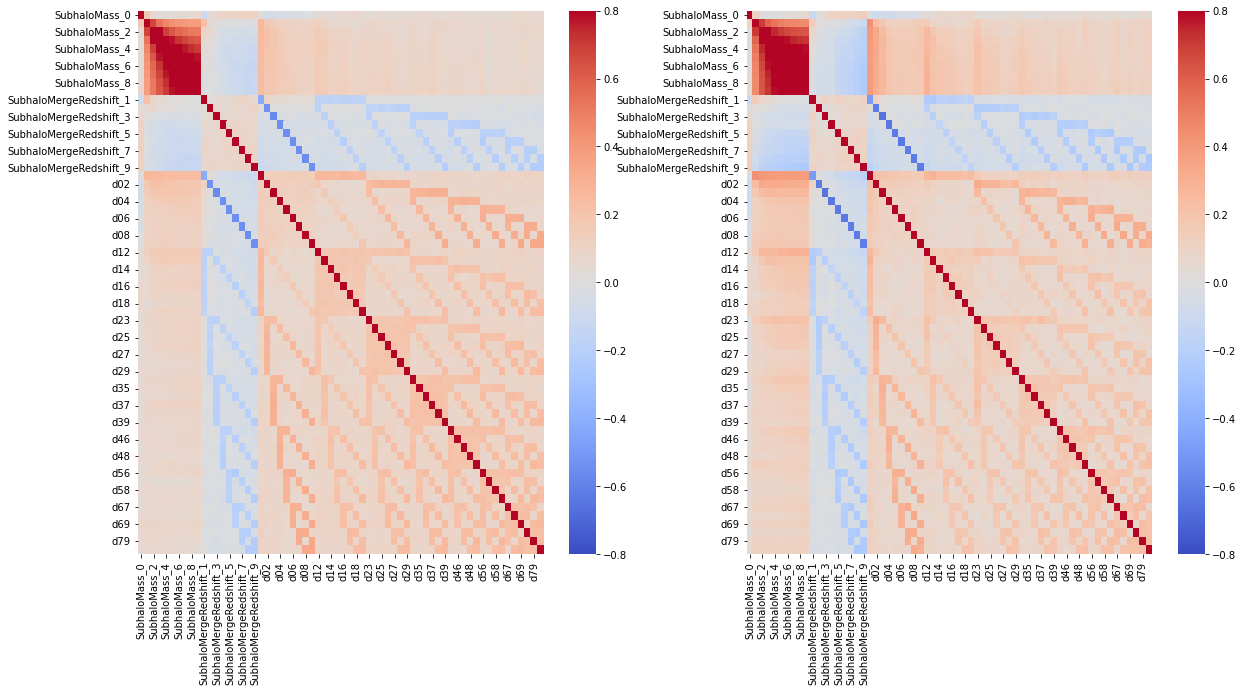

In [ ]:
import matplotlib.pyplot as plt
df_flowfeat = pd.DataFrame(select_flow_feats, columns=dffeat.columns)
df_flowfeat = normalize_flowdata(df_flowfeat)

cols = [c for c in dffeat if c != 'SubhaloMergeRedshift_0']

df_flowfeat = df_flowfeat[cols]

f,axes = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(df_flowfeat.corr(),ax=axes[0],vmin=-0.8, vmax=0.8,cmap='coolwarm')


df_conditioned = norm_data(select_feat[select_feat['SubhaloMass_9'] != 0 ])[cols]
df_sample      = norm_data(select_feat[select_feat['SubhaloMass_9'] != 0 ])[cols]

sns.heatmap(df_conditioned.corr(),ax=axes[1],vmin=-0.8, vmax=0.8,cmap='coolwarm')

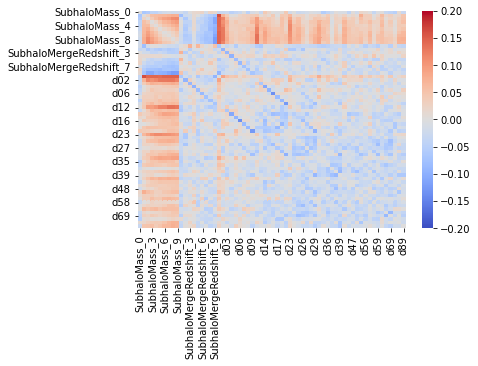

In [ ]:
sns.heatmap(df_conditioned.corr() - df_flowfeat.corr(),vmin=-0.2, vmax=0.2,cmap='coolwarm')

In [ ]:
df_sample      = norm_data(dffeat[dffeat['SubhaloMass_9'] != 0 ])[cols].sample(len(df_flowfeat))

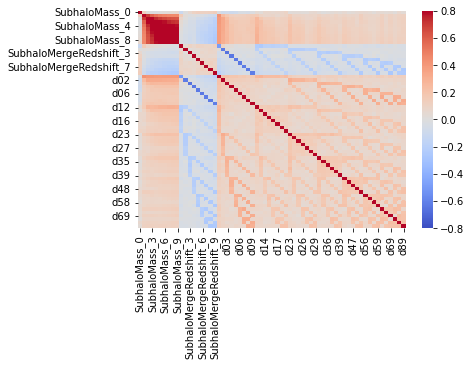

In [ ]:
sns.heatmap(df_sample.corr(),vmin=-0.8, vmax=0.8,cmap='coolwarm')

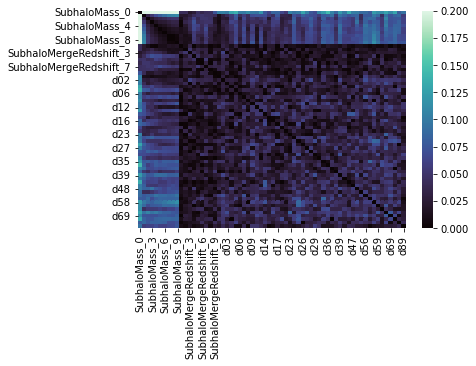

In [ ]:
sns.heatmap(np.abs(df_conditioned.corr() - df_sample.corr()),vmin=0.0, vmax=0.2,cmap='mako')

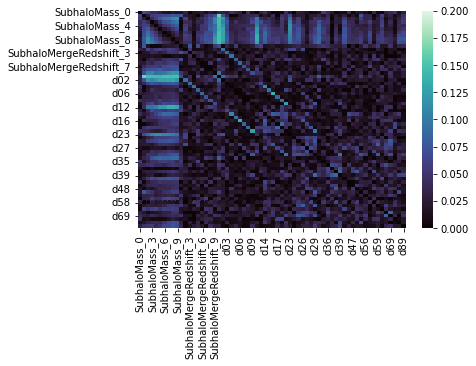

In [ ]:
sns.heatmap(np.abs(df_conditioned.corr() - df_flowfeat.corr()),vmin=0.0, vmax=0.2,cmap='mako')

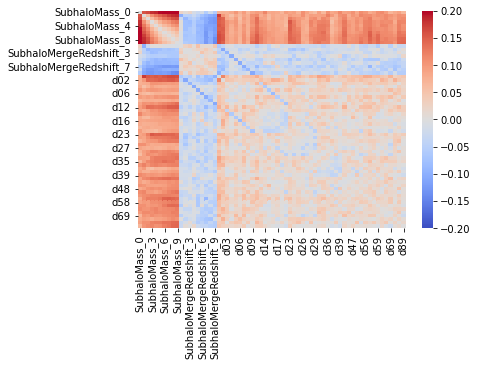

In [ ]:
sns.heatmap(df_sample.corr() - df_flowfeat.corr(),vmin=-0.2, vmax=0.2,cmap='coolwarm')

In [ ]:
corr_diff = np.abs(df_conditioned.corr() - df_flowfeat.corr())

corr_diff

SubhaloMass_0  SubhaloMass_1  SubhaloMass_2  SubhaloMass_3  \
SubhaloMass_0       0.000000       0.065799       0.058762       0.039811   
SubhaloMass_1       0.065799       0.000000       0.026074       0.054771   
SubhaloMass_2       0.058762       0.026074       0.000000       0.039987   
SubhaloMass_3       0.039811       0.054771       0.039987       0.000000   
SubhaloMass_4       0.040983       0.060859       0.060108       0.020204   
...                      ...            ...            ...            ...   
d68                 0.030618       0.019711       0.007861       0.015144   
d69                 0.039436       0.031282       0.026294       0.040700   
d78                 0.049000       0.010076       0.014505       0.006023   
d79                 0.011808       0.020298       0.032154       0.038548   
d89                 0.028346       0.047588       0.051550       0.056309   

               SubhaloMass_4  SubhaloMass_5  SubhaloMass_6  SubhaloMass_7  \
SubhaloMass_0       0.040983       0.027358       0.018696       0.013968   
SubhaloMass_1       0.060859       0.064634       0.066904       0.070526   
SubhaloMass_2       0.060108       0.077989       0.092181       0.097583   
SubhaloMass_3       0.020204       0.048218       0.067657       0.074571   
SubhaloMass_4       0.000000       0.026634       0.049913       0.057632   
...                      ...            ...            ...            ...   
d68                 0.017667       0.022084       0.031095       0.031594   
d69                 0.033364       0.025647       0.032186       0.038979   
d78                 0.007269       0.005763       0.008558       0.017342   
d79                 0.040814       0.039354       0.051286       0.064849   
d89                 0.037879       0.049677       0.064485       0.066041   

               SubhaloMass_8  SubhaloMass_9  ...       d56       d57  \
SubhaloMass_0       0.021201       0.017407  ...  0.013627  0.001446   
SubhaloMass_1       0.077578       0.075696  ...  0.034640  0.034586   
SubhaloMass_2       0.111260       0.115173  ...  0.032914  0.036722   
SubhaloMass_3       0.089468       0.098137  ...  0.038116  0.056349   
SubhaloMass_4       0.071734       0.079842  ...  0.025196  0.044280   
...                      ...            ...  ...       ...       ...   
d68                 0.046779       0.048030  ...  0.029220  0.010608   
d69                 0.043303       0.039253  ...  0.053426  0.002795   
d78                 0.027898       0.020140  ...  0.039551  0.015014   
d79                 0.073110       0.070317  ...  0.006660  0.013806   
d89                 0.076205       0.069156  ...  0.006945  0.008668   

                    d58       d59       d67       d68       d69       d78  \
SubhaloMass_0  0.033637  0.003960  0.002619  0.030618  0.039436  0.049000   
SubhaloMass_1  0.001206  0.020126  0.060562  0.019711  0.031282  0.010076   
SubhaloMass_2  0.007722  0.029770  0.049238  0.007861  0.026294  0.014505   
SubhaloMass_3  0.028190  0.026903  0.059015  0.015144  0.040700  0.006023   
SubhaloMass_4  0.018823  0.024334  0.063990  0.017667  0.033364  0.007269   
...                 ...       ...       ...       ...       ...       ...   
d68            0.019138  0.056688  0.040824  0.000000  0.086399  0.020152   
d69            0.012957  0.026660  0.019400  0.086399  0.000000  0.037203   
d78            0.043516  0.046370  0.014605  0.020152  0.037203  0.000000   
d79            0.019786  0.026106  0.013370  0.019268  0.000014  0.008542   
d89            0.010874  0.023645  0.002403  0.036058  0.047575  0.019941   

                    d79       d89  
SubhaloMass_0  0.011808  0.028346  
SubhaloMass_1  0.020298  0.047588  
SubhaloMass_2  0.032154  0.051550  
SubhaloMass_3  0.038548  0.056309  
SubhaloMass_4  0.040814  0.037879  
...                 ...       ...  
d68            0.019268  0.036058  
d69            0.000014  0.047575  
d78            0.008542  0.019941  
d79            

In [ ]:
np.tril_indices(64, k =1)

(array([ 0,  0,  1, ..., 63, 63, 63]), array([ 0,  1,  0, ..., 61, 62, 63]))

In [ ]:
dfcond_qnorm = pd.DataFrame(
    QuantileTransformer().fit_transform(dfcond),
    columns = dfcond.columns
    )

In [ ]:
dfcond_qnorm

SubhaloBHMass  SubhaloBHMdot  SubhaloGasMetallicity  \
0           0.899306       0.483484               0.317417   
1           0.998907       0.127706               0.000000   
2           0.996126       0.058316               0.000000   
3           0.995478       0.046376               0.000000   
4           0.982688       0.029111               0.000000   
...              ...            ...                    ...   
76073       0.427791       0.402486               0.973887   
76074       0.442916       0.115625               0.000000   
76075       0.534983       0.133744               0.245119   
76076       0.607510       0.202544               0.000000   
76077       0.303768       0.598019               0.778829   

       SubhaloStarMetallicity  SubhaloMass  SubhaloSFR  SubhaloVmax  \
0                    0.427398     0.947528    0.616817     0.898596   
1                    0.993527     0.864245    0.000000     0.997497   
2                    0.727042     0.980209    0.000000     0.991808   
3                    0.873853     0.853807    0.000000     0.995817   
4                    0.457882     0.925564    0.000000     0.961278   
...                       ...          ...         ...          ...   
76073                0.354316     0.001181    0.307917     0.078614   
76074                0.357716     0.094033    0.000000     0.360950   
76075                0.318850     0.046233    0.000000     0.287625   
76076                0.772504     0.025260    0.000000     0.443419   
76077                0.226535     0.014792    0.327768     0.160549   

       SubhaloVelDisp  
0            0.935967  
1            0.979137  
2            0.986987  
3            0.983661  
4            0.947631  
...               ...  
76073        0.069478  
76074        0.256161  
76075        0.244936  
76076        0.273884  
76077        0.114225  

[76078 rows x 8 columns]

In [ ]:
select_feat

SubhaloMass_0  SubhaloMass_1  SubhaloMass_2  SubhaloMass_3  \
1         287.750732     128.096680      59.463615      50.791840   
3         267.448853      64.990074      14.257207       9.631057   
7         117.620270      41.549751      27.879375       2.209951   
10         78.637253      22.652493       5.175230       4.802119   
13         78.146713      32.461136      30.958780      13.300141   
...              ...            ...            ...            ...   
65020      49.567089       7.292945       2.140750       1.816498   
65027      35.172882      14.215732       5.425394       3.698558   
65043      34.810341      15.767444      13.550756       3.886309   
65045      80.676376      18.234320       8.595402       0.479468   
72088      38.035816      17.007408       5.852198       1.451723   

       SubhaloMass_4  SubhaloMass_5  SubhaloMass_6  SubhaloMass_7  \
1          44.732899       4.837659       3.100212       2.933107   
3           1.707976       1.348868       0.554969       0.543390   
7           1.609764       1.018778       0.728924       0.361742   
10          4.357977       4.079082       3.474110       1.917760   
13         10.838954       3.700043       3.120734       3.108937   
...              ...            ...            ...            ...   
65020       1.598437       0.899802       0.615470       0.541049   
65027       3.615450       1.533190       0.862511       0.837002   
65043       1.891139       1.772357       1.247922       1.092240   
65045       0.473550       0.350975       0.248352       0.230890   
72088       0.454882       0.422543       0.399404       0.349519   

       SubhaloMass_8  SubhaloMass_9  ...        d56        d57        d58  \
1           2.399458       2.077486  ...   0.257612   9.784940  12.375048   
3           0.508930       0.442160  ...   0.432525   9.869662   0.231428   
7           0.271749       0.266739  ...   2.219326   0.337135   1.869059   
10          1.553500       1.408482  ...   2.142003  22.530743  14.730002   
13          2.857857       2.108052  ...   7.916933   1.842551  17.391862   
...              ...            ...  ...        ...        ...        ...   
65020       0.493681       0.447973  ...   1.869751   0.467343   0.503695   
65027       0.763663       0.606842  ...   0.431602   0.563956   1.348775   
65043       0.969361       0.847574  ...  12.013013   6.622269  16.664198   
65045       0.208562       0.200855  ...   9.138021  11.279989  25.117082   
72088       0.331990       0.310707  ...   3.147823   2.065869   7.178692   

             d59        d67        d68        d69        d78        d79  \
1      36.829444   8.842856  11.392582  32.548930  38.301792  59.748741   
3       3.677526  10.296965   0.677785   6.227113  12.541937   9.295883   
7      25.796457   2.866548   1.240710  18.950455   2.587777  29.996613   
10      2.009330  10.922010   6.599193   0.364578   2.637250  11.743158   
13      6.456526  12.544714   9.664980   8.441926  25.793788  13.640570   
...          ...        ...        ...        ...        ...        ...   
65020   1.179064   3.610748   4.136134   3.400694   0.134034   1.988347   
65027  25.426097   0.512754   1.559818  30.080206   1.281594  25.789942   
65043  22.788869   0.961838   3.930937   8.235281   6.221525  11.158165   
65045   0.548915   0.483697   7.307088   5.285278   9.742537   6.854352   
72088   0.496959   1.029565  14.308650   1.717474  11.703234   1.605390   

             d89  
1      11.588480  
3       3.953482  
7      15.306802  
10      7.163930  
13      4.345020  
...          ...  
65020   1.384488  
65027  33.602000  
65043   1.201389  
65045  19.723580  
72088   6.975968  

[7615 rows x 65 columns]

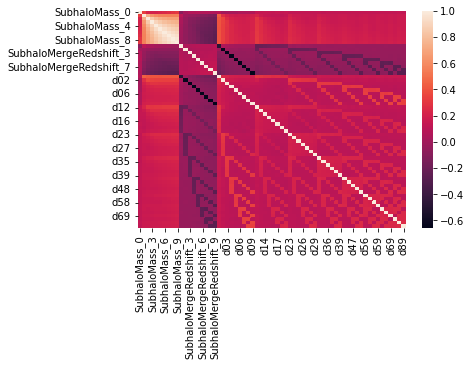

In [ ]:
sns.heatmap(norm_data(dffeat[dffeat['SubhaloMass_9'] != 0 ])[cols].corr())

In [ ]:
df_data = norm_data(dffeat[dffeat['SubhaloMass_9'] != 0 ])[cols]

def bootstrap_corr(df_data, nsamples=1000, ntimes=100):
  corr = []
  for i in range(ntimes):
    corr.append(df_data.sample(nsamples).corr().values)
  corr = np.array(corr)
  return corr.mean(0), corr.std(0)

In [ ]:
mean_corr, std_corr = bootstrap_corr(df_data, nsamples= 1000, ntimes =100)

In [ ]:
import matplotlib.pyplot as plt

{'SubhaloMass': [0.0, 0.1]}


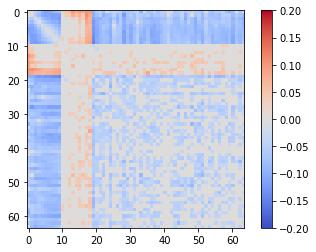

{'SubhaloMass': [0.1, 0.2]}


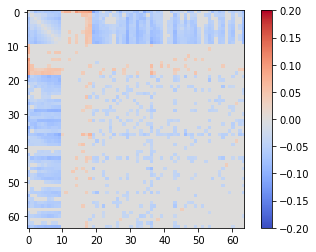

{'SubhaloMass': [0.2, 0.30000000000000004]}


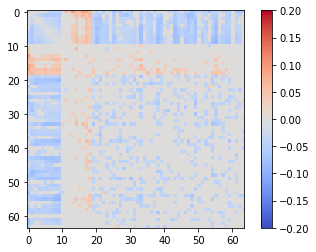

{'SubhaloMass': [0.30000000000000004, 0.4]}


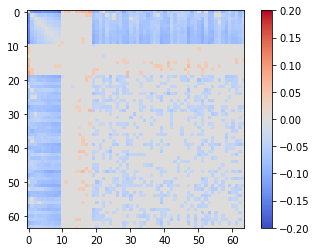

{'SubhaloMass': [0.4, 0.5]}


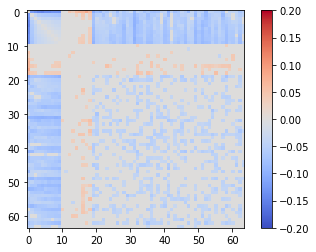

{'SubhaloMass': [0.5, 0.6000000000000001]}


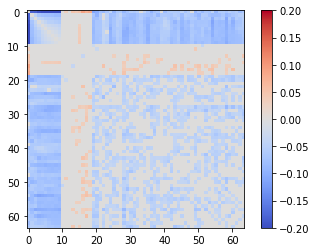

{'SubhaloMass': [0.6000000000000001, 0.7000000000000001]}


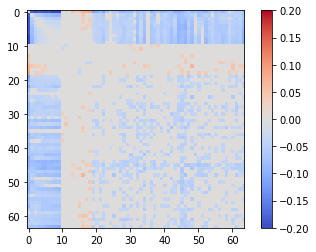

{'SubhaloMass': [0.7000000000000001, 0.8]}


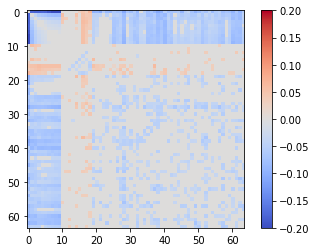

{'SubhaloMass': [0.8, 0.9]}


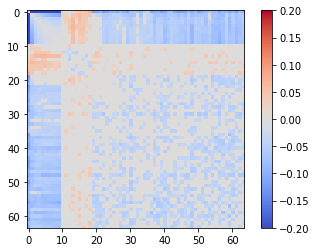

{'SubhaloMass': [0.9, 1.0]}


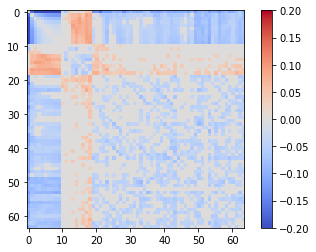

In [ ]:
for i in range(10):
  quantile_range = {
      'SubhaloMass': [i*0.1,(i+1)*0.1],
      }
  print(quantile_range)

  select_cond, select_feat, select_context = select_by_quantiles(dfcond_qnorm, dfcond, dffeat,quantile_range)
  df_conditioned = norm_data(select_feat[select_feat['SubhaloMass_9'] != 0 ])[cols]

  mean_corr, std_corr = bootstrap_corr(df_data, nsamples= len(select_feat), ntimes =100)
  corr = df_conditioned.corr()

  flag = np.abs(df_conditioned.corr().values - mean_corr) <= 3.0*std_corr

  diff = corr - mean_corr
  diff[flag] = 0
  plt.imshow(diff, vmin=-0.2, vmax=0.2, cmap='coolwarm')
  plt.colorbar()
  plt.show()

{'SubhaloBHMass': [0.0, 0.1]}


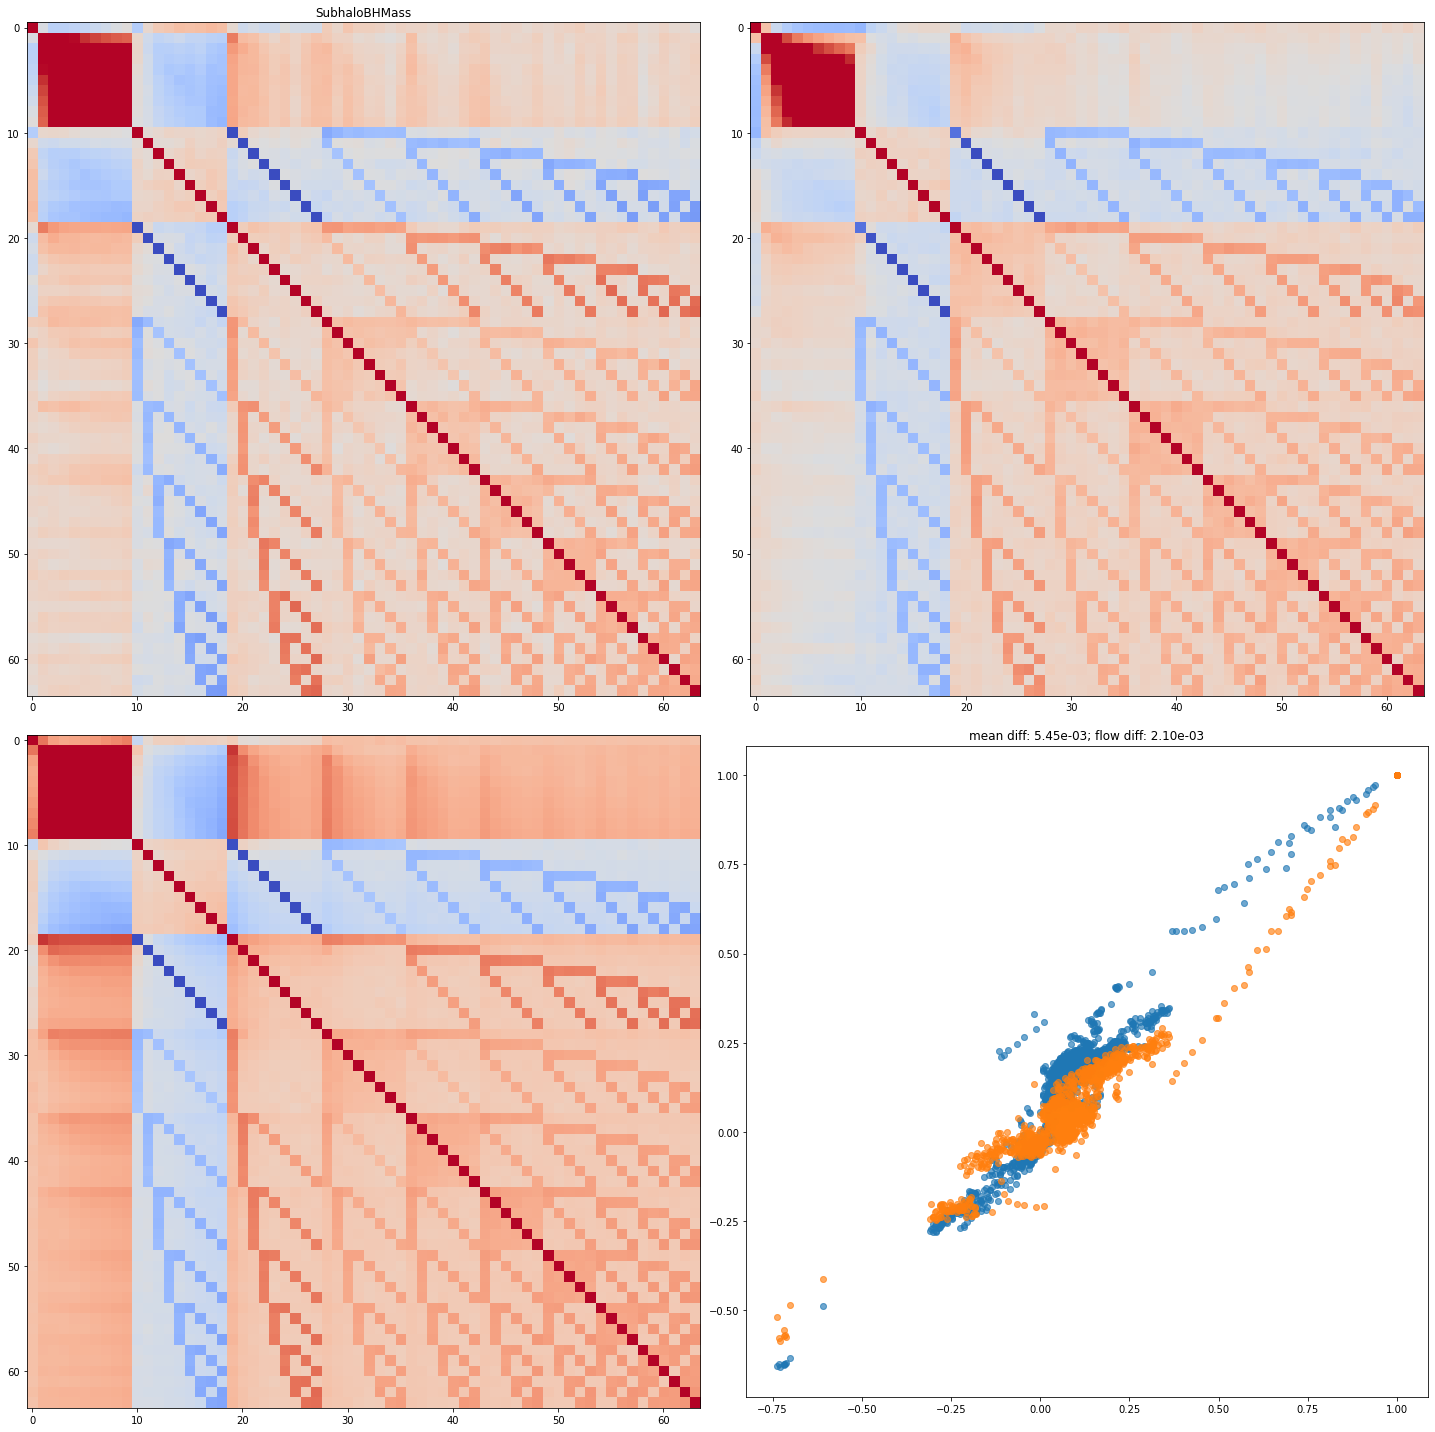

{'SubhaloBHMass': [0.1, 0.2]}


<Figure size 432x288 with 0 Axes>

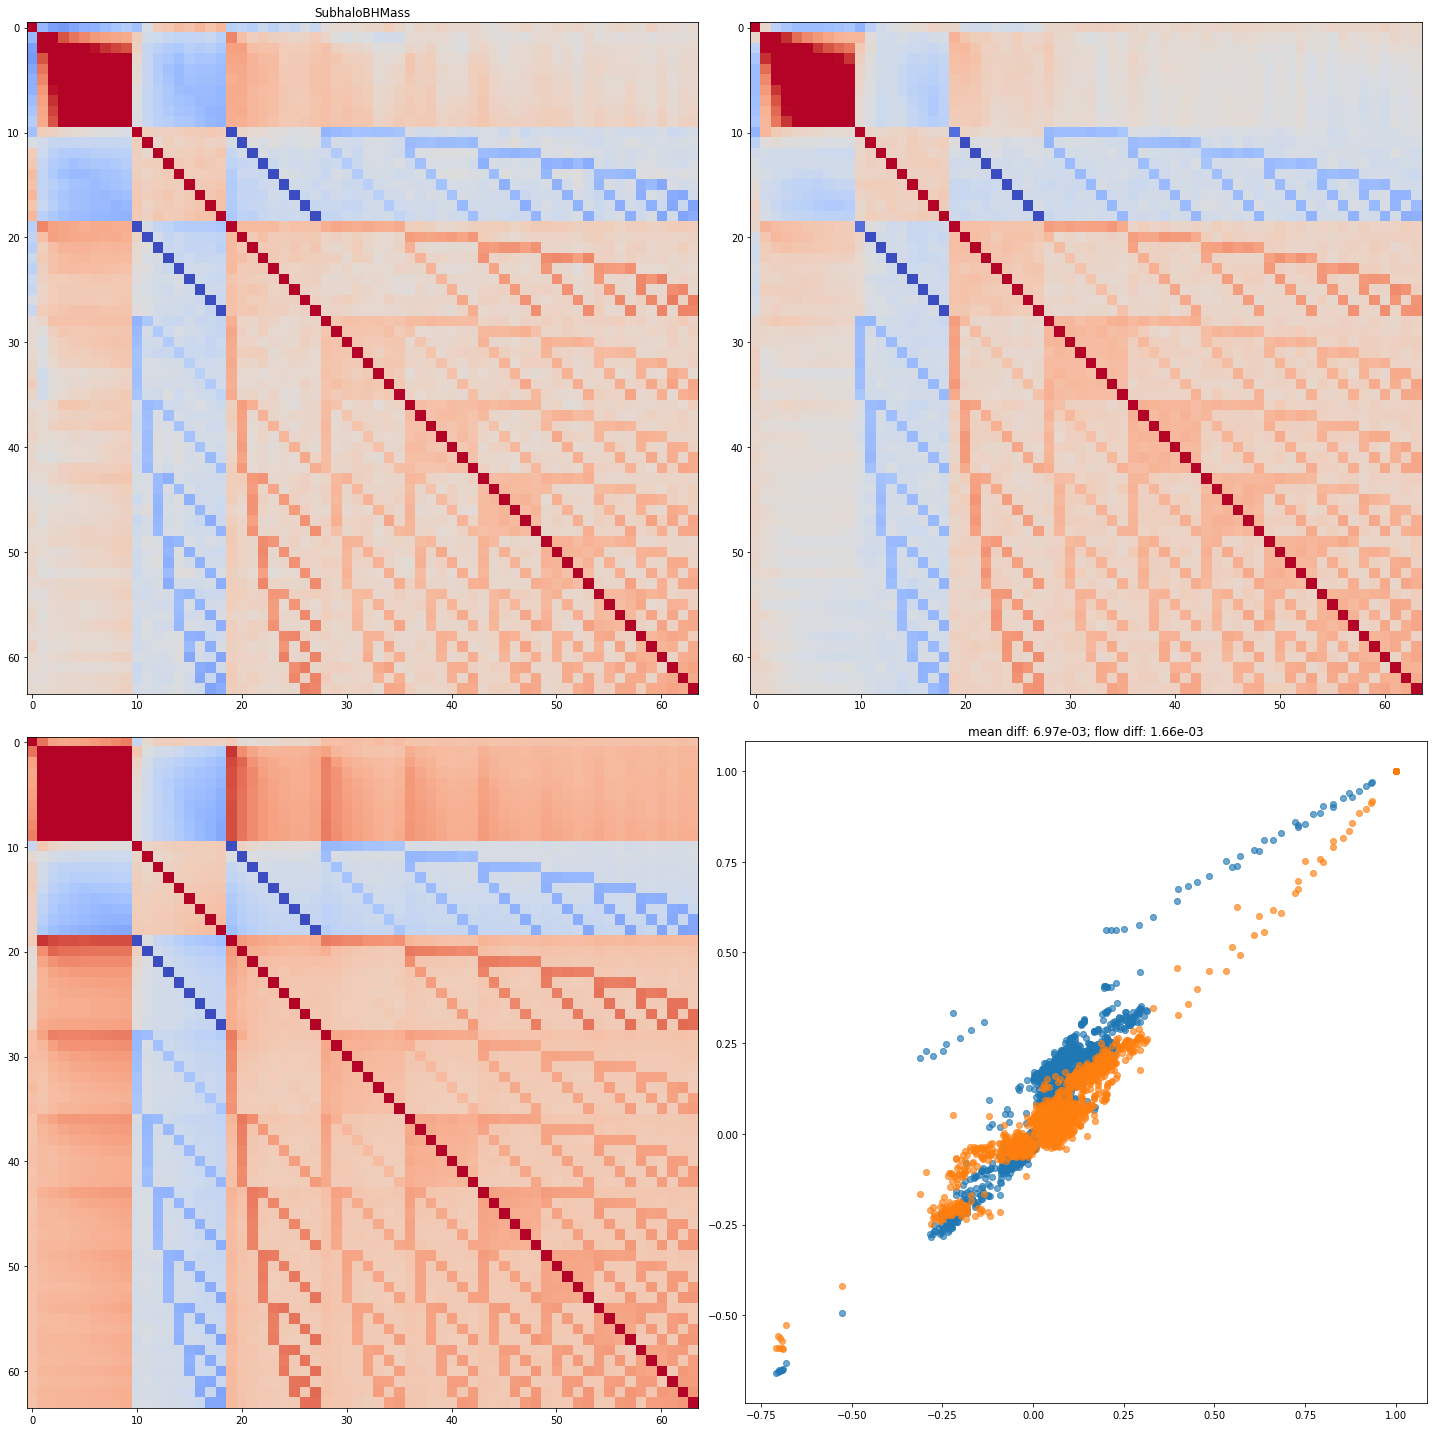

{'SubhaloBHMass': [0.2, 0.30000000000000004]}


<Figure size 432x288 with 0 Axes>

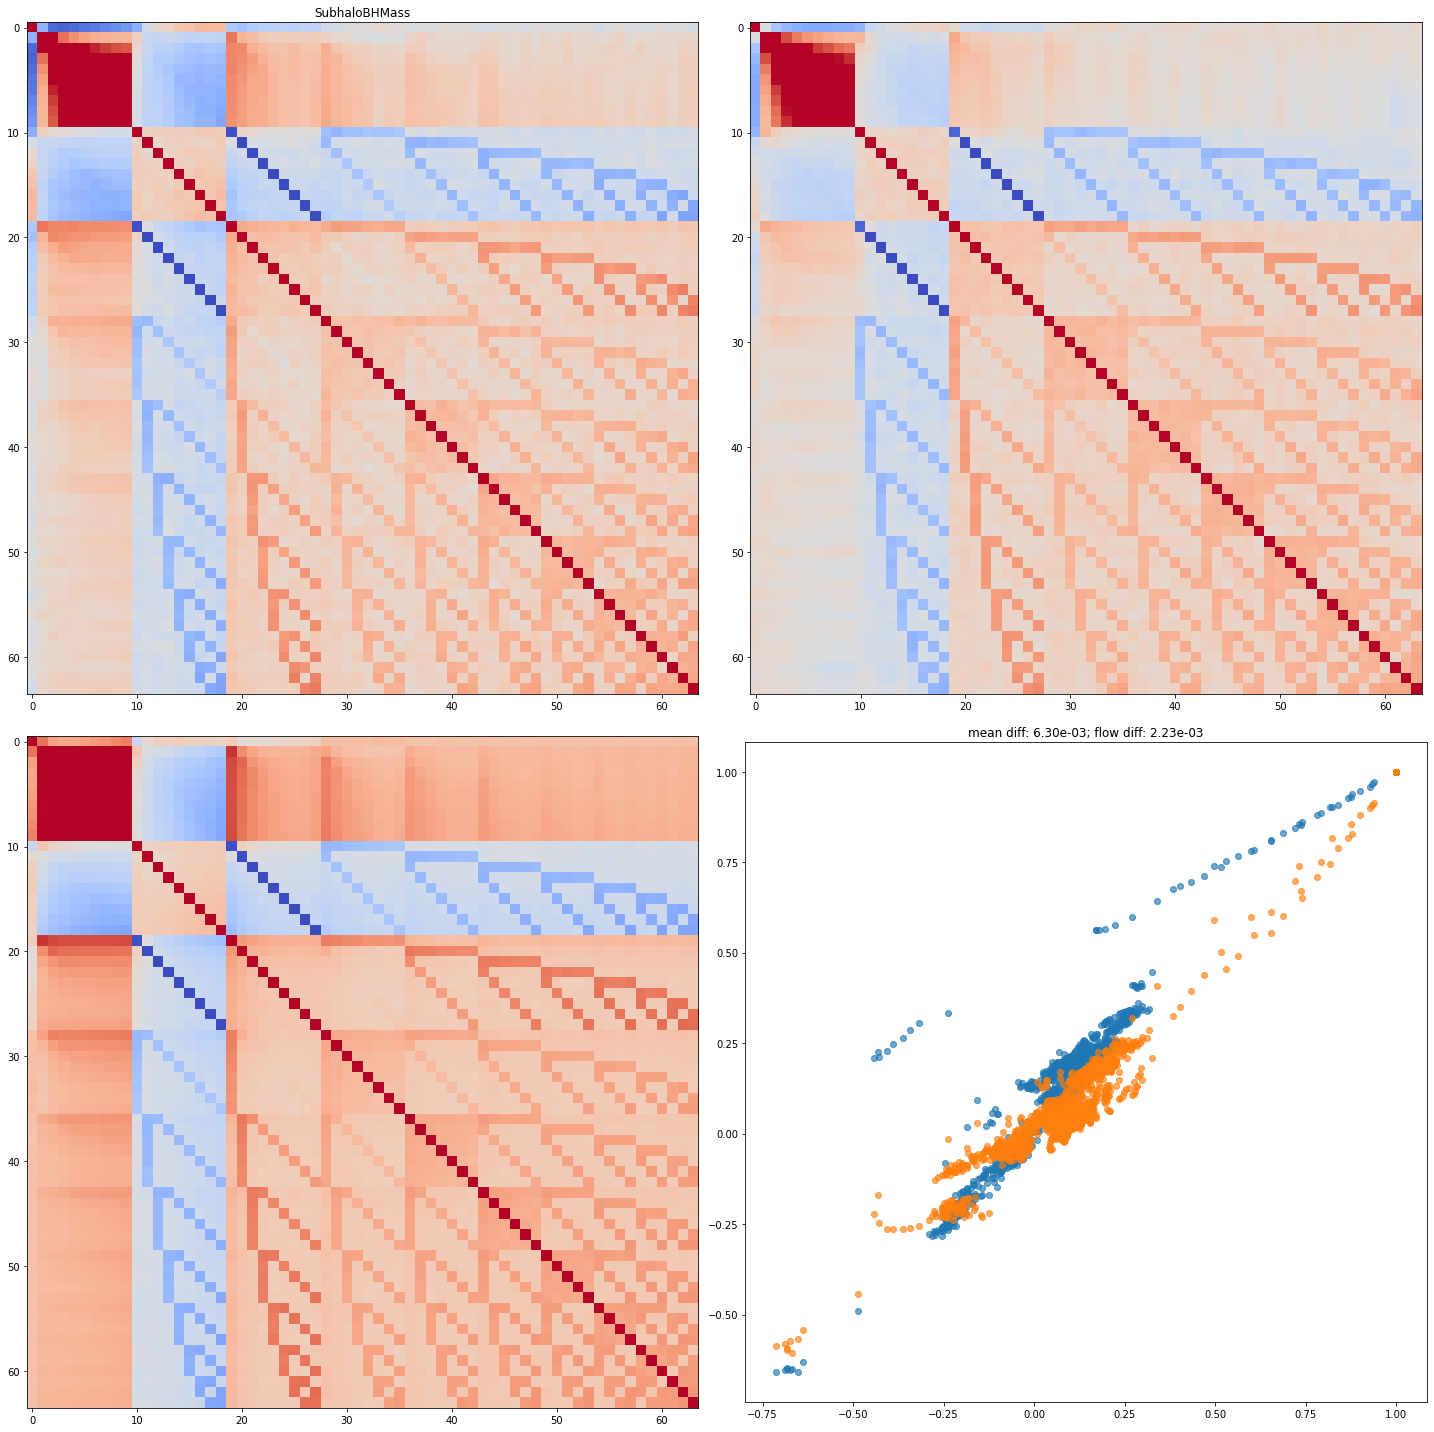

{'SubhaloBHMass': [0.30000000000000004, 0.4]}


<Figure size 432x288 with 0 Axes>

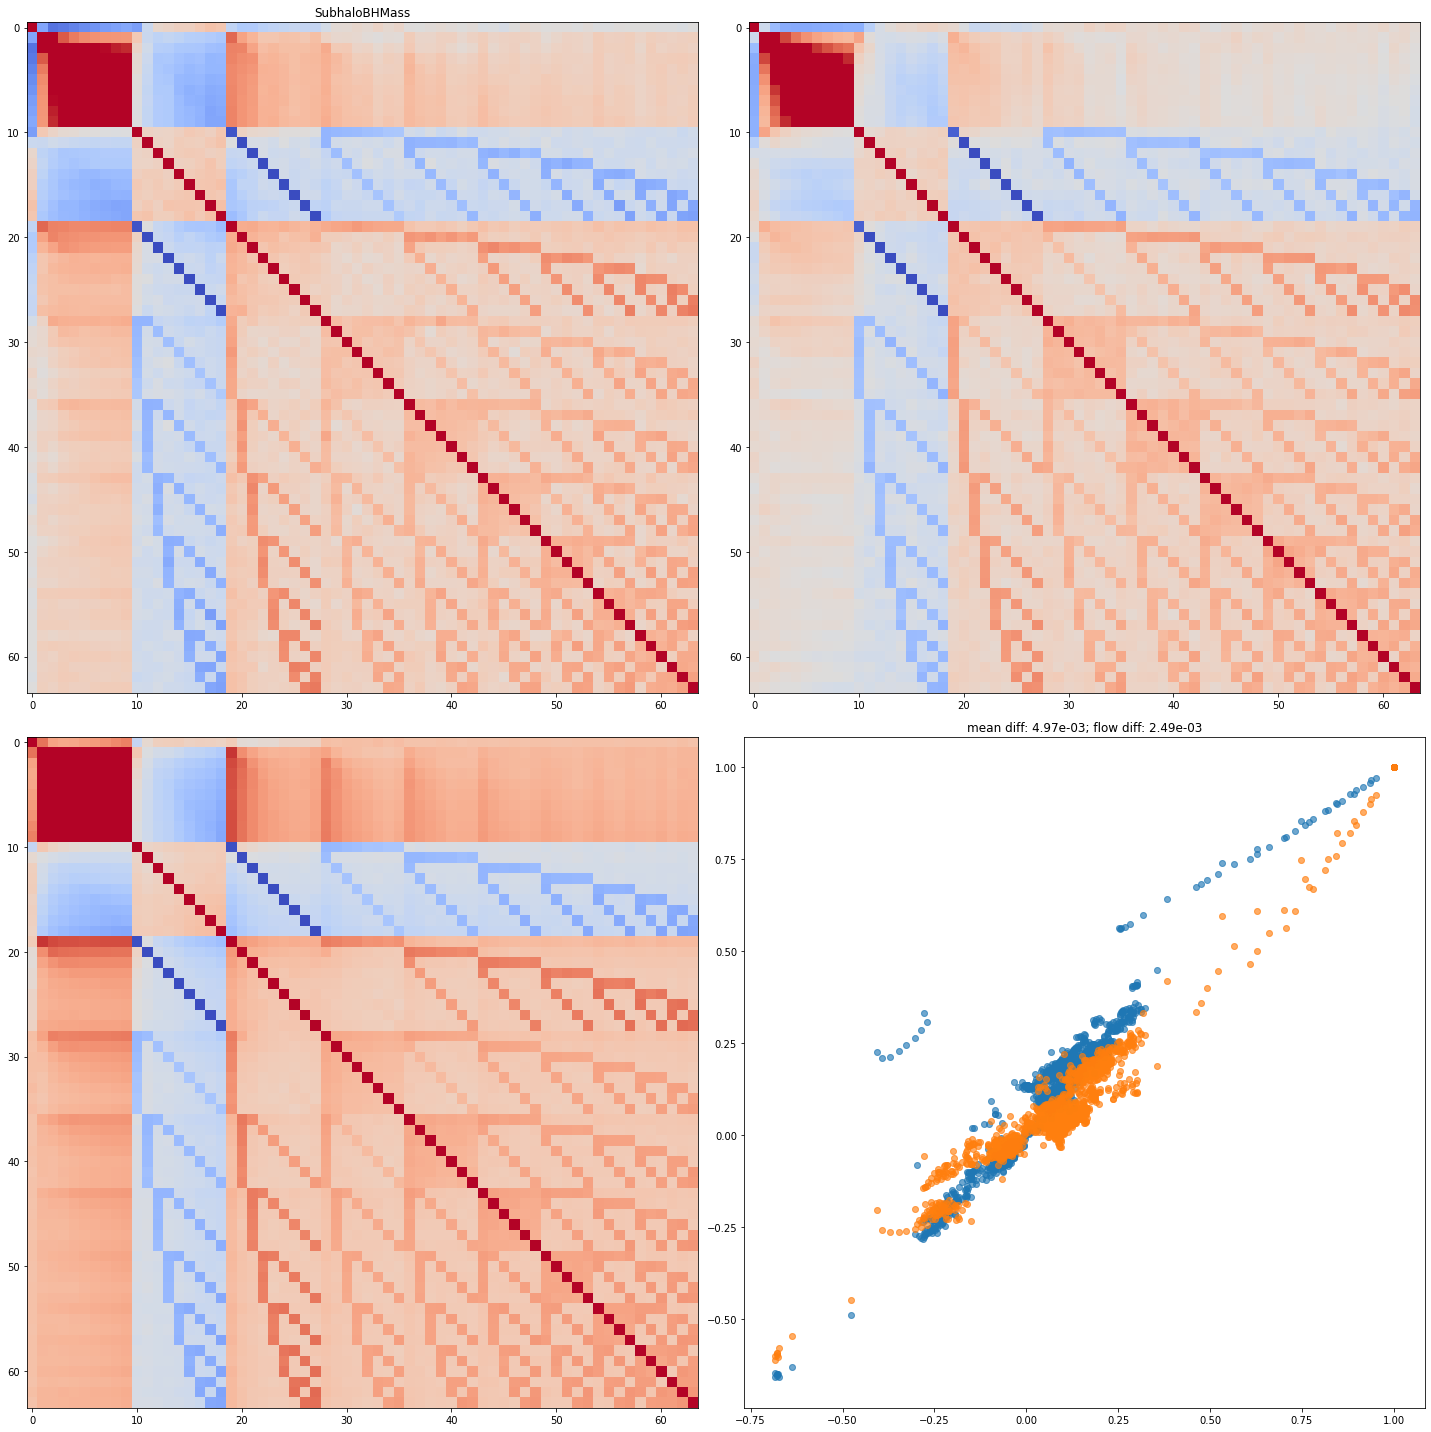

{'SubhaloBHMass': [0.4, 0.5]}


<Figure size 432x288 with 0 Axes>

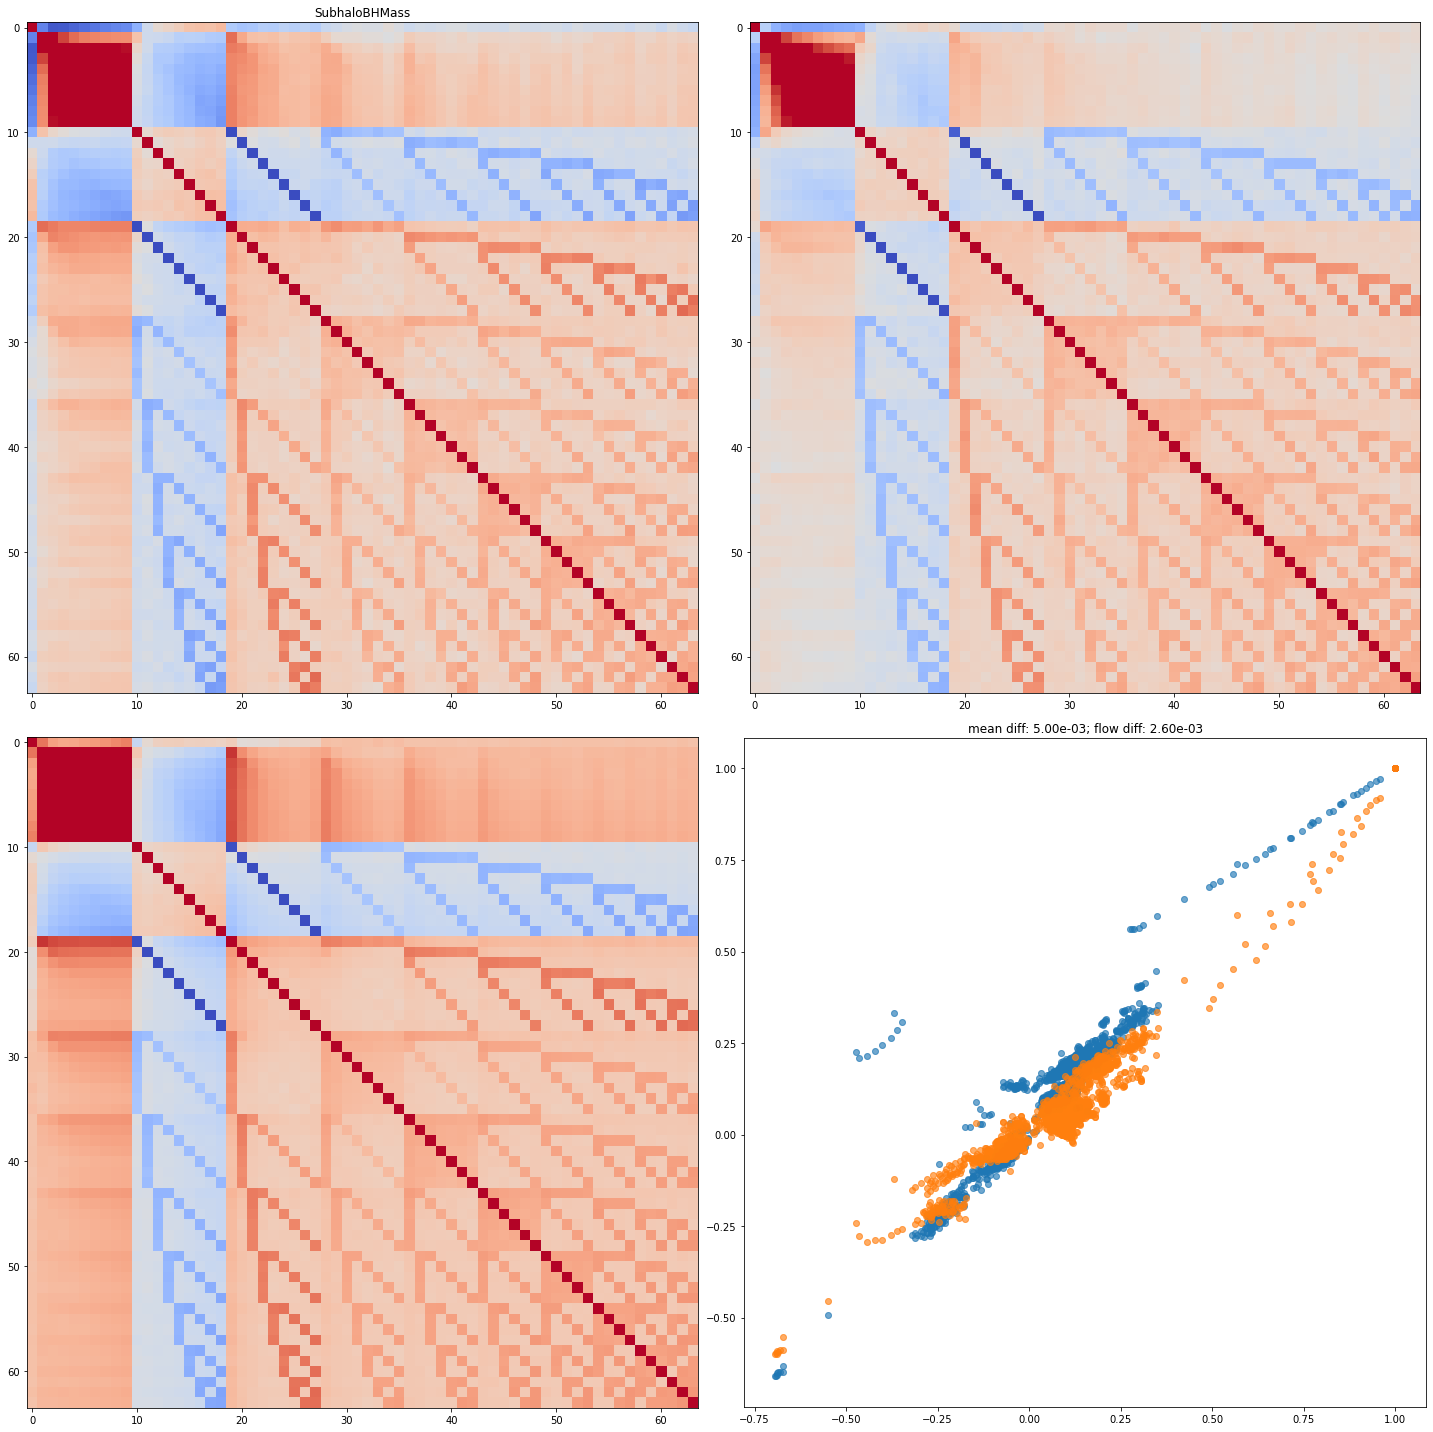

{'SubhaloBHMass': [0.5, 0.6000000000000001]}


<Figure size 432x288 with 0 Axes>

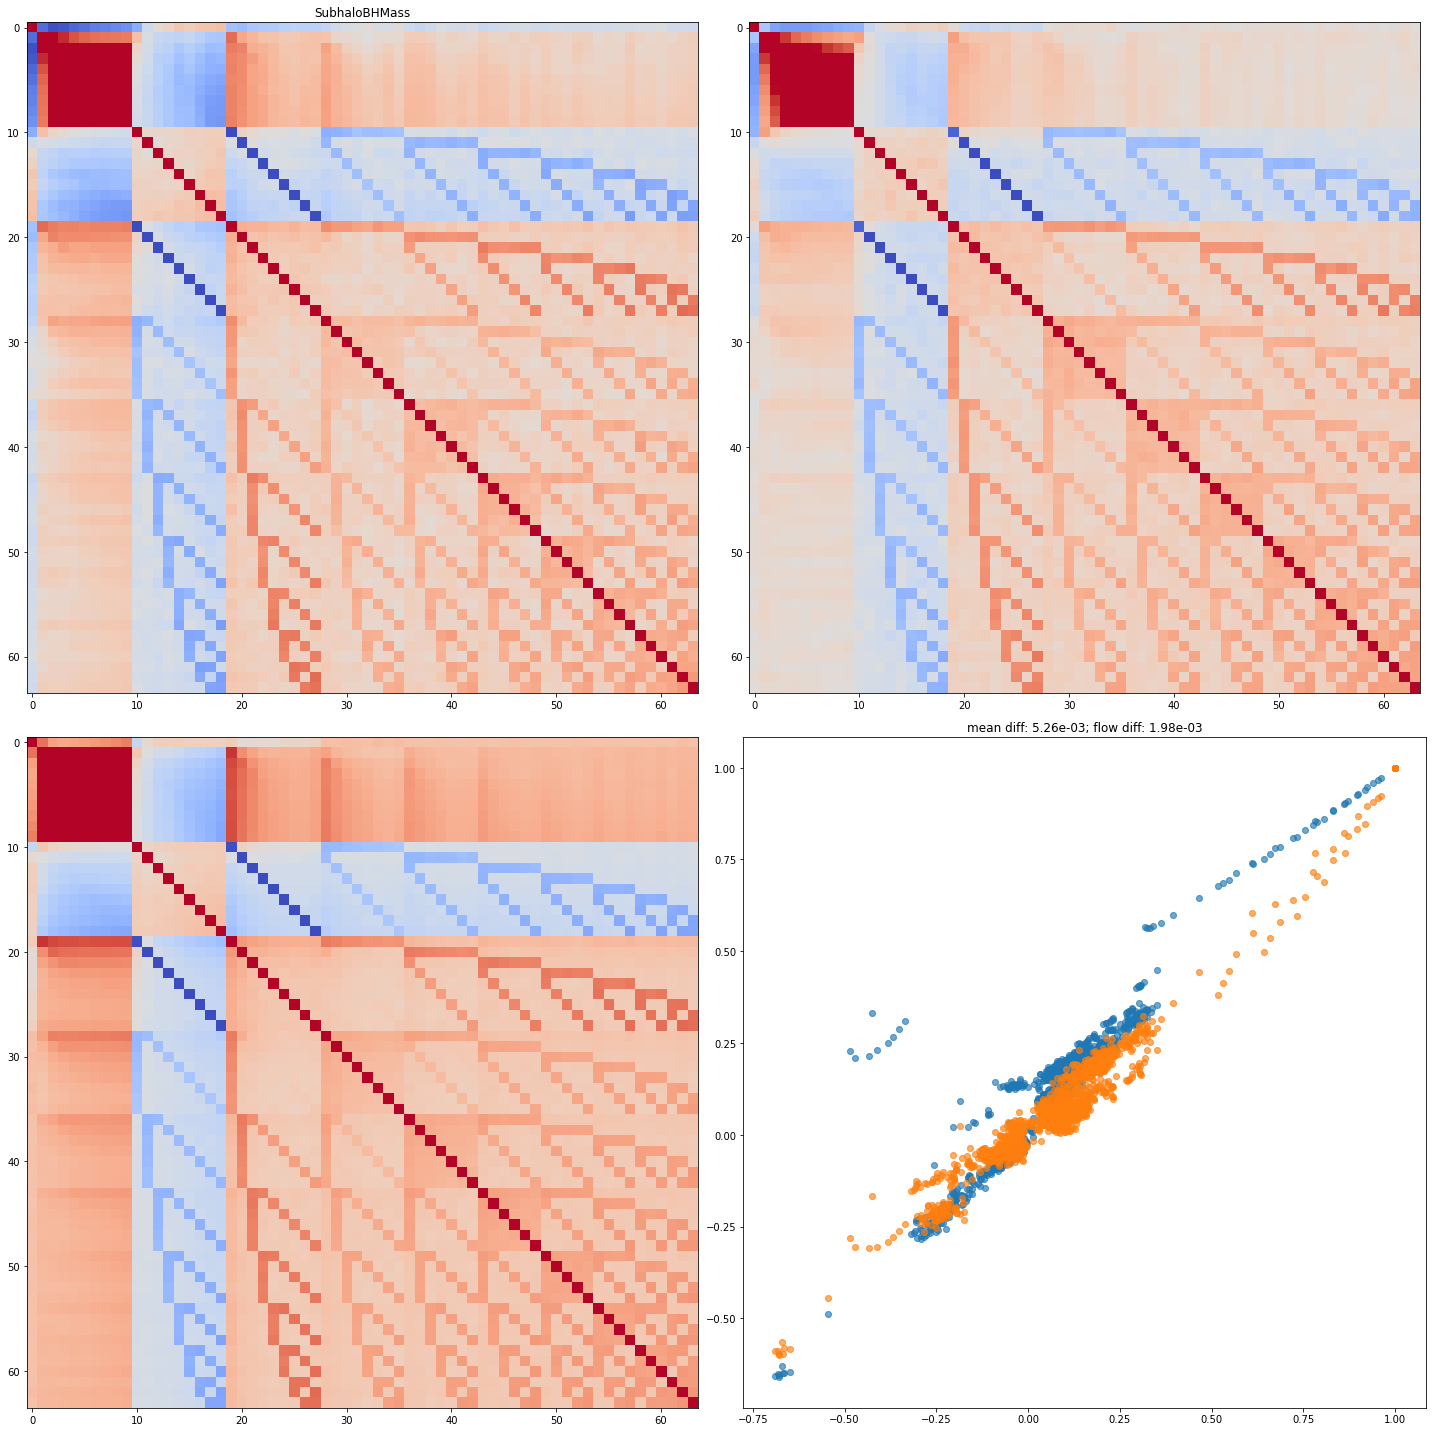

{'SubhaloBHMass': [0.6000000000000001, 0.7000000000000001]}


<Figure size 432x288 with 0 Axes>

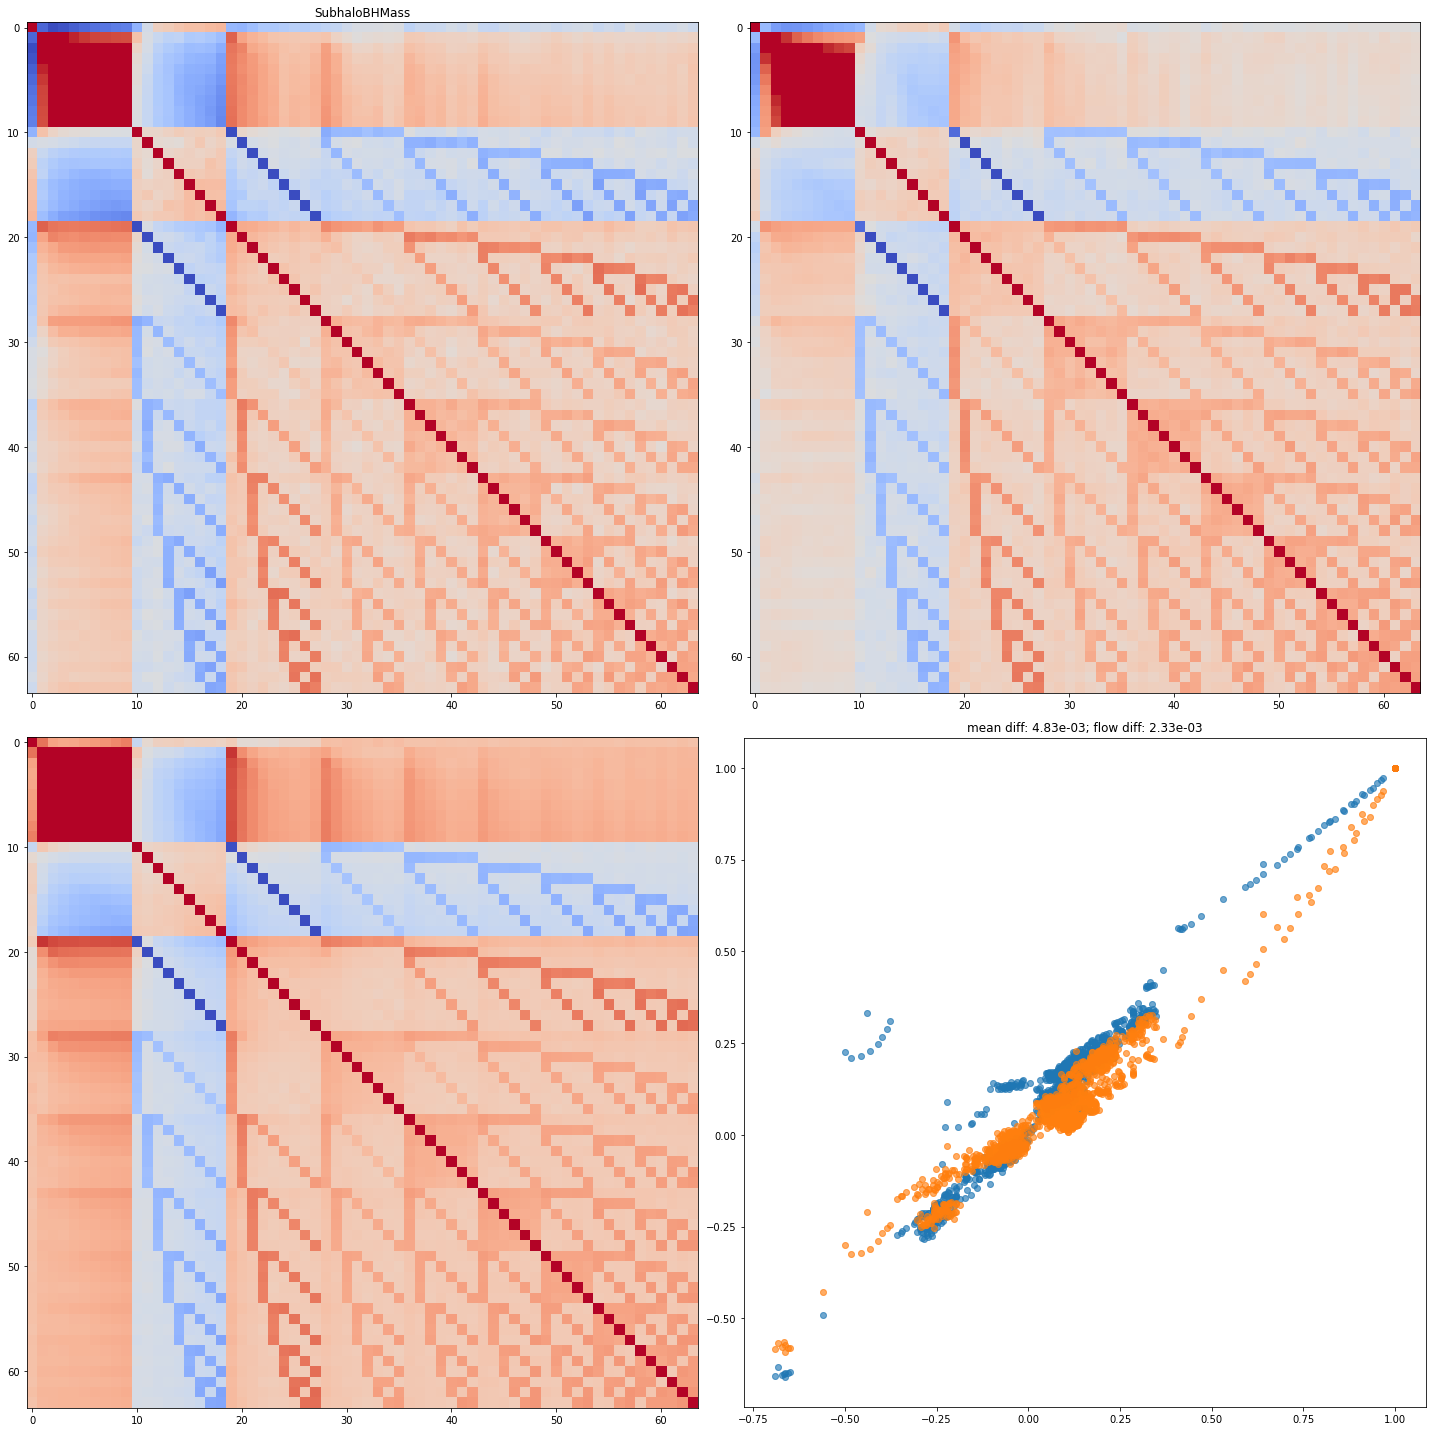

{'SubhaloBHMass': [0.7000000000000001, 0.8]}


<Figure size 432x288 with 0 Axes>

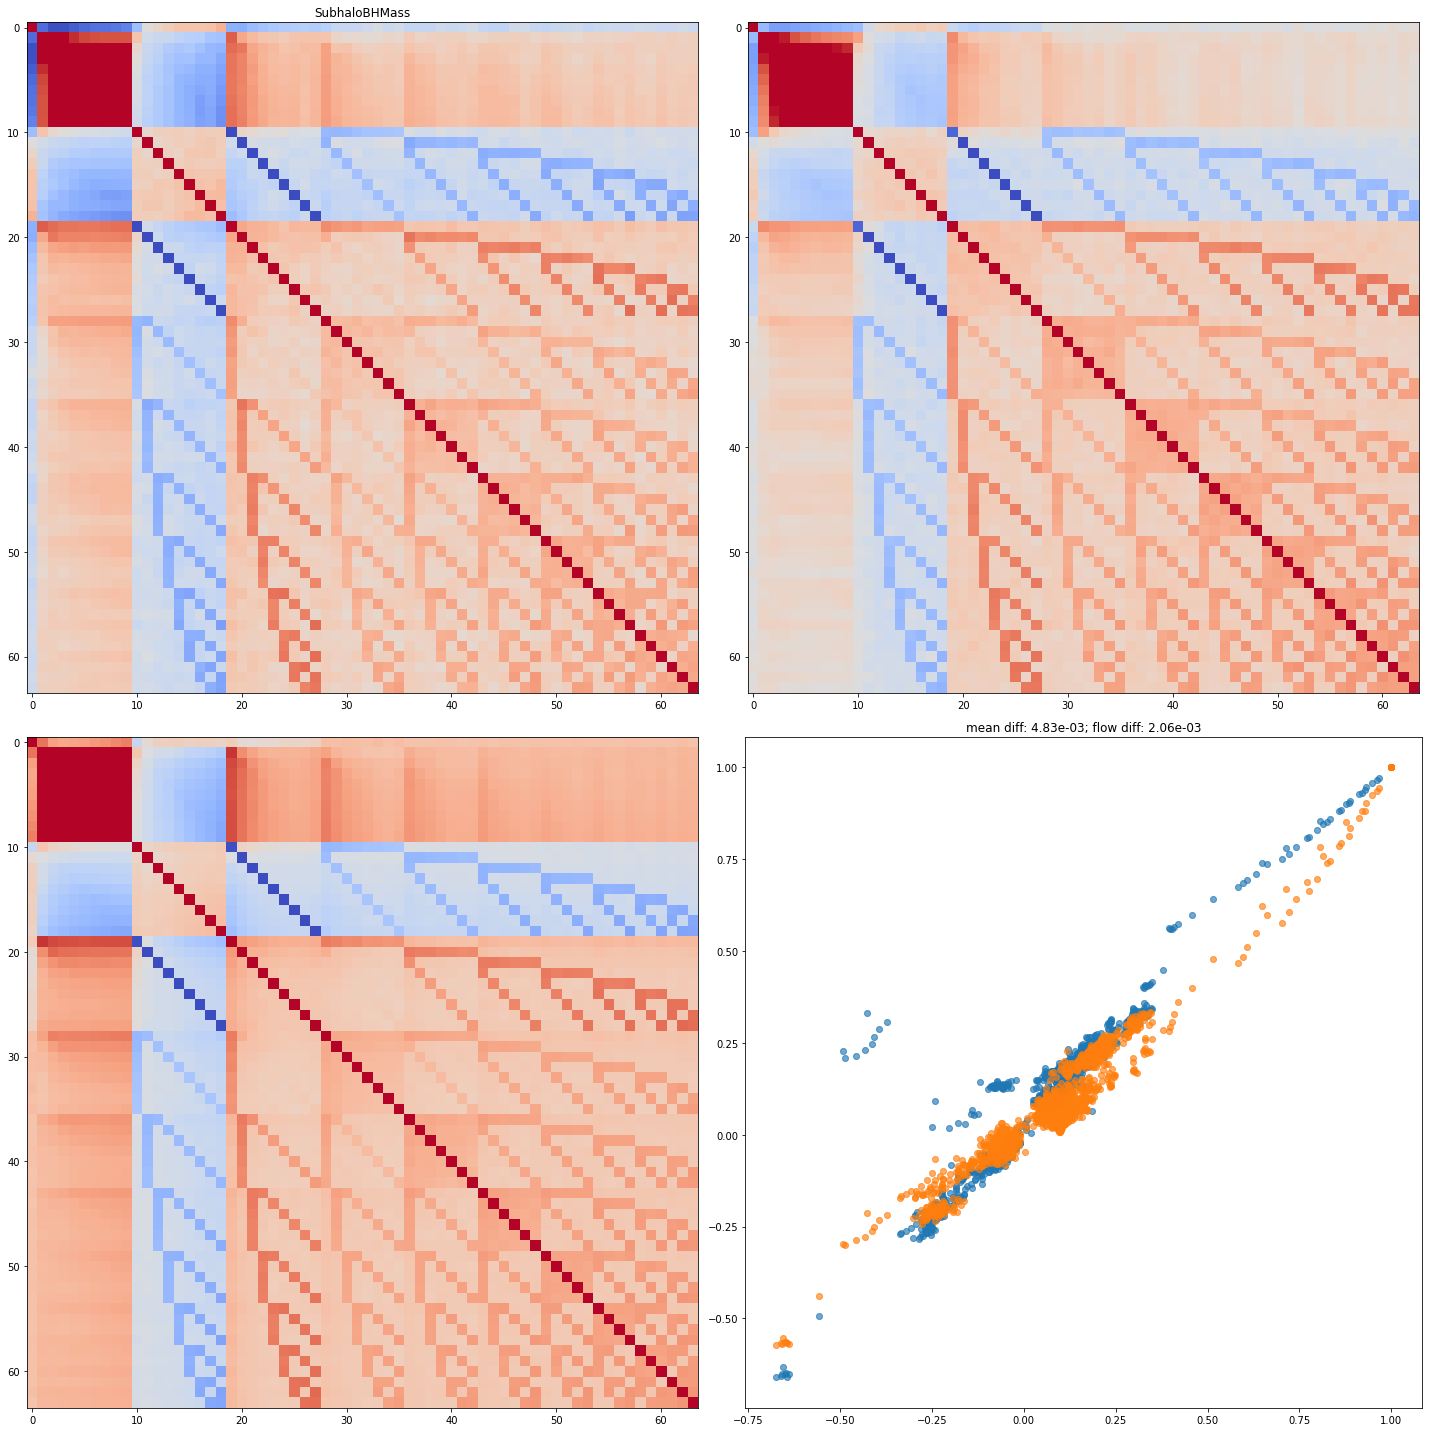

{'SubhaloBHMass': [0.8, 0.9]}


<Figure size 432x288 with 0 Axes>

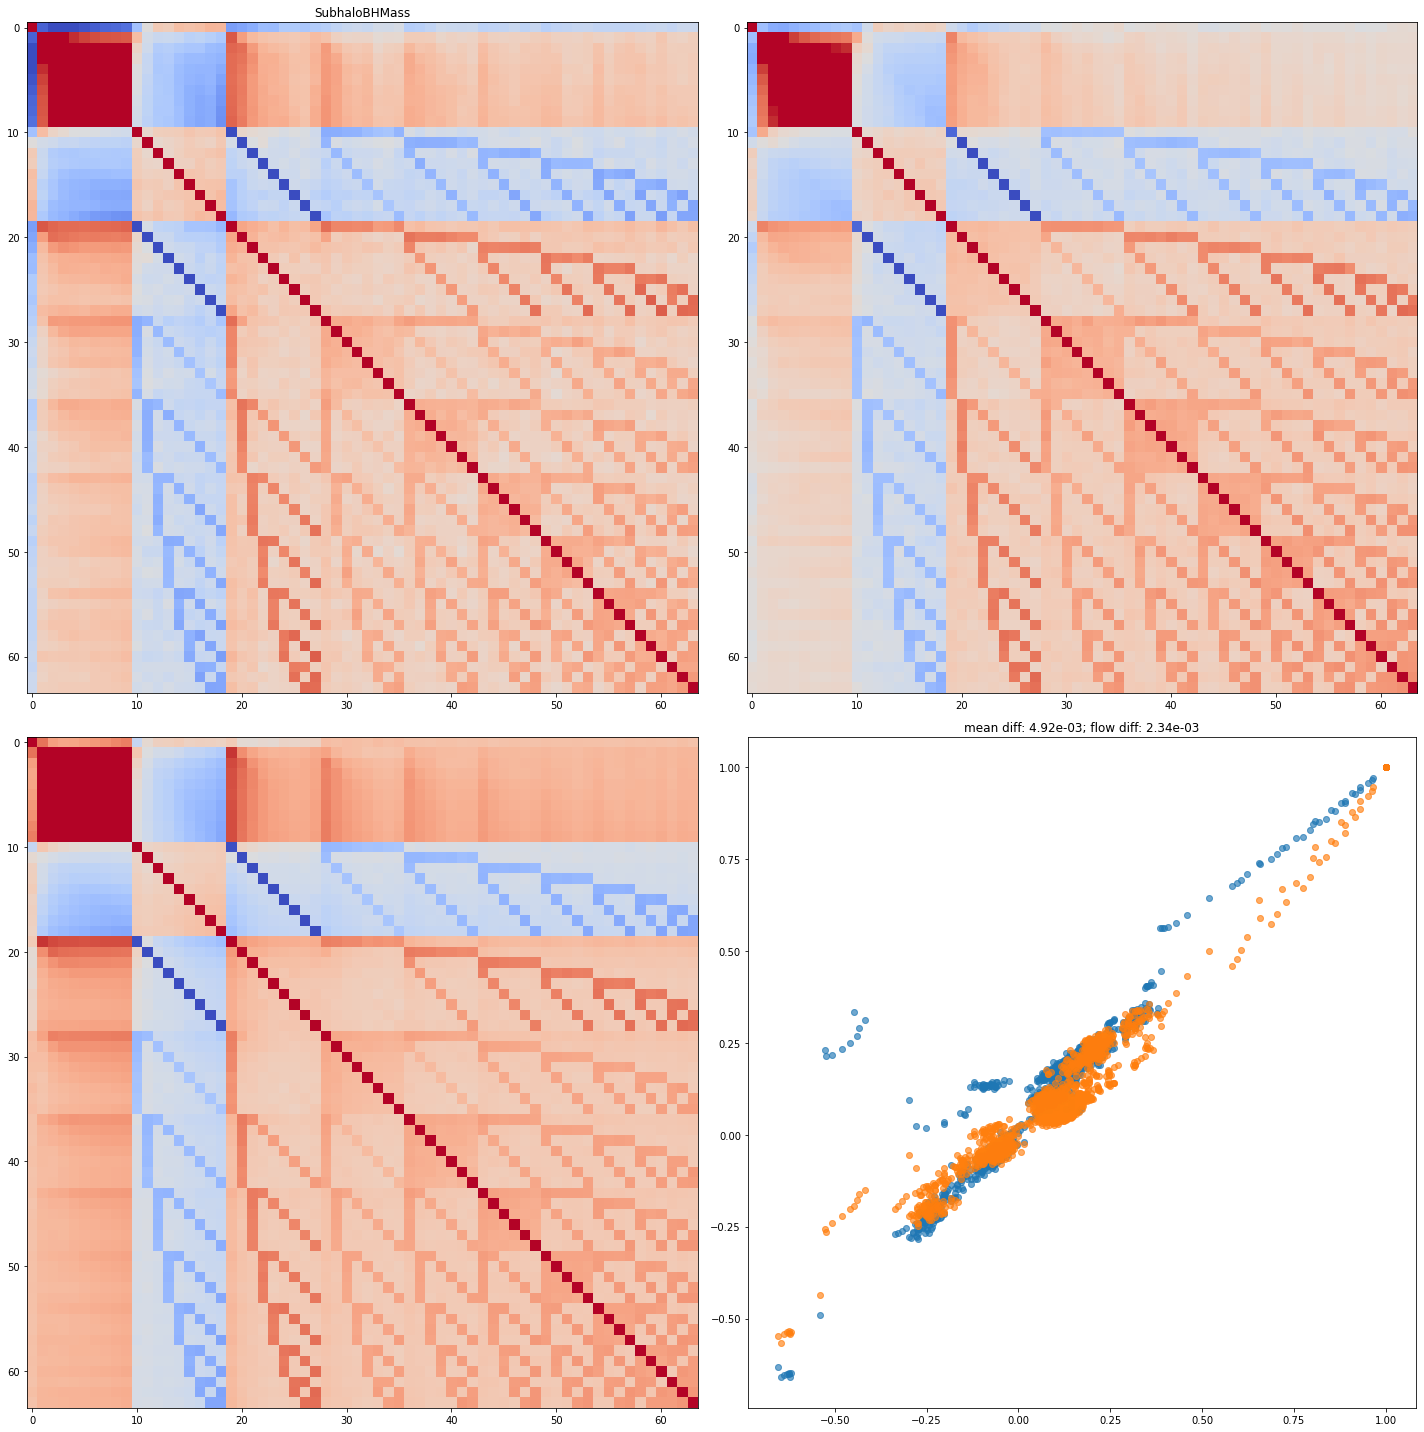

{'SubhaloBHMass': [0.9, 1.0]}


<Figure size 432x288 with 0 Axes>

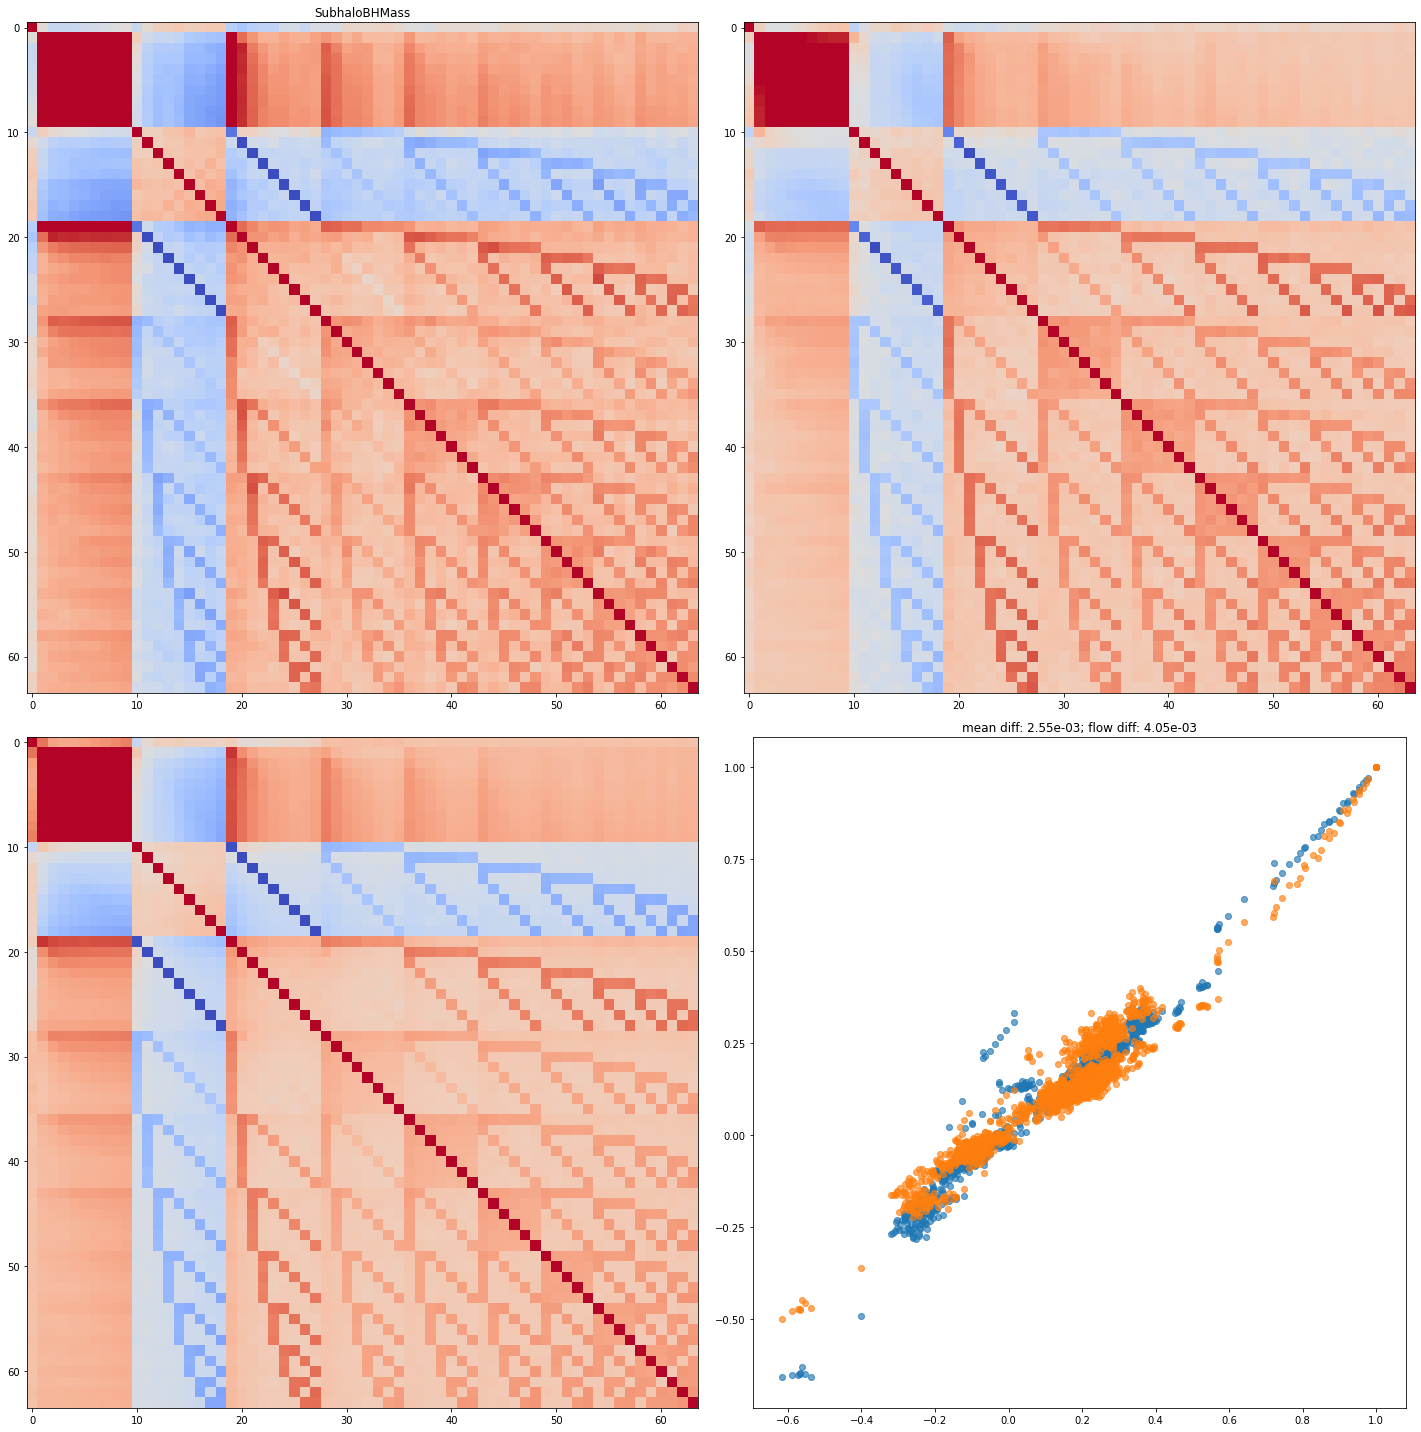

{'SubhaloBHMdot': [0.0, 0.1]}


<Figure size 432x288 with 0 Axes>

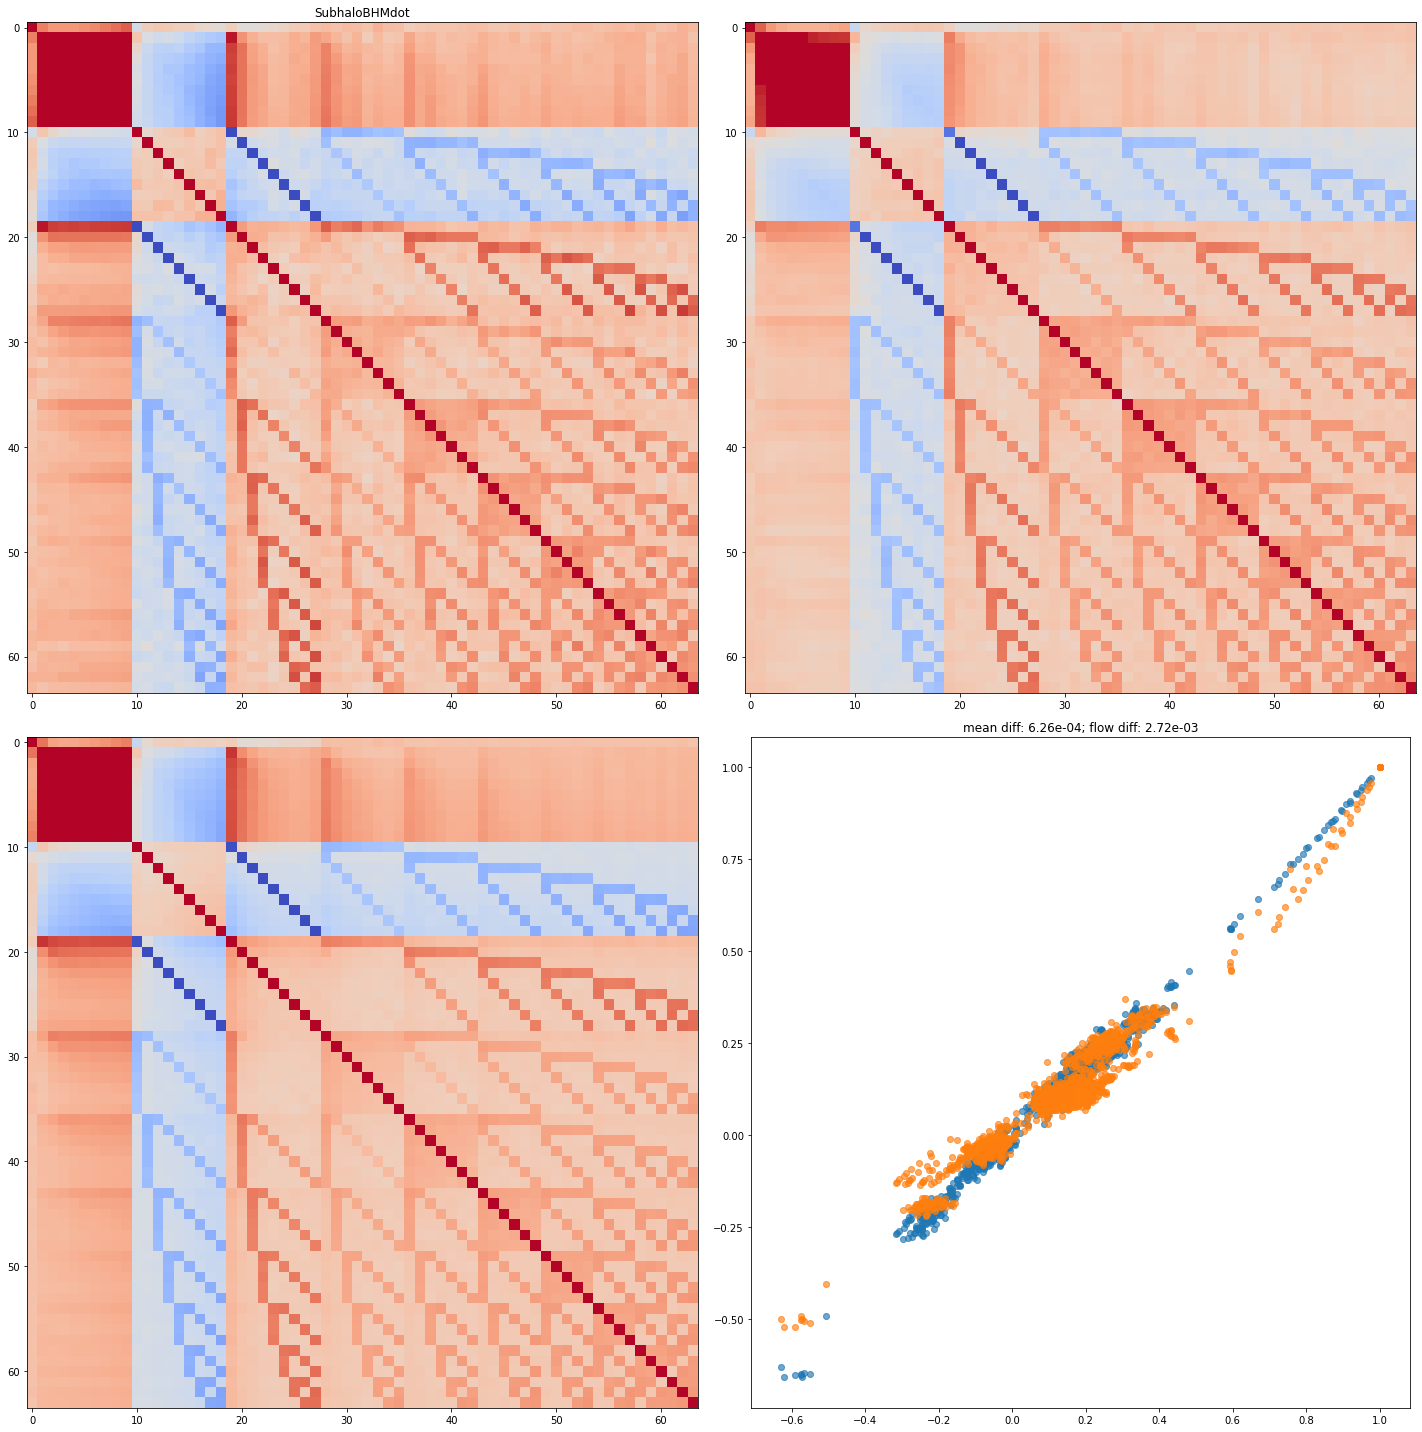

{'SubhaloBHMdot': [0.1, 0.2]}


<Figure size 432x288 with 0 Axes>

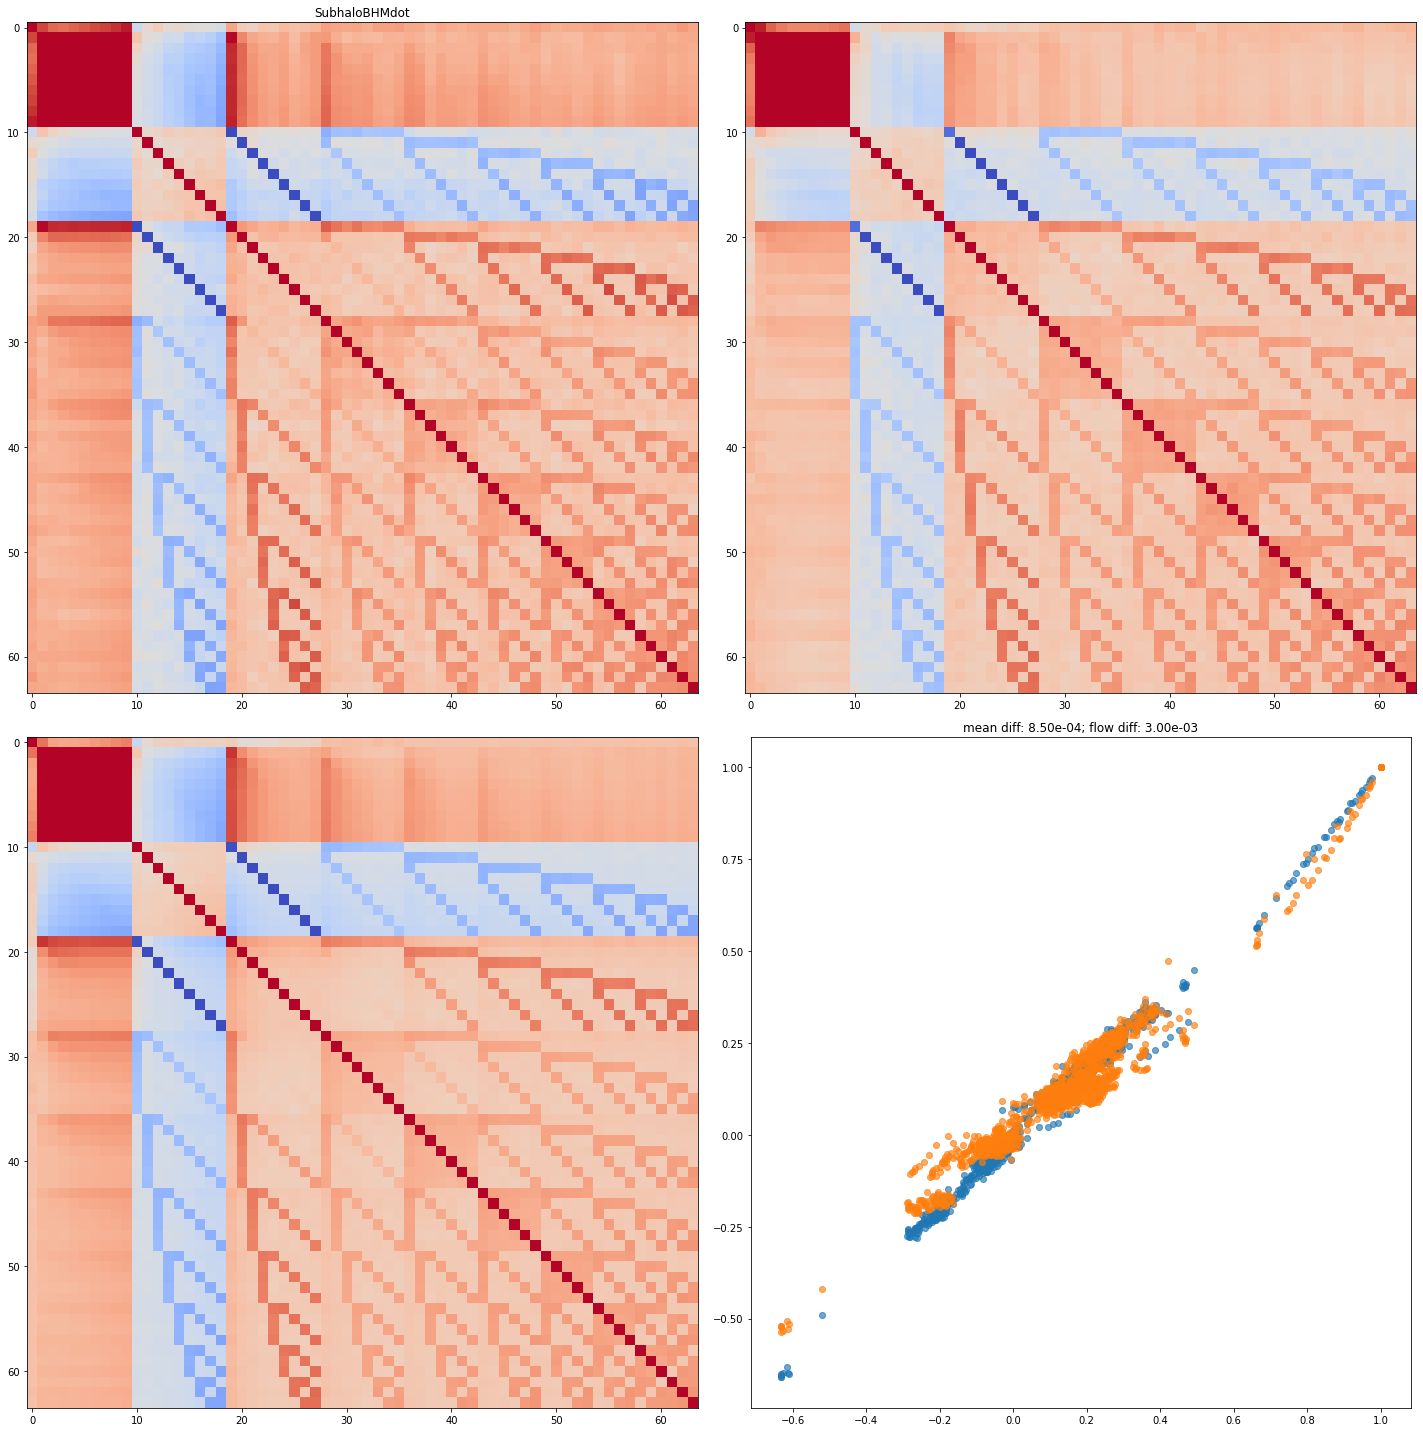

{'SubhaloBHMdot': [0.2, 0.30000000000000004]}


<Figure size 432x288 with 0 Axes>

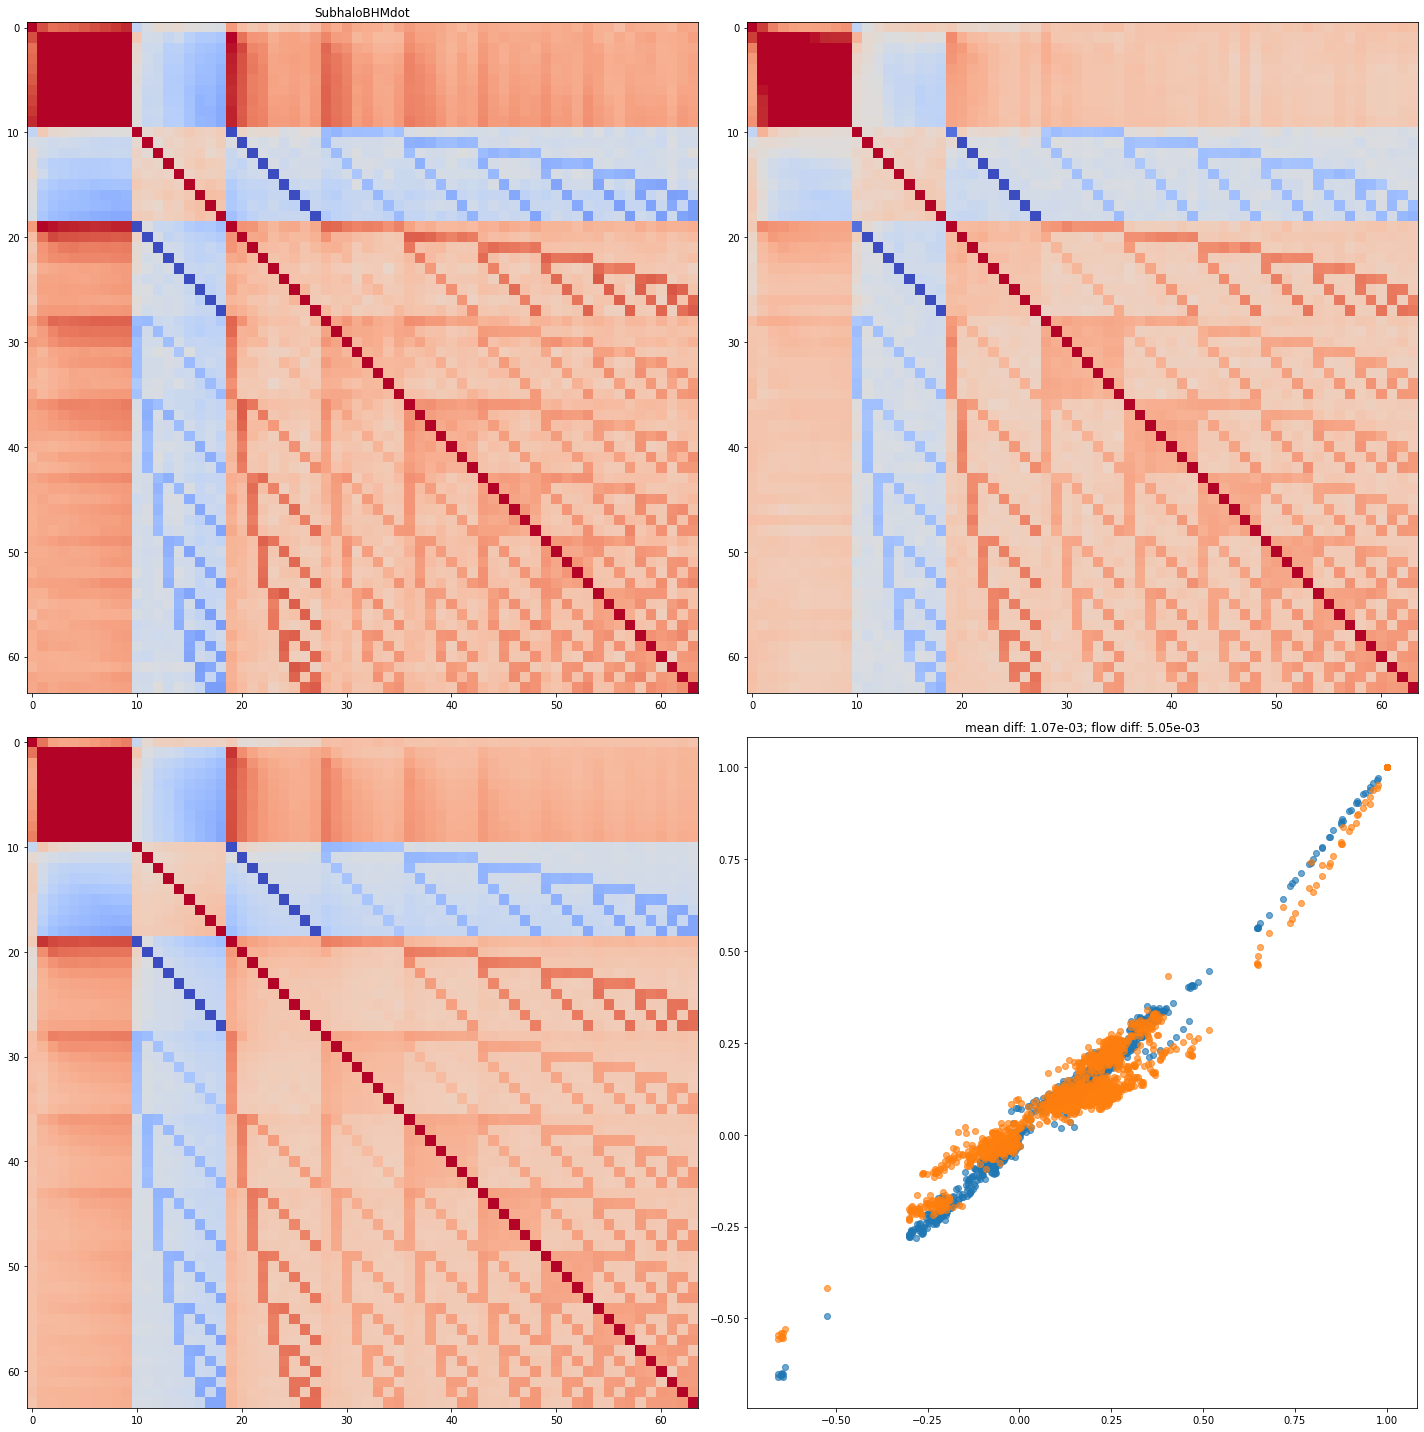

{'SubhaloBHMdot': [0.30000000000000004, 0.4]}


<Figure size 432x288 with 0 Axes>

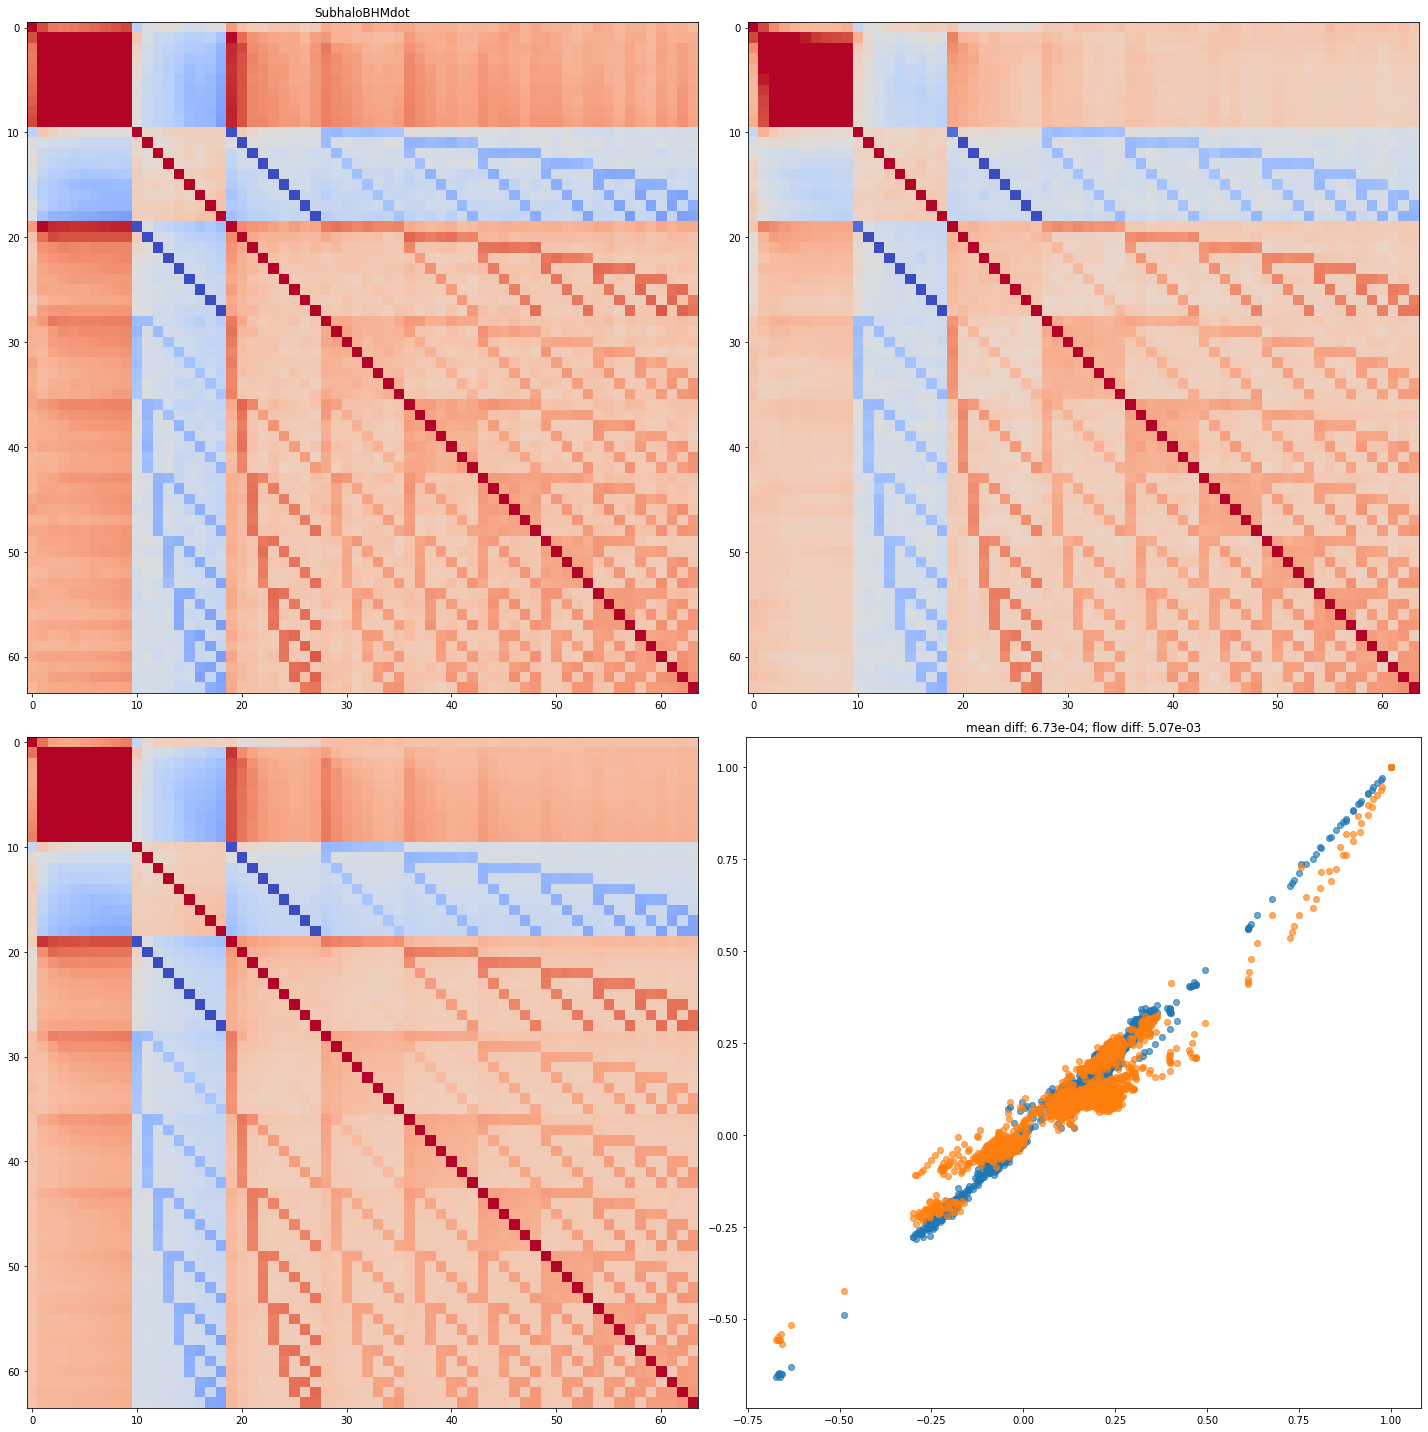

{'SubhaloBHMdot': [0.4, 0.5]}


<Figure size 432x288 with 0 Axes>

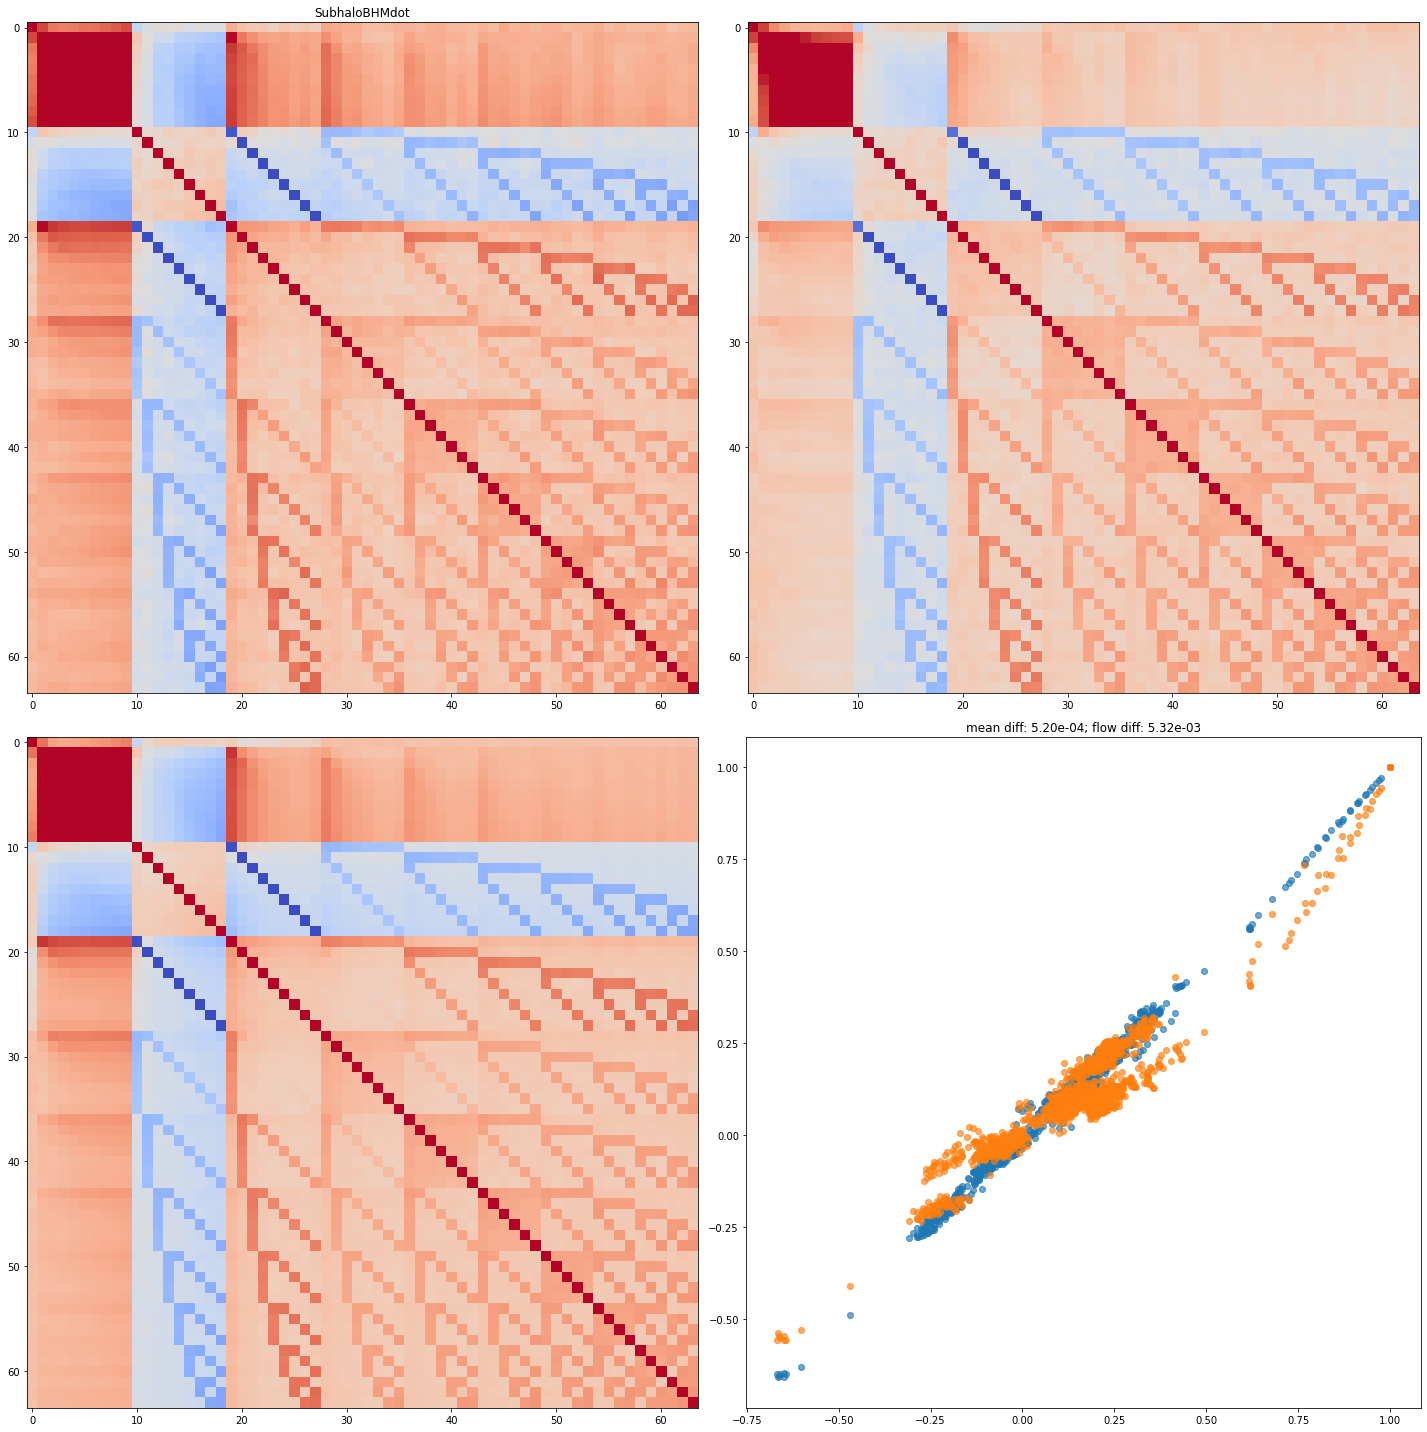

{'SubhaloBHMdot': [0.5, 0.6000000000000001]}


<Figure size 432x288 with 0 Axes>

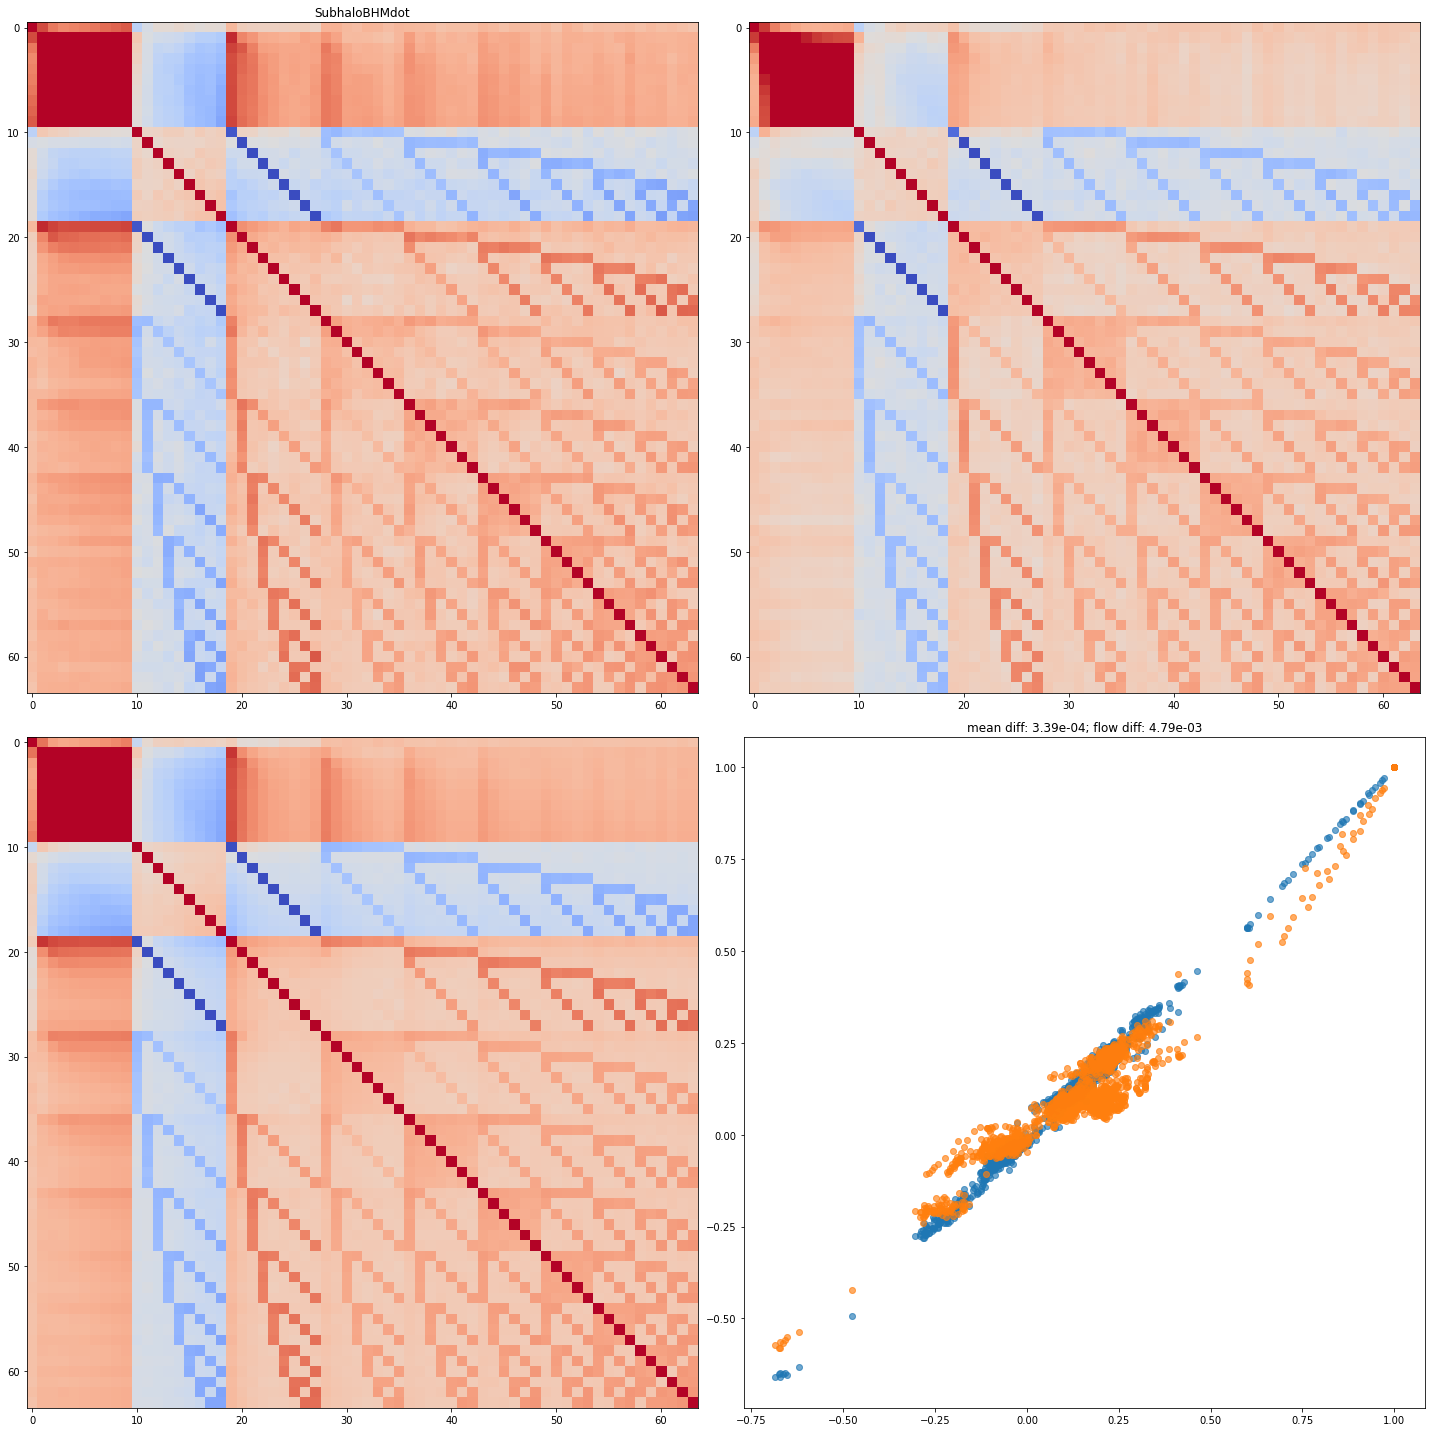

{'SubhaloBHMdot': [0.6000000000000001, 0.7000000000000001]}


<Figure size 432x288 with 0 Axes>

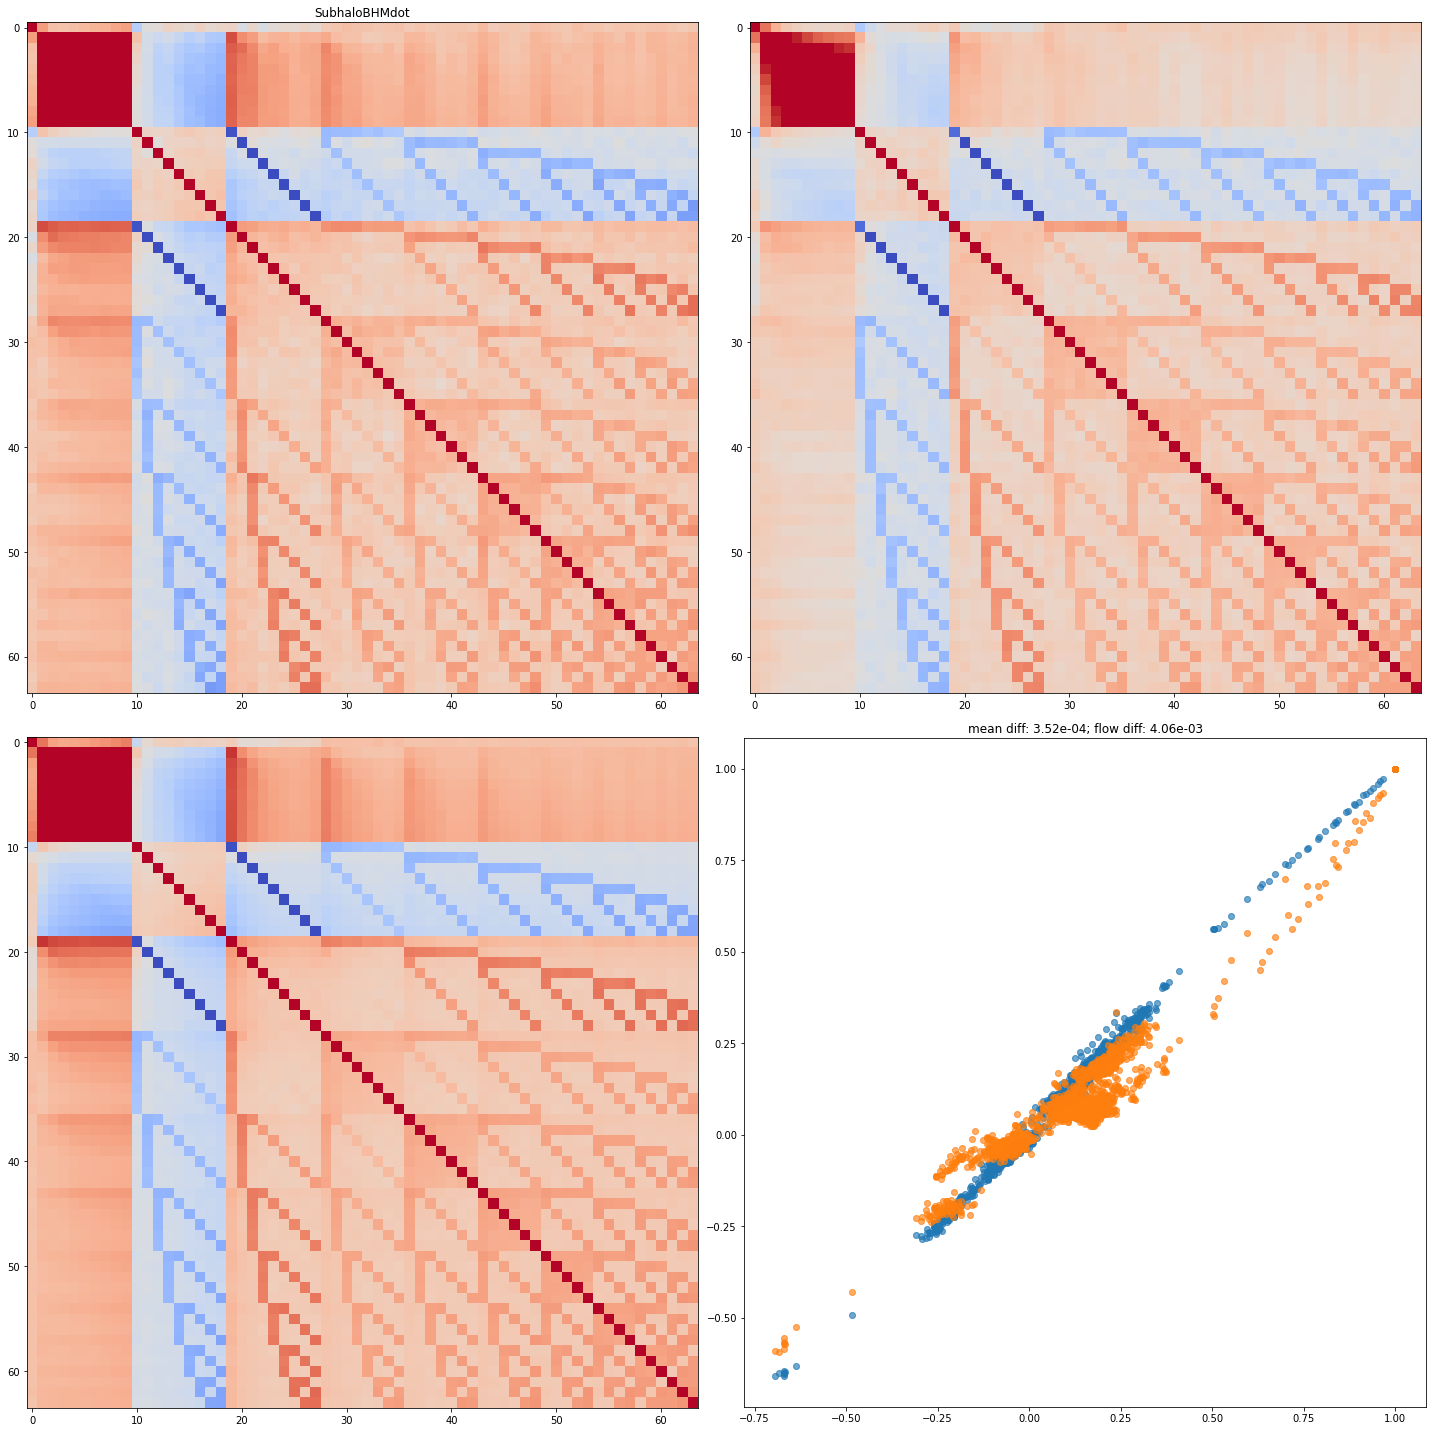

{'SubhaloBHMdot': [0.7000000000000001, 0.8]}


<Figure size 432x288 with 0 Axes>

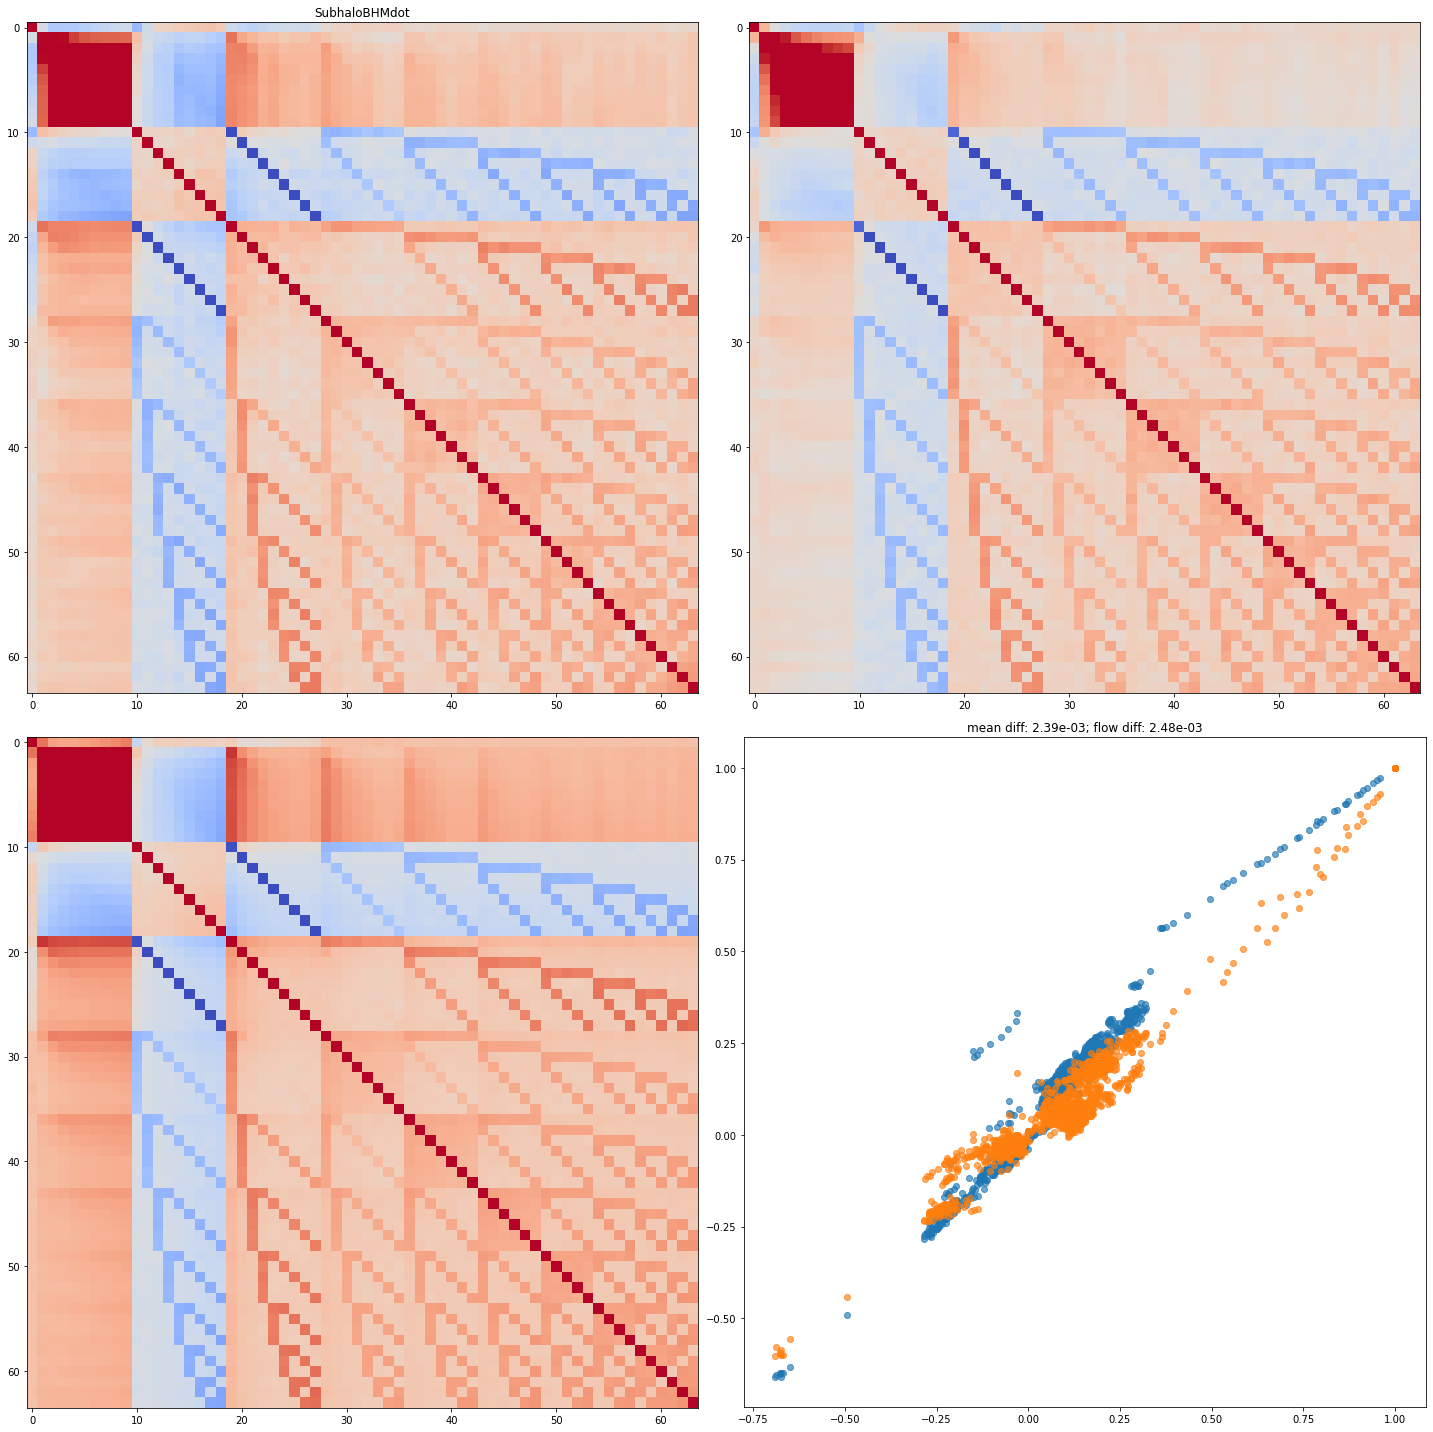

{'SubhaloBHMdot': [0.8, 0.9]}


<Figure size 432x288 with 0 Axes>

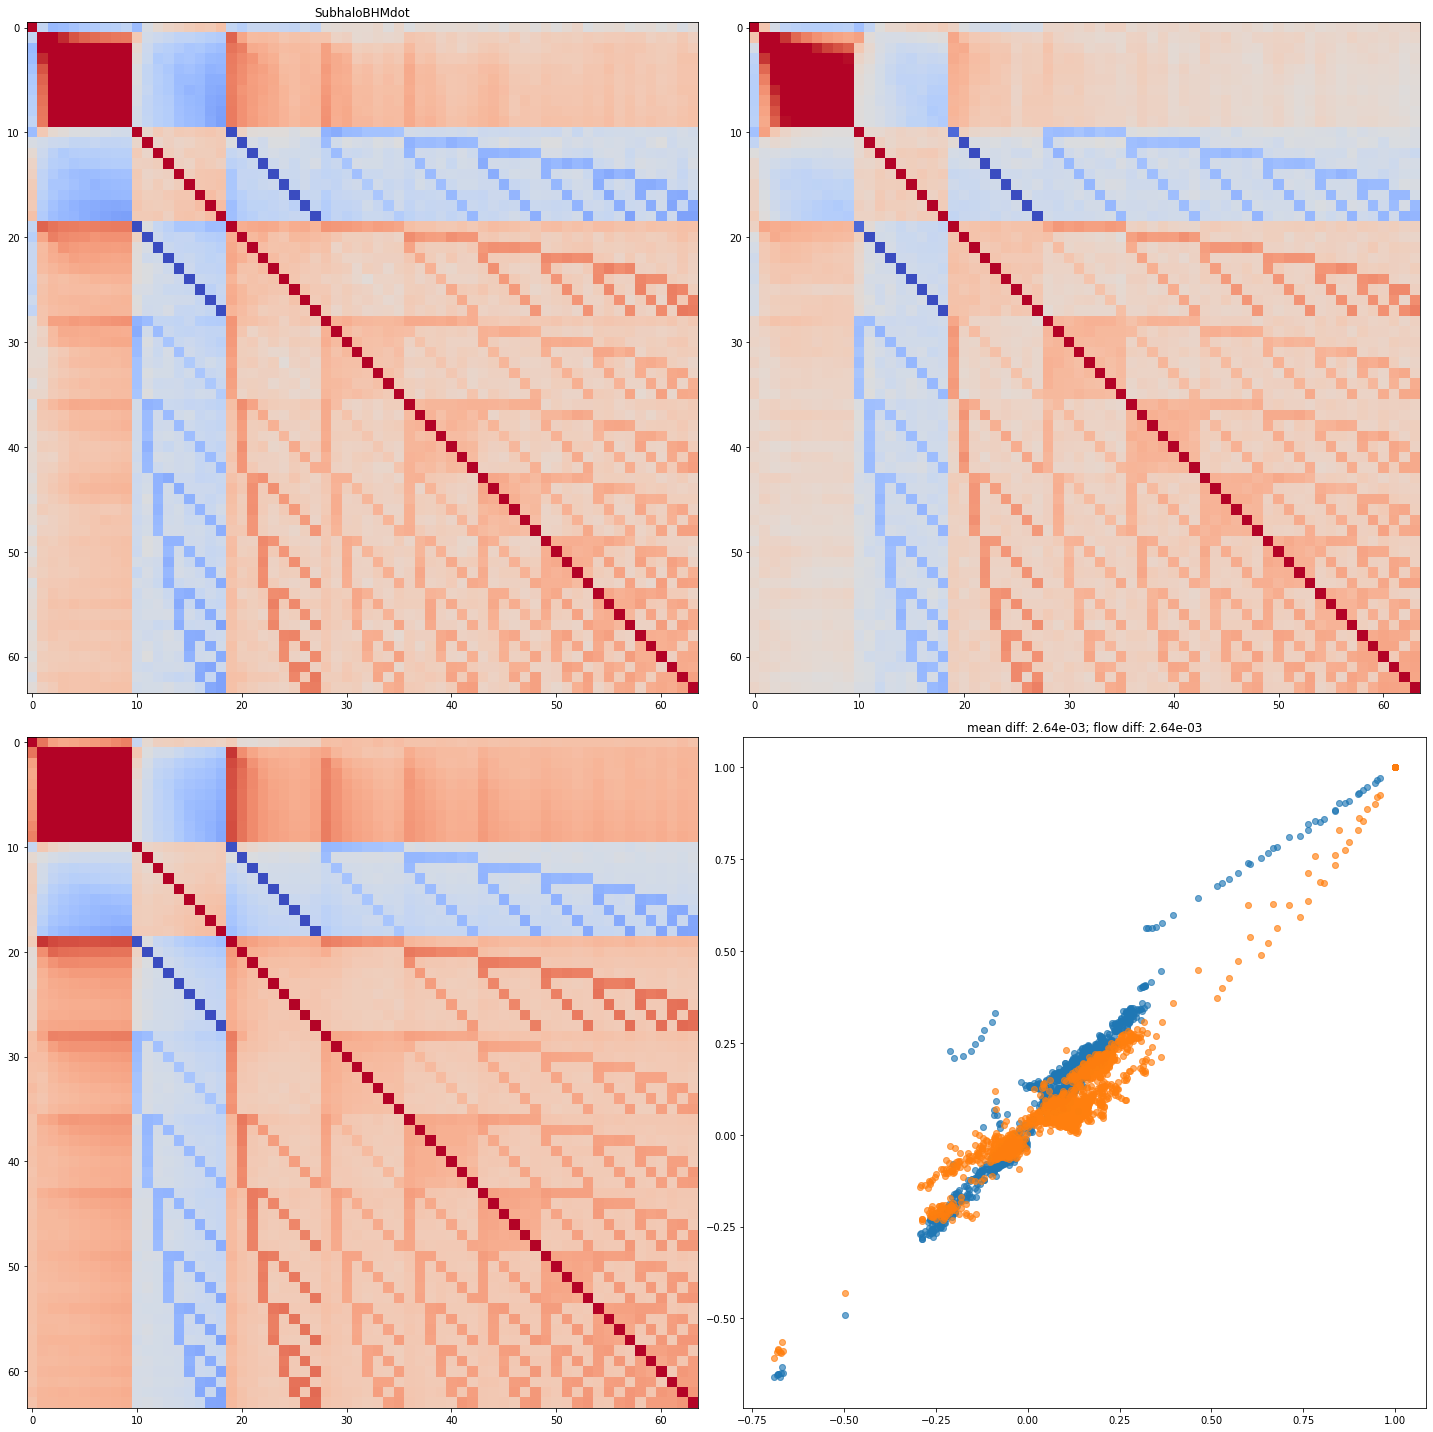

{'SubhaloBHMdot': [0.9, 1.0]}


<Figure size 432x288 with 0 Axes>

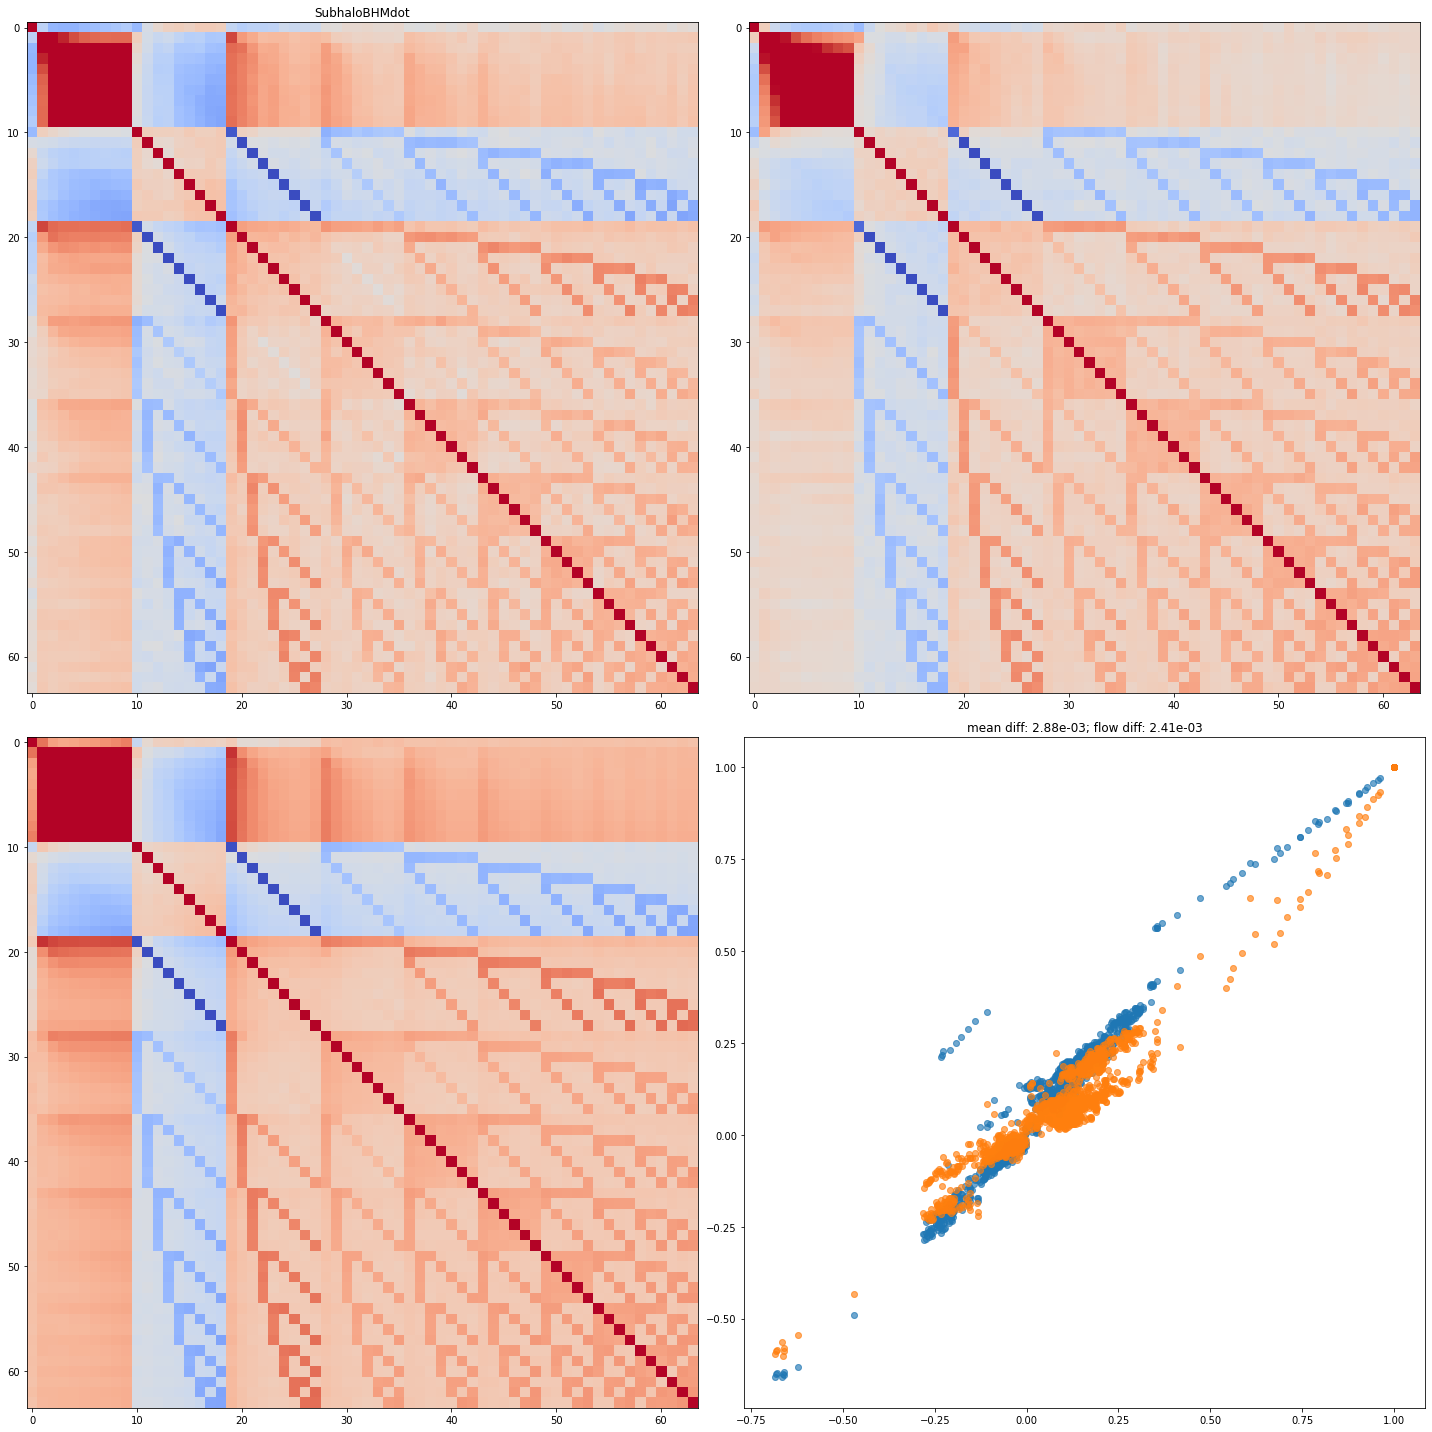

{'SubhaloGasMetallicity': [0.0, 0.1]}


<Figure size 432x288 with 0 Axes>

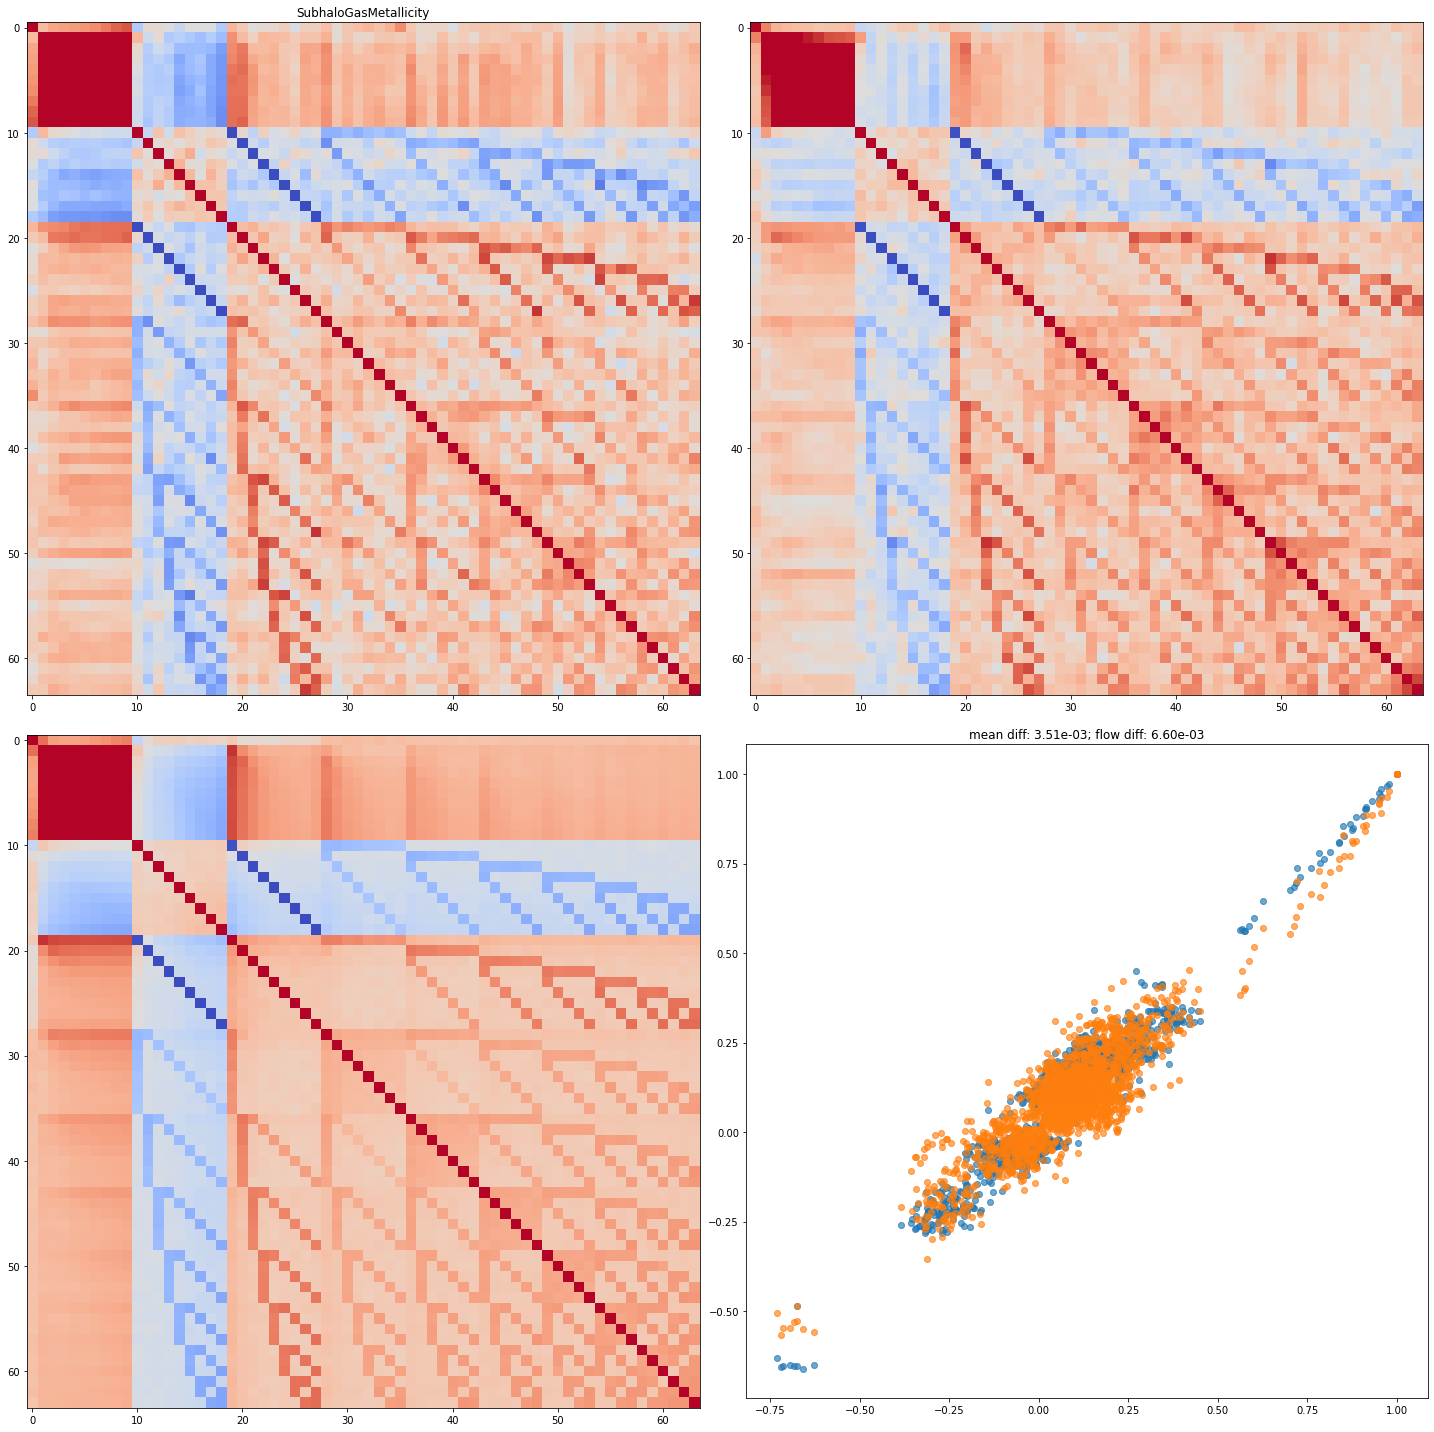

{'SubhaloGasMetallicity': [0.1, 0.2]}


<Figure size 432x288 with 0 Axes>

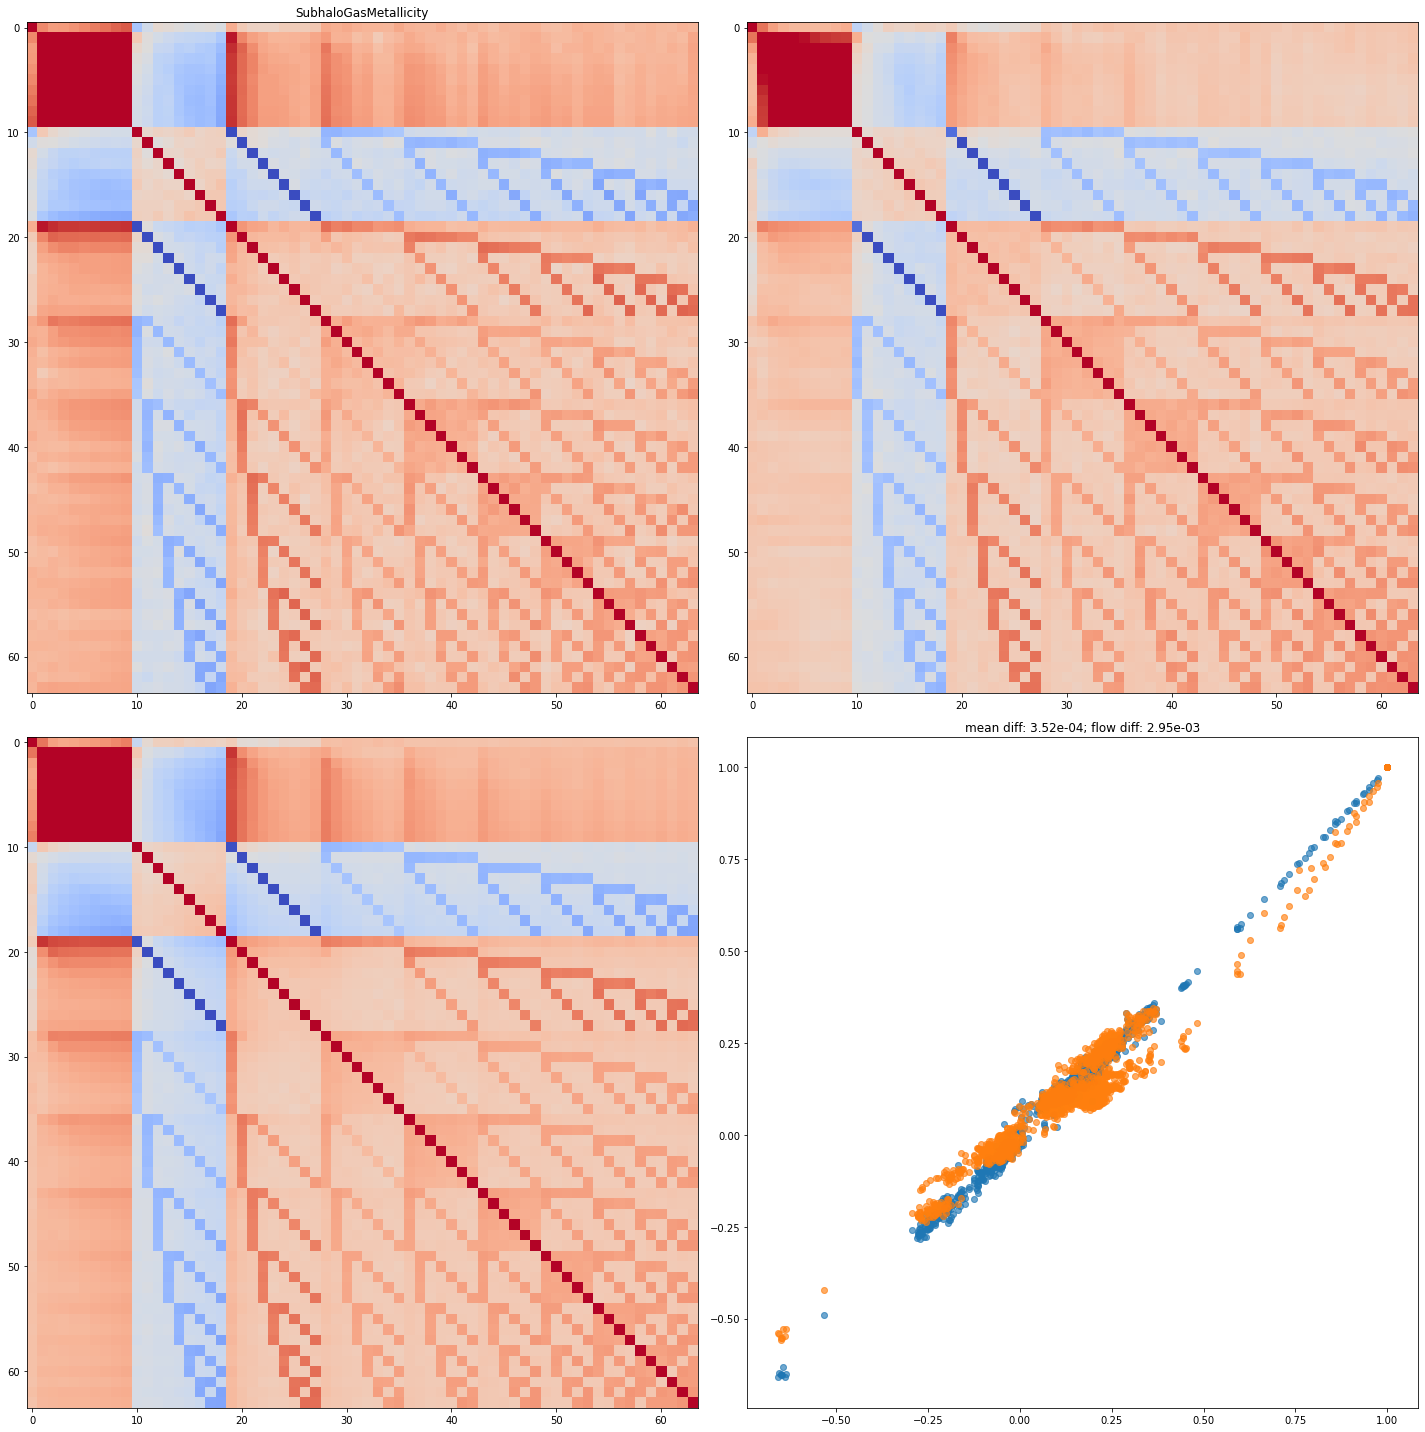

{'SubhaloGasMetallicity': [0.2, 0.30000000000000004]}


<Figure size 432x288 with 0 Axes>

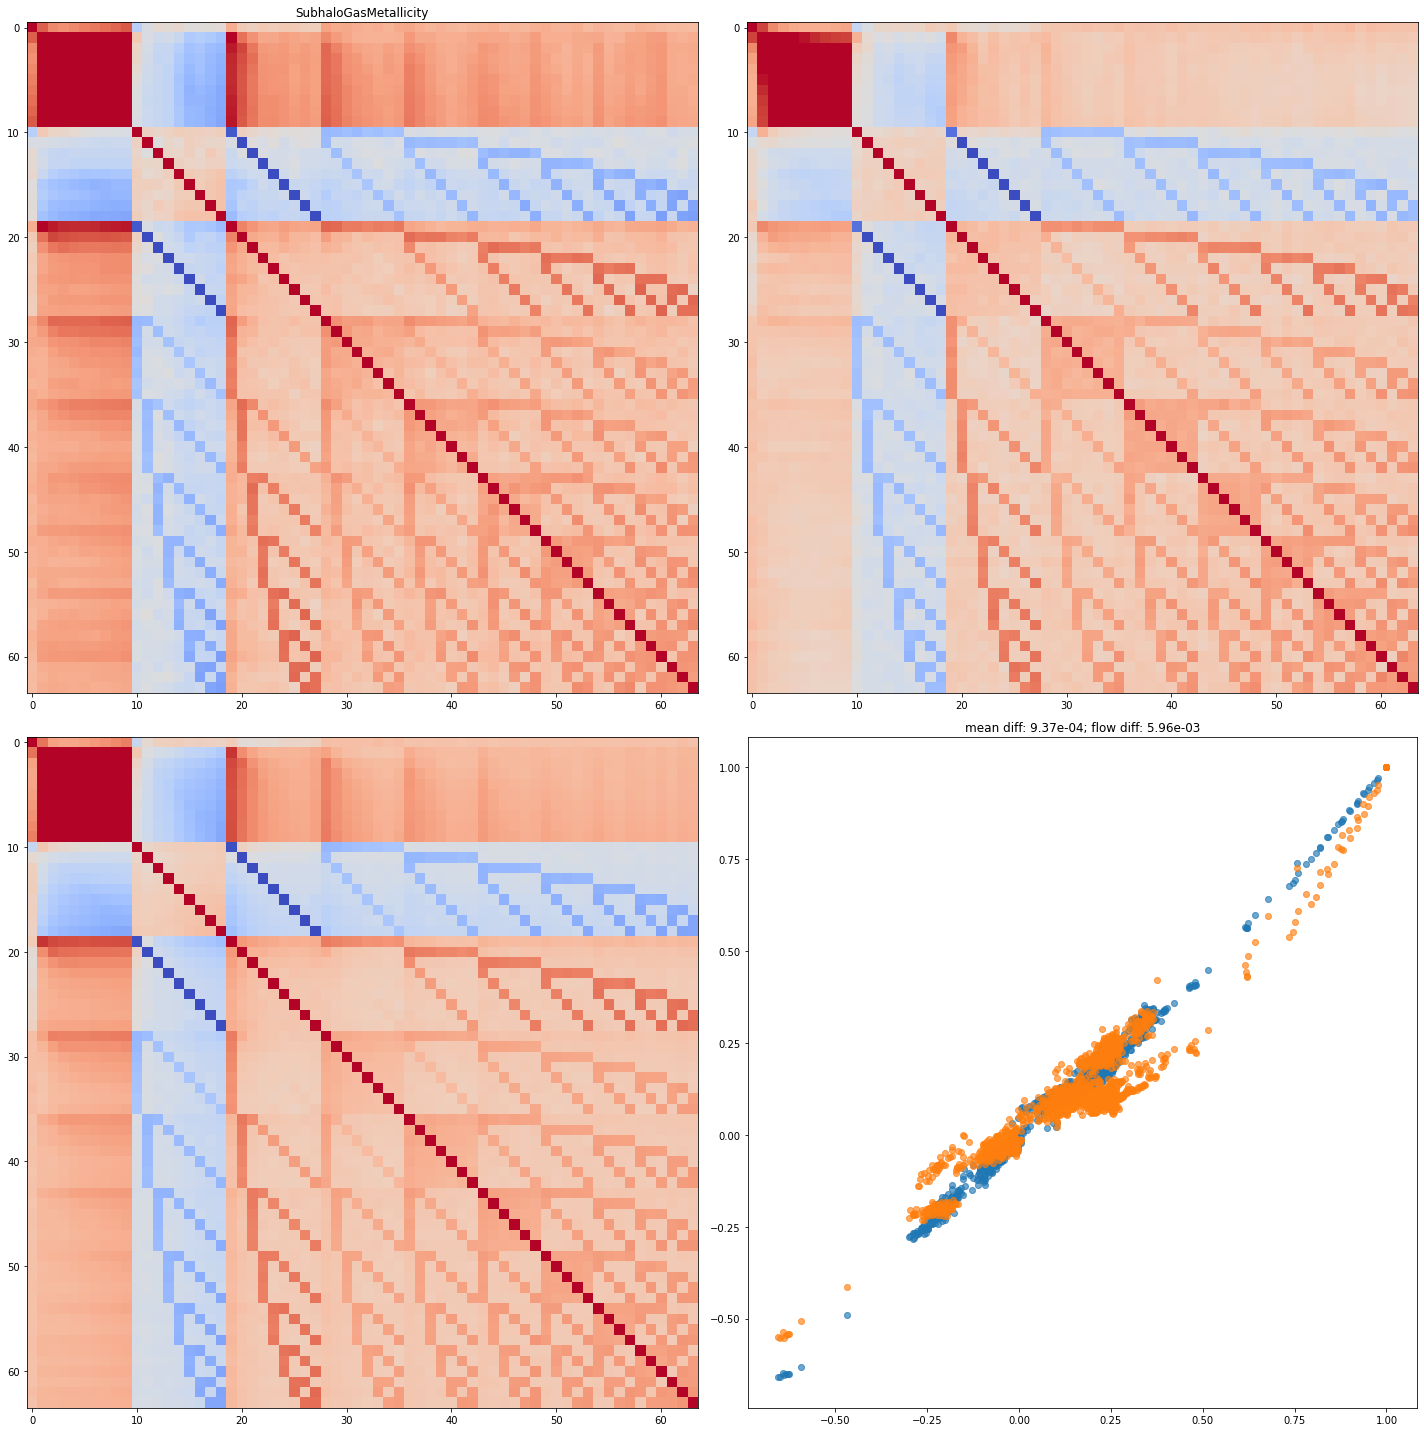

{'SubhaloGasMetallicity': [0.30000000000000004, 0.4]}


<Figure size 432x288 with 0 Axes>

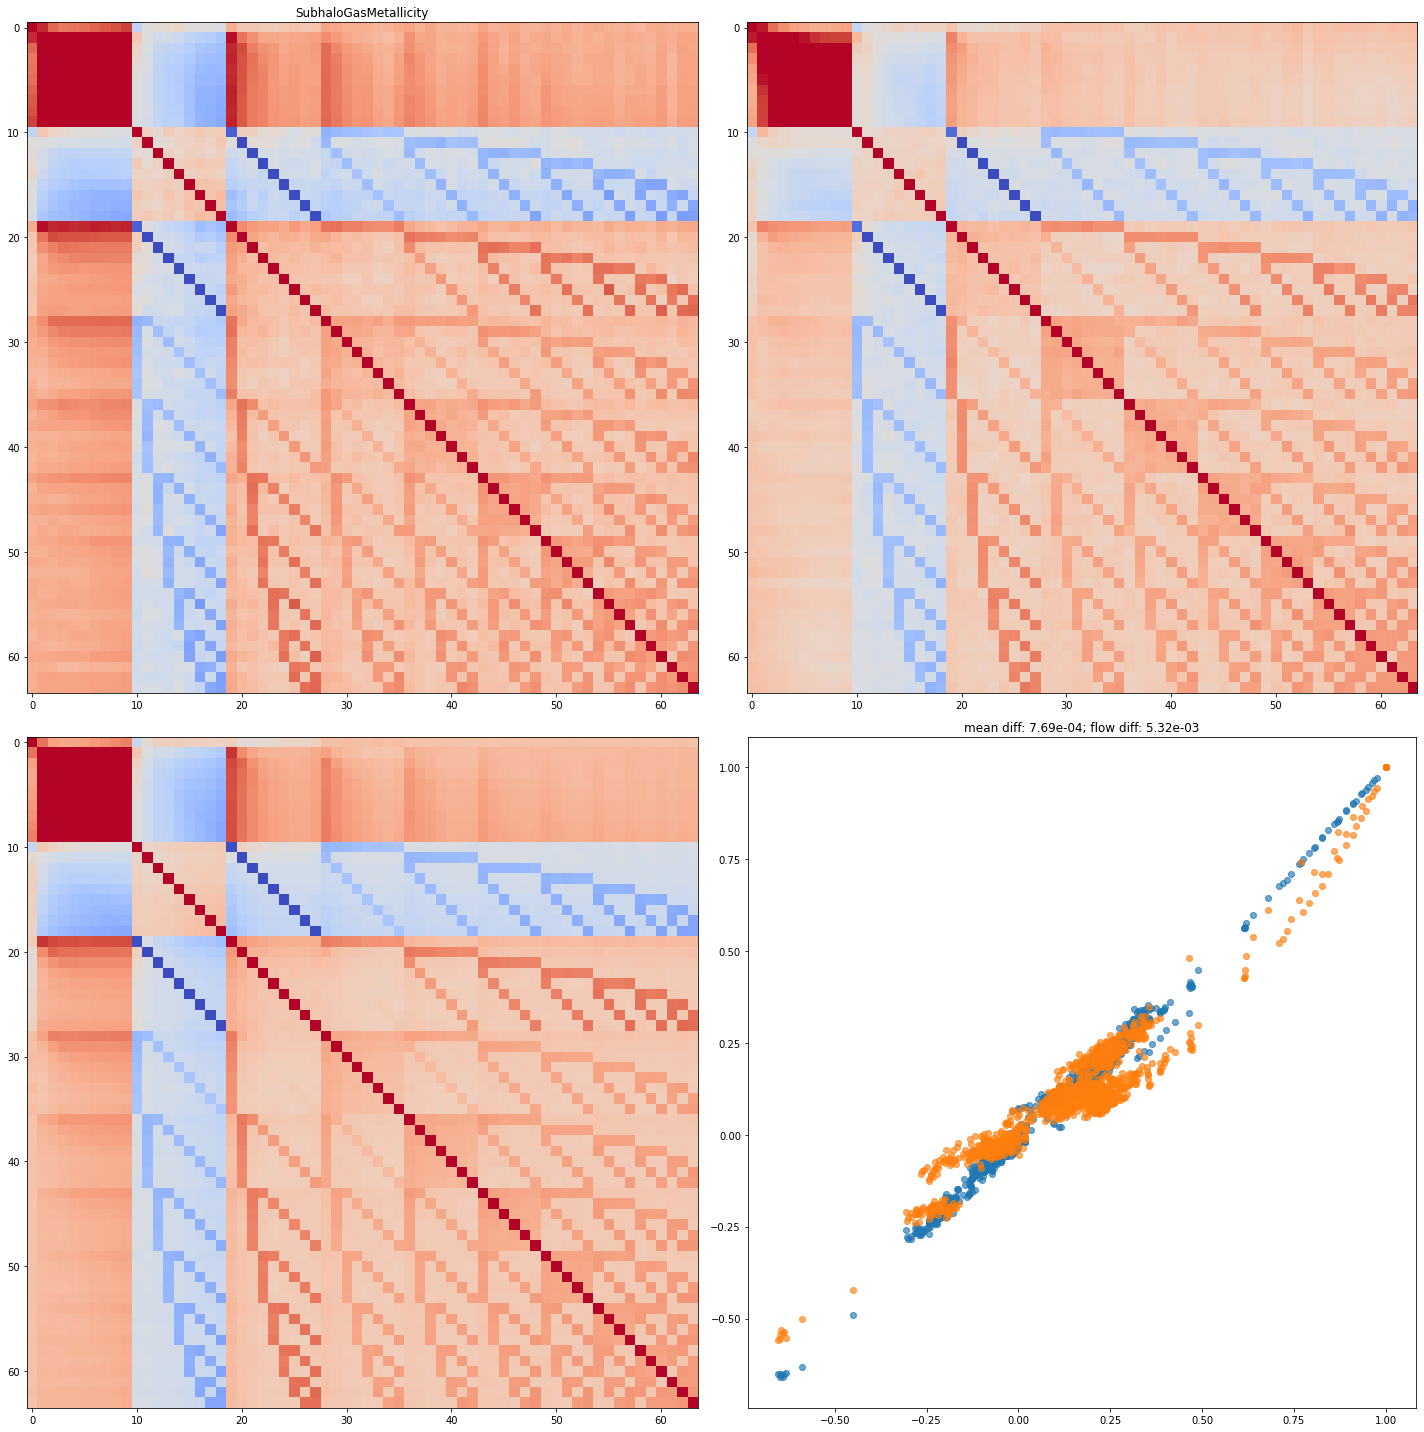

{'SubhaloGasMetallicity': [0.4, 0.5]}


<Figure size 432x288 with 0 Axes>

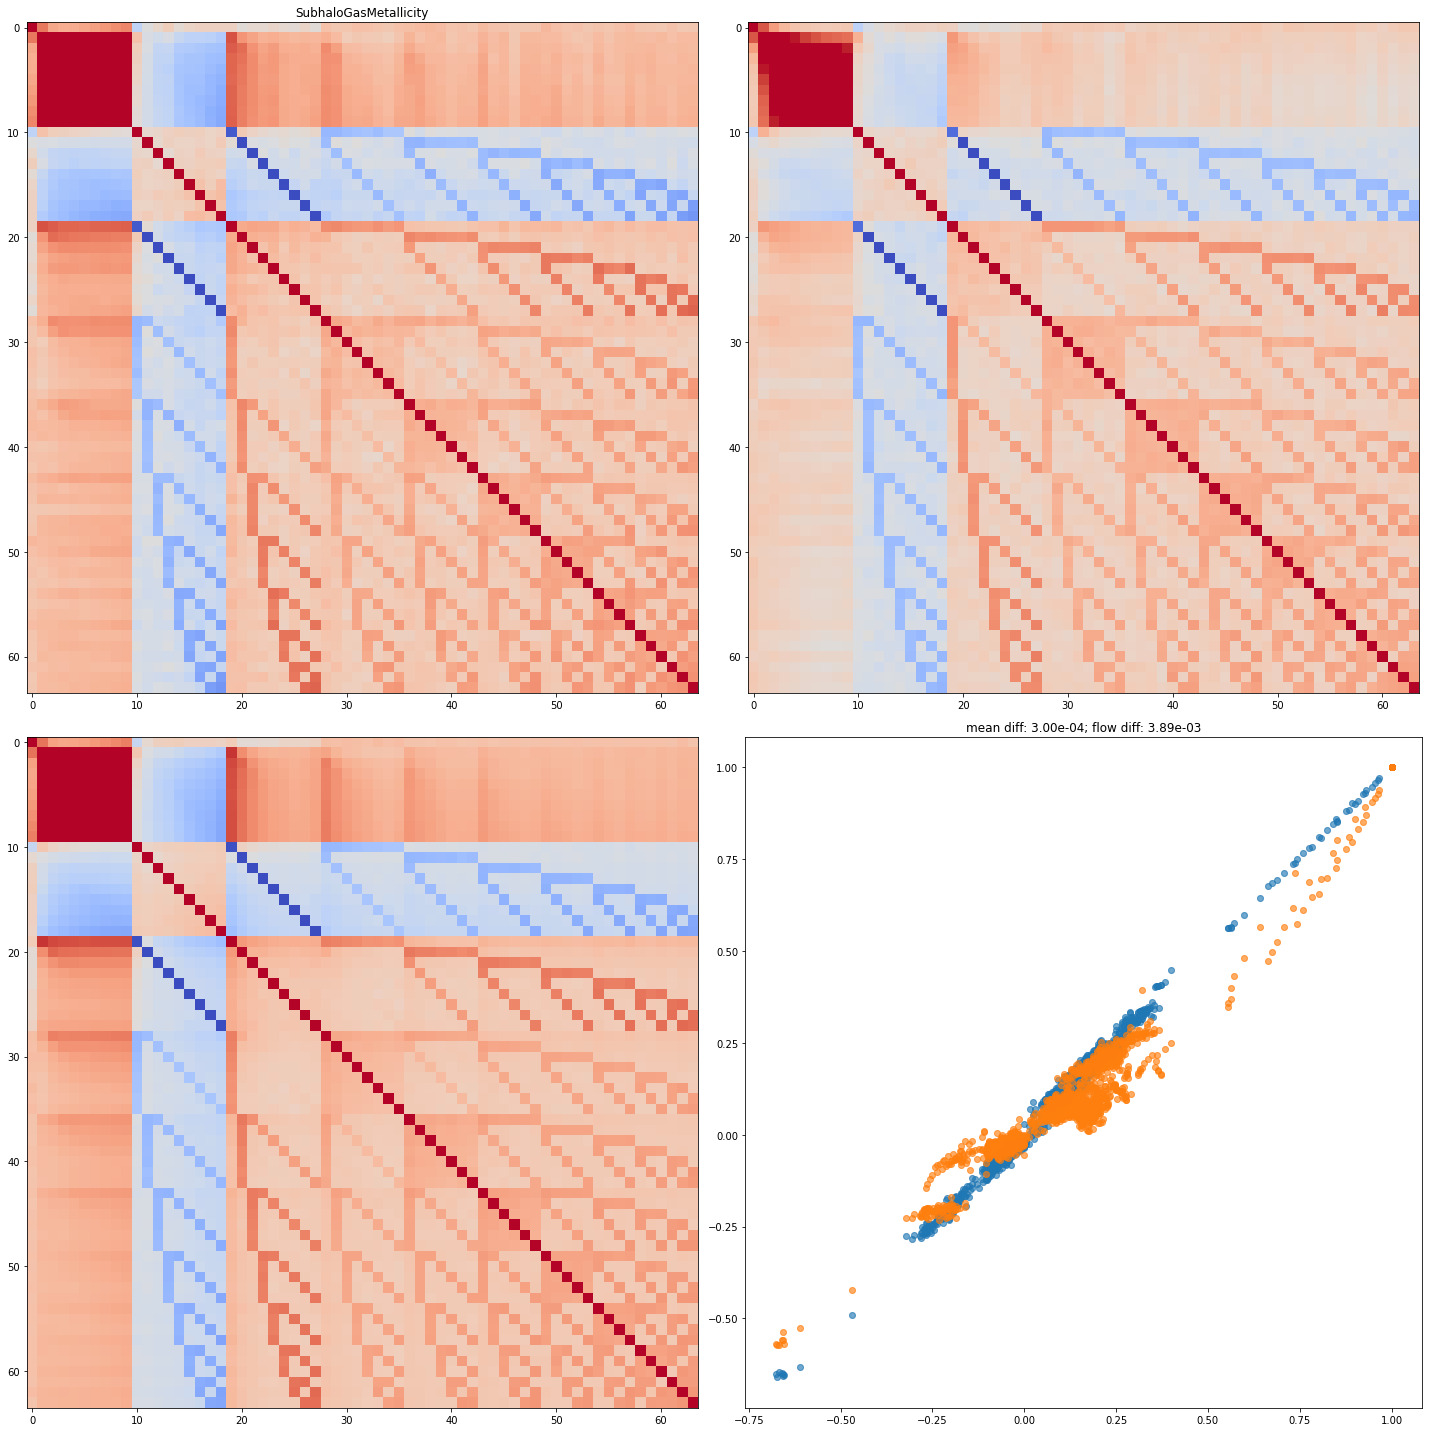

{'SubhaloGasMetallicity': [0.5, 0.6000000000000001]}


<Figure size 432x288 with 0 Axes>

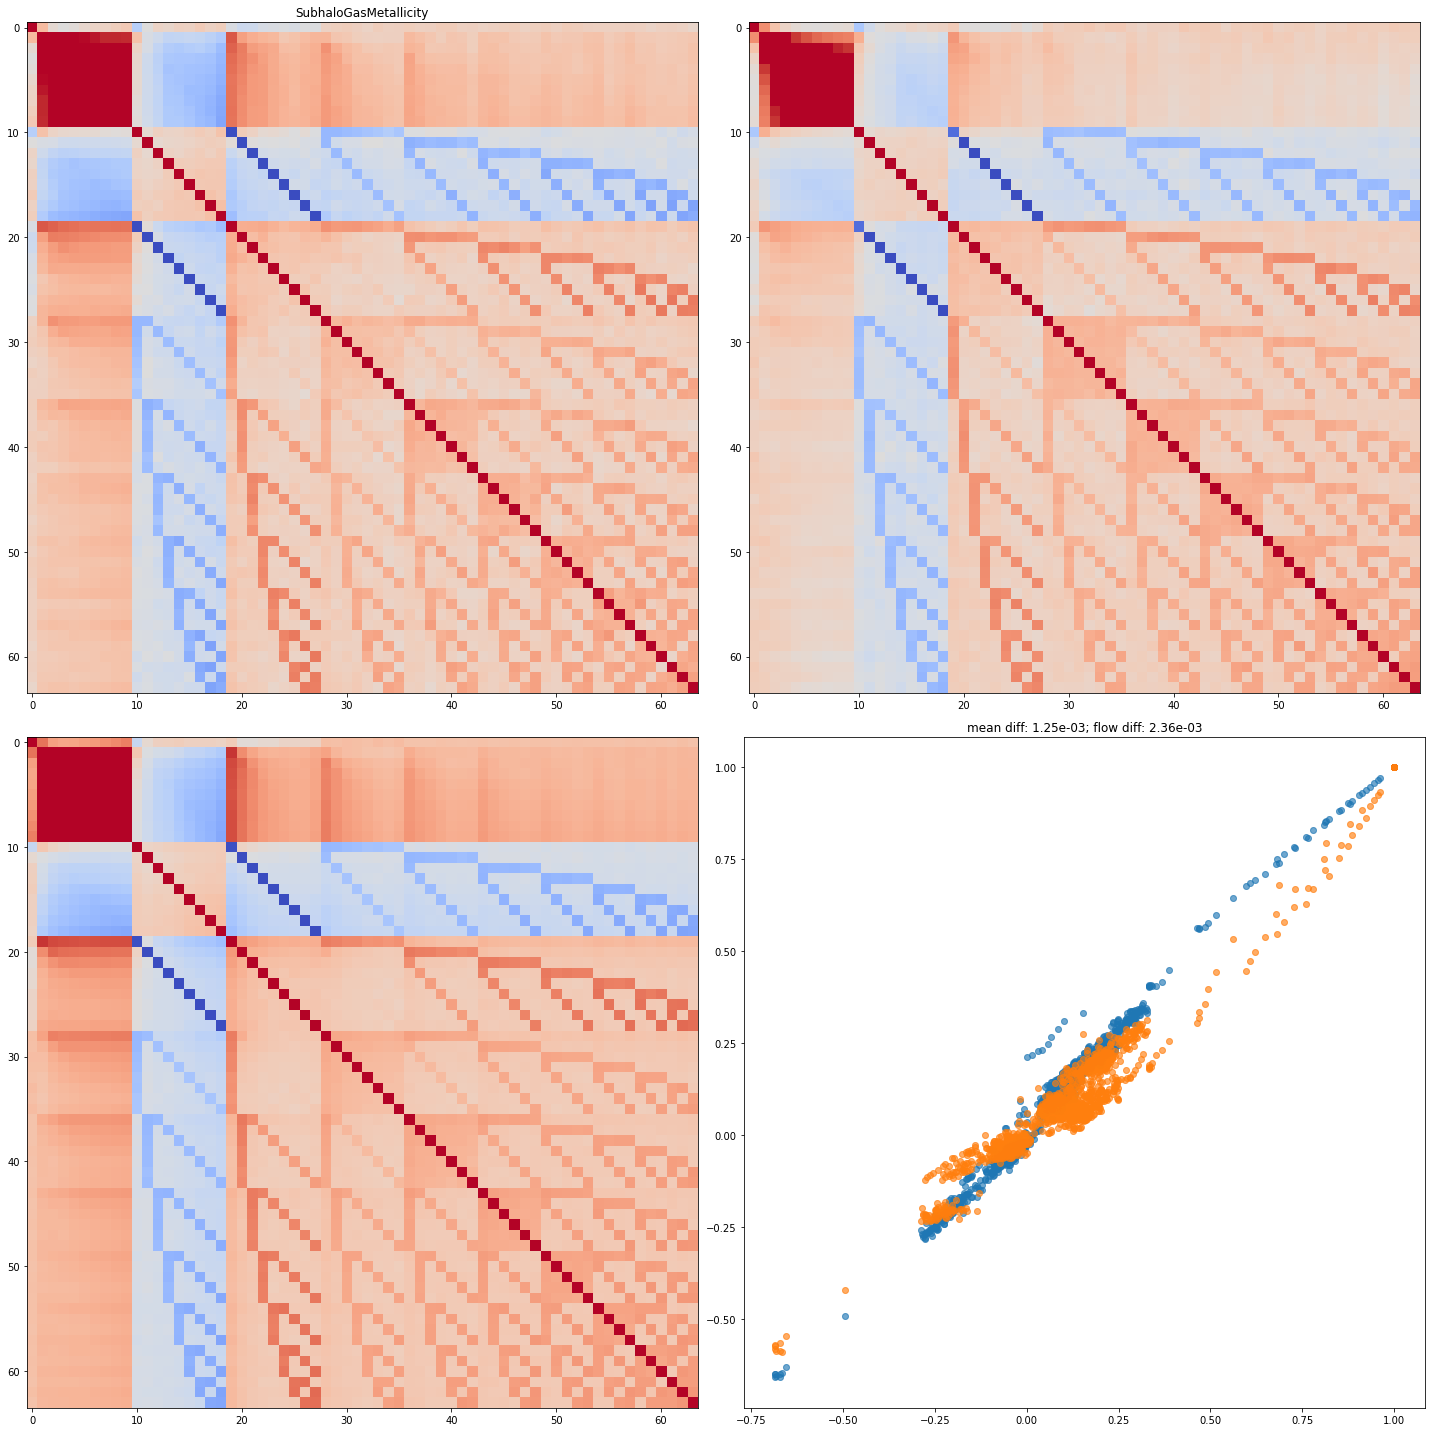

{'SubhaloGasMetallicity': [0.6000000000000001, 0.7000000000000001]}


<Figure size 432x288 with 0 Axes>

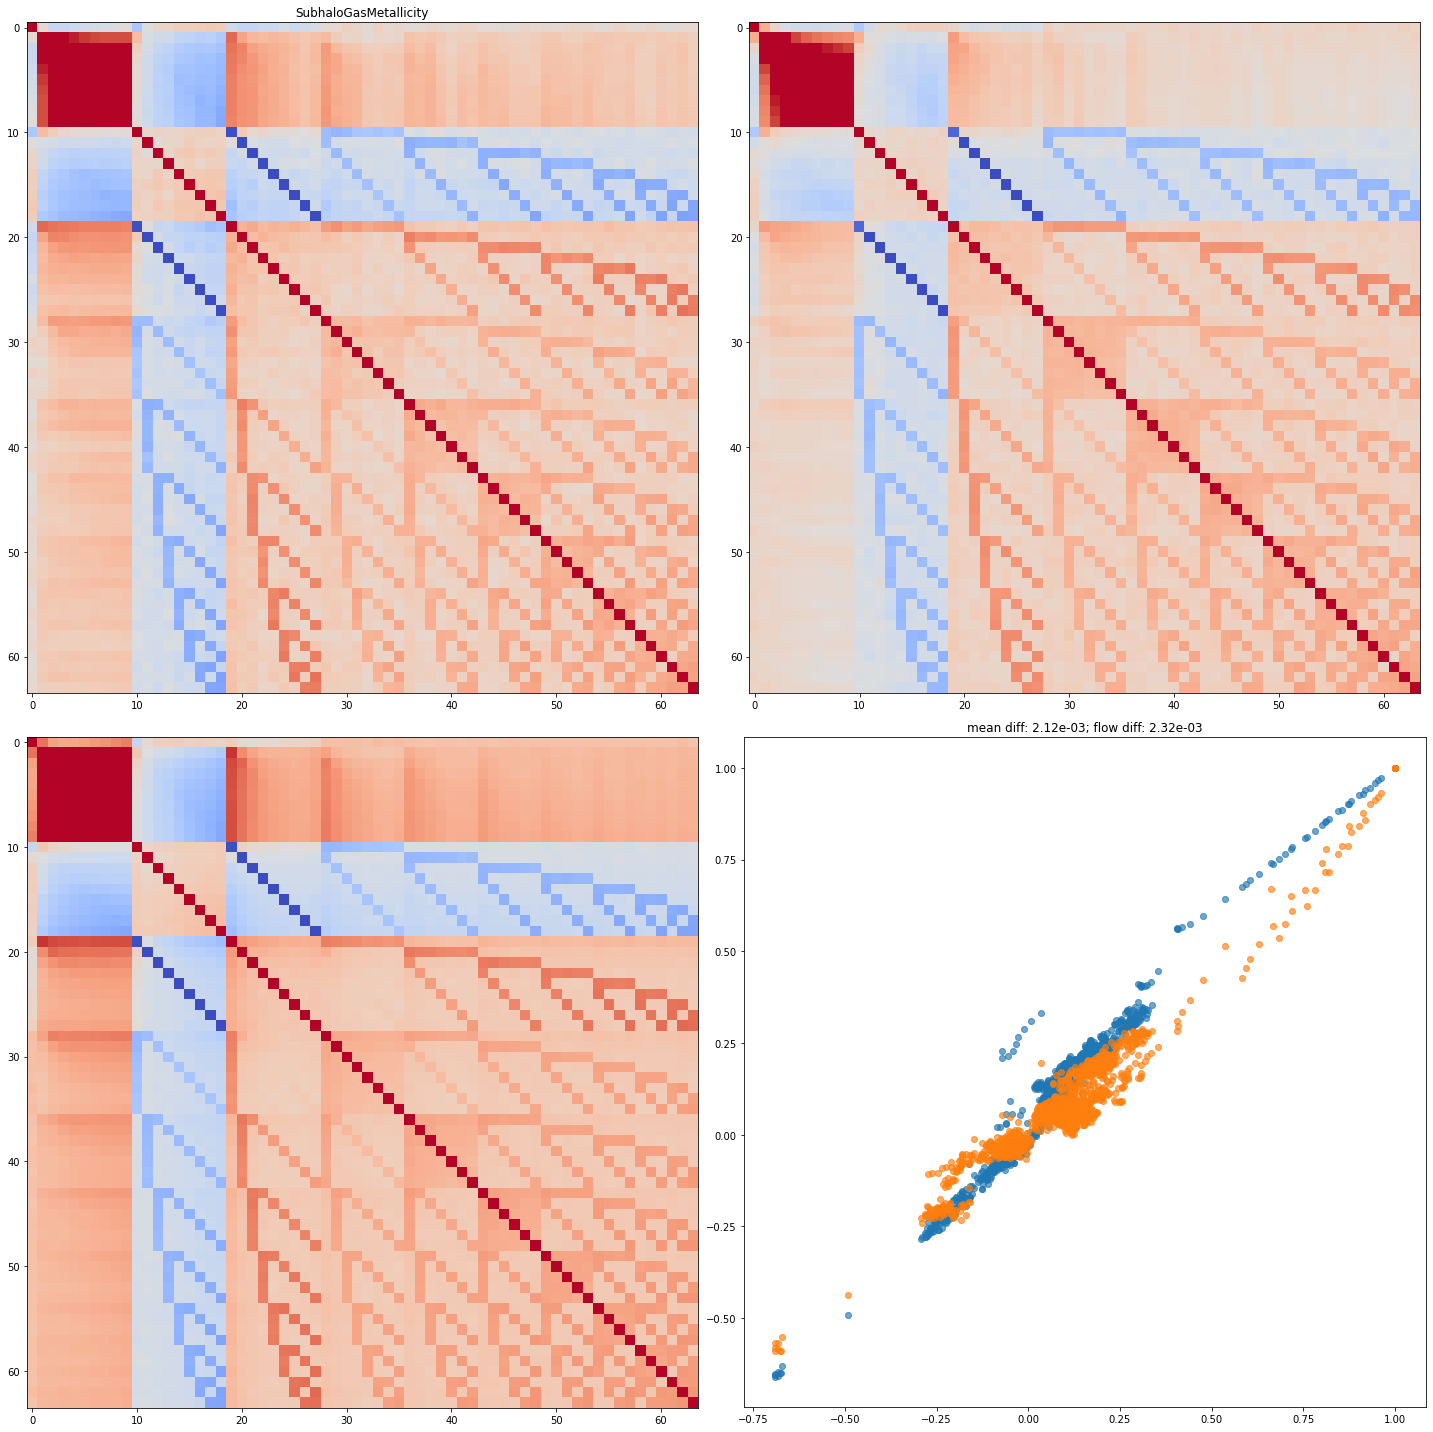

{'SubhaloGasMetallicity': [0.7000000000000001, 0.8]}


<Figure size 432x288 with 0 Axes>

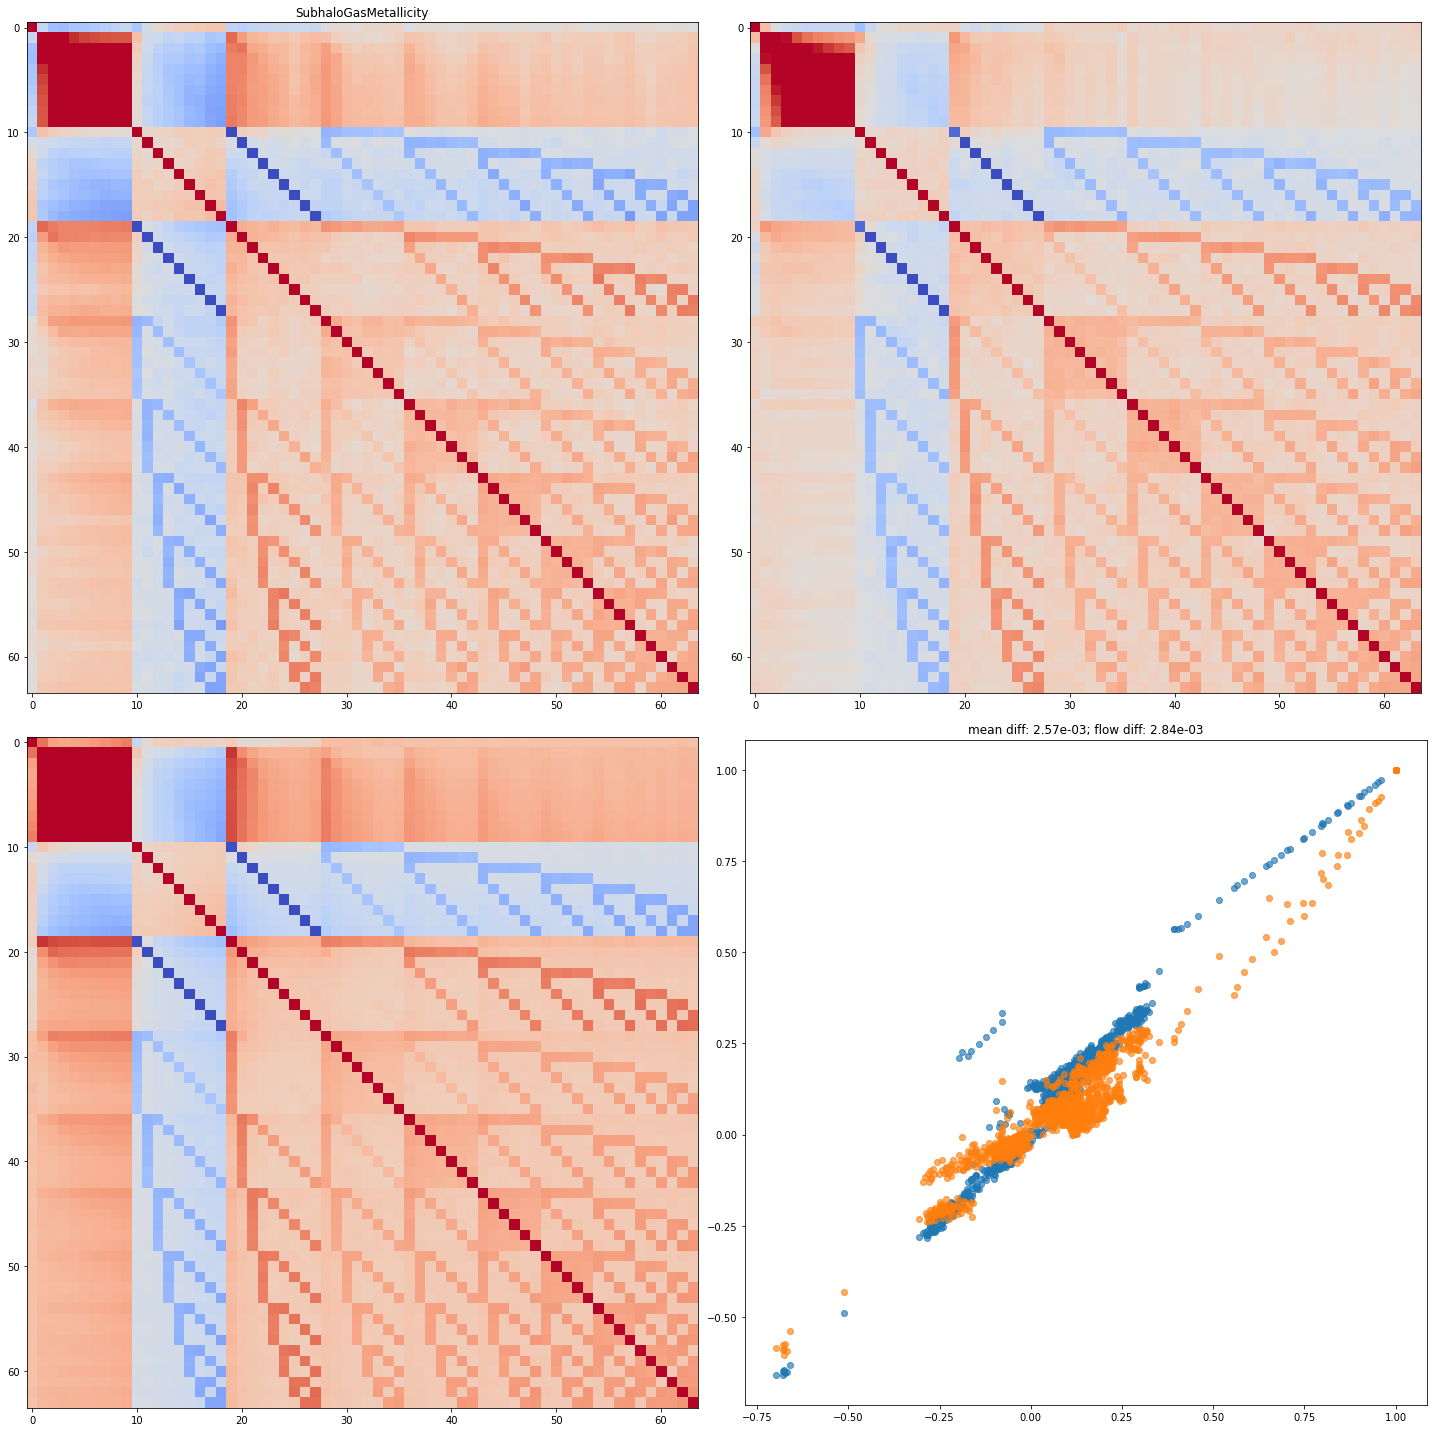

{'SubhaloGasMetallicity': [0.8, 0.9]}


<Figure size 432x288 with 0 Axes>

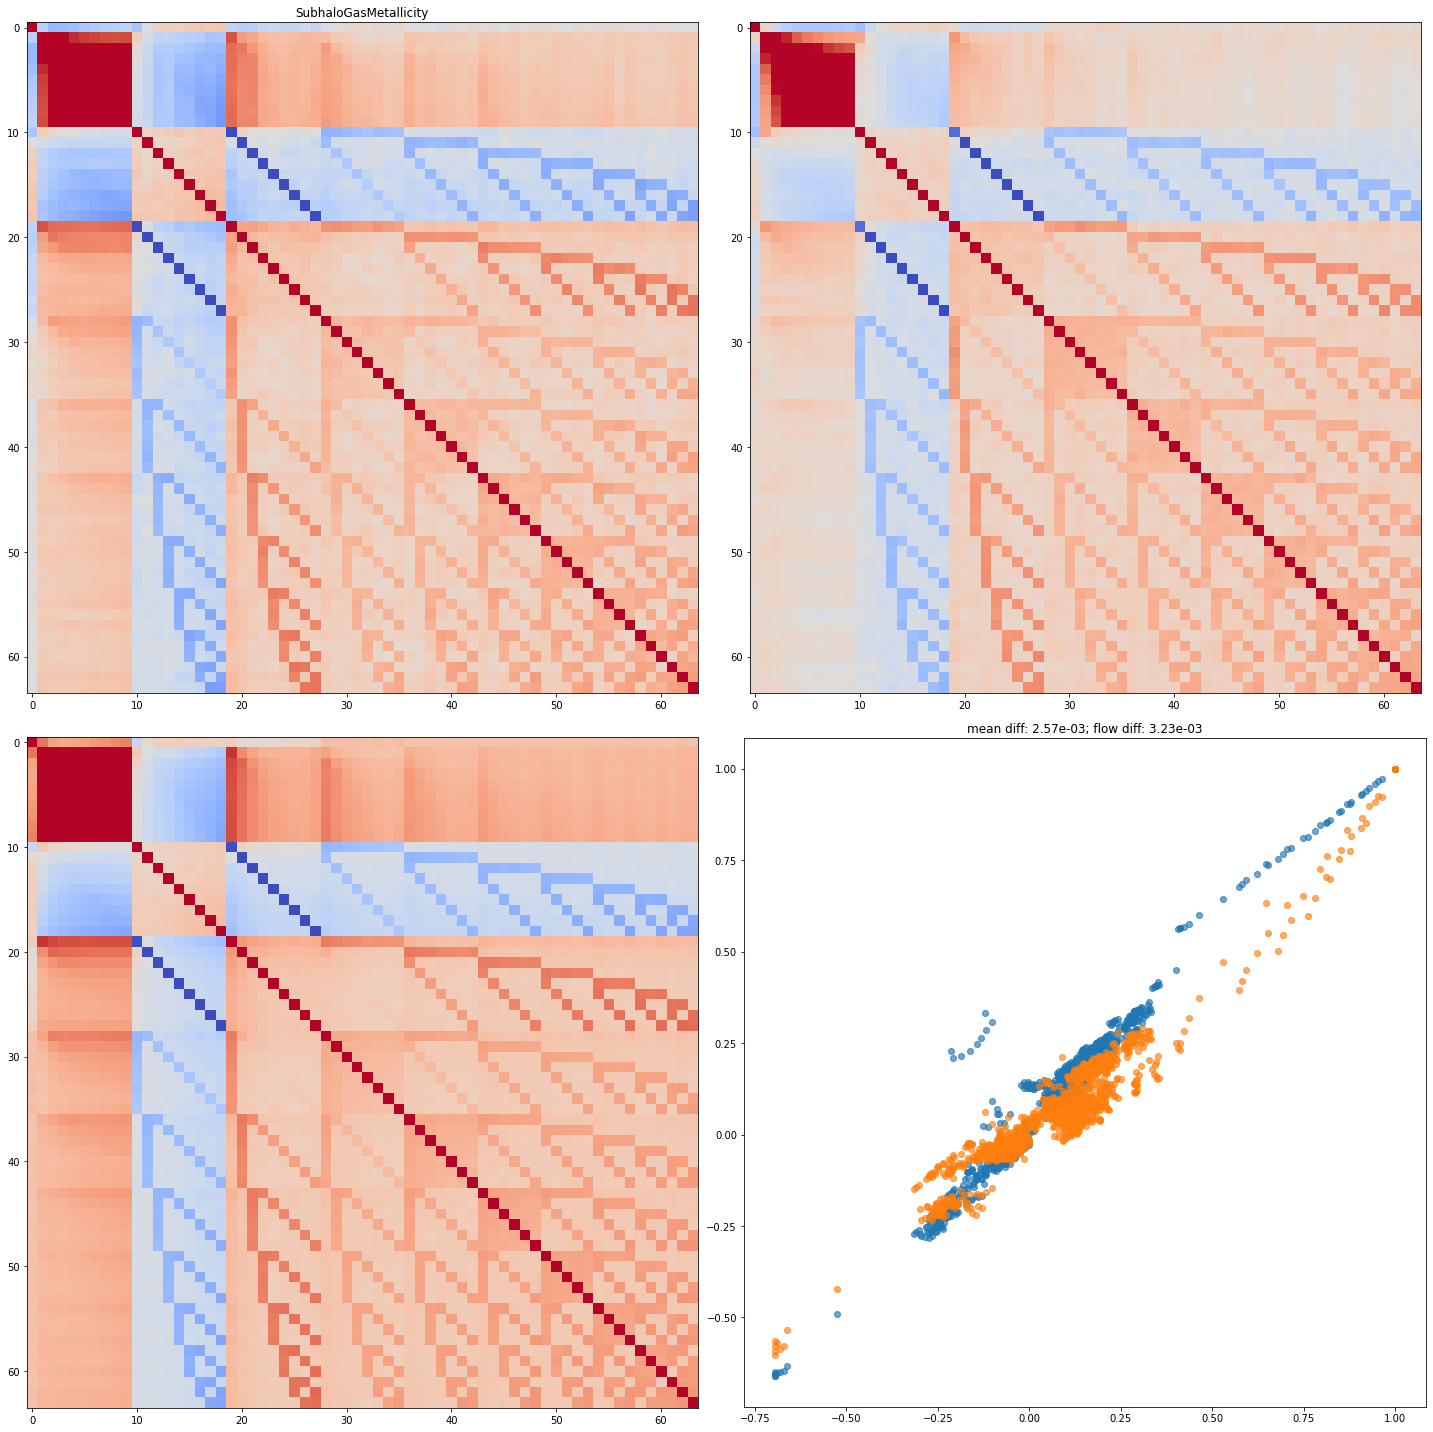

{'SubhaloGasMetallicity': [0.9, 1.0]}


<Figure size 432x288 with 0 Axes>

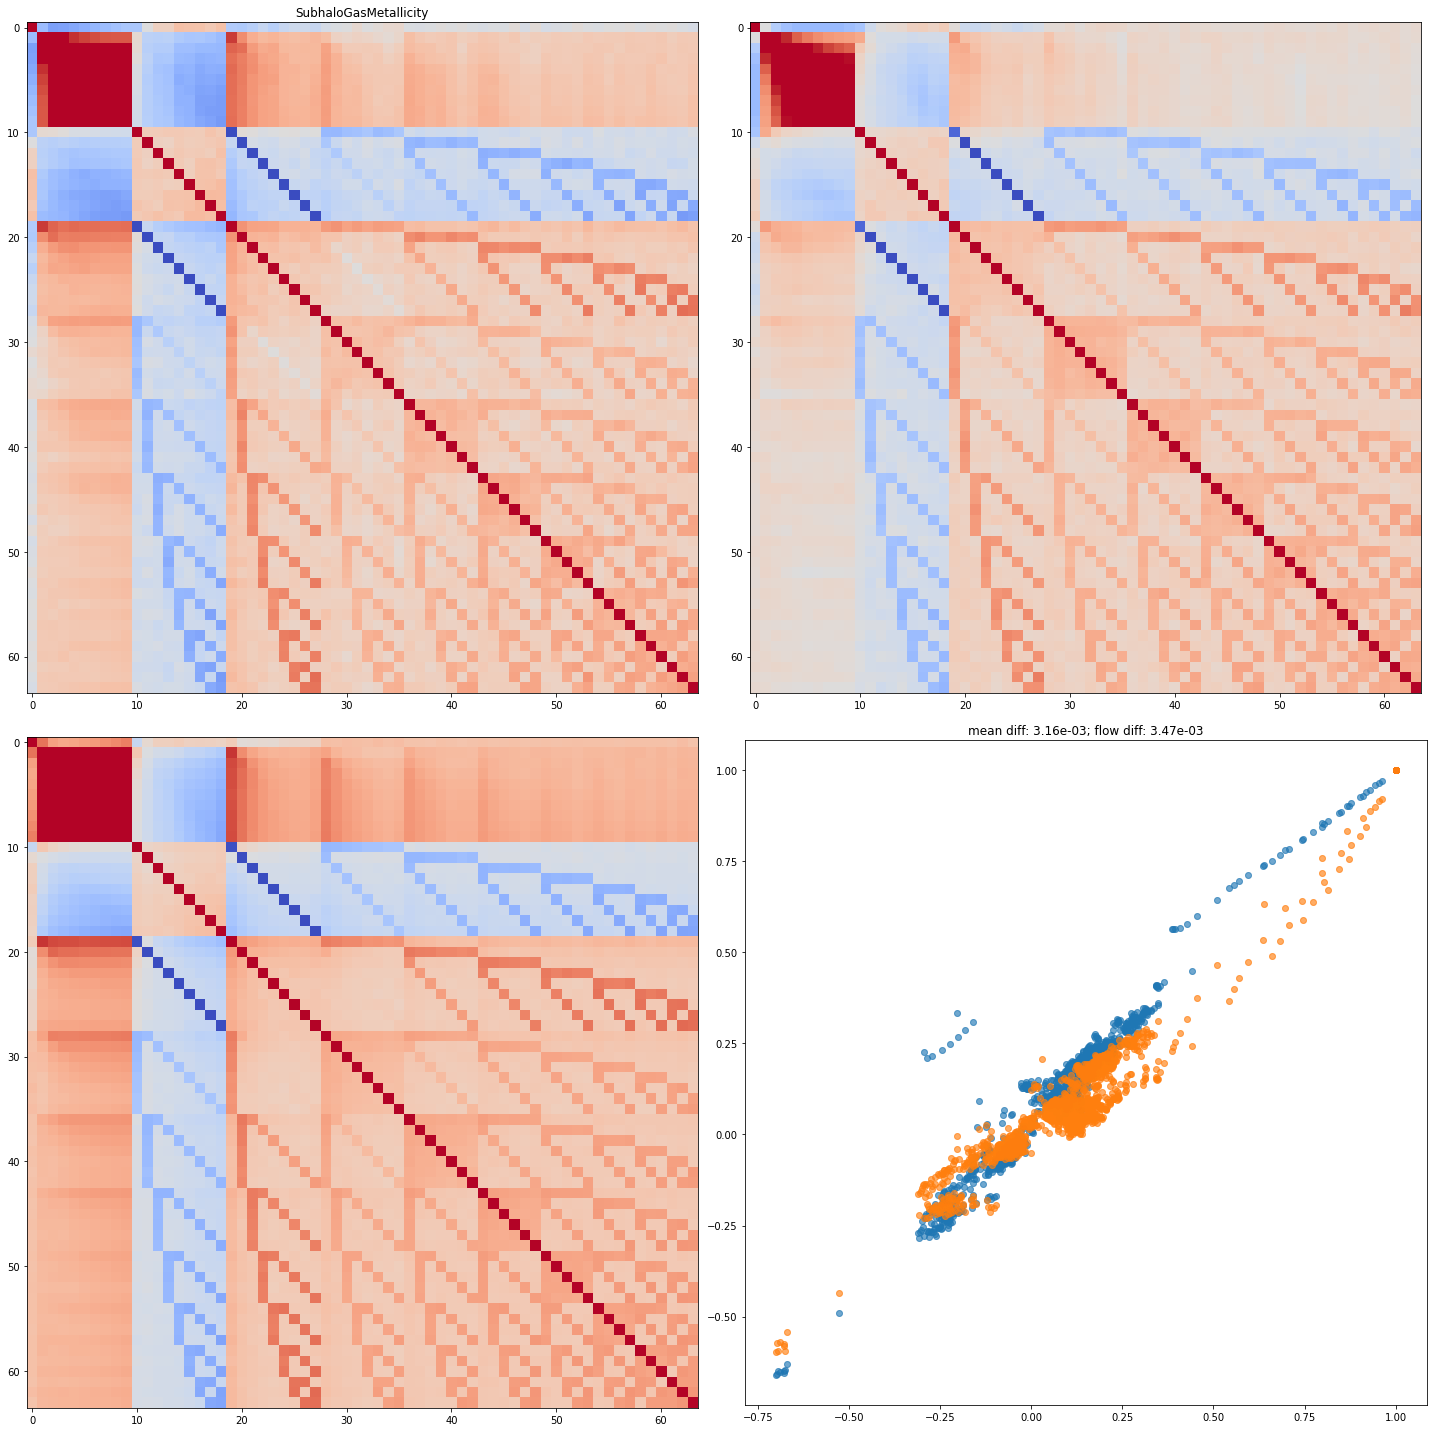

{'SubhaloStarMetallicity': [0.0, 0.1]}


<Figure size 432x288 with 0 Axes>

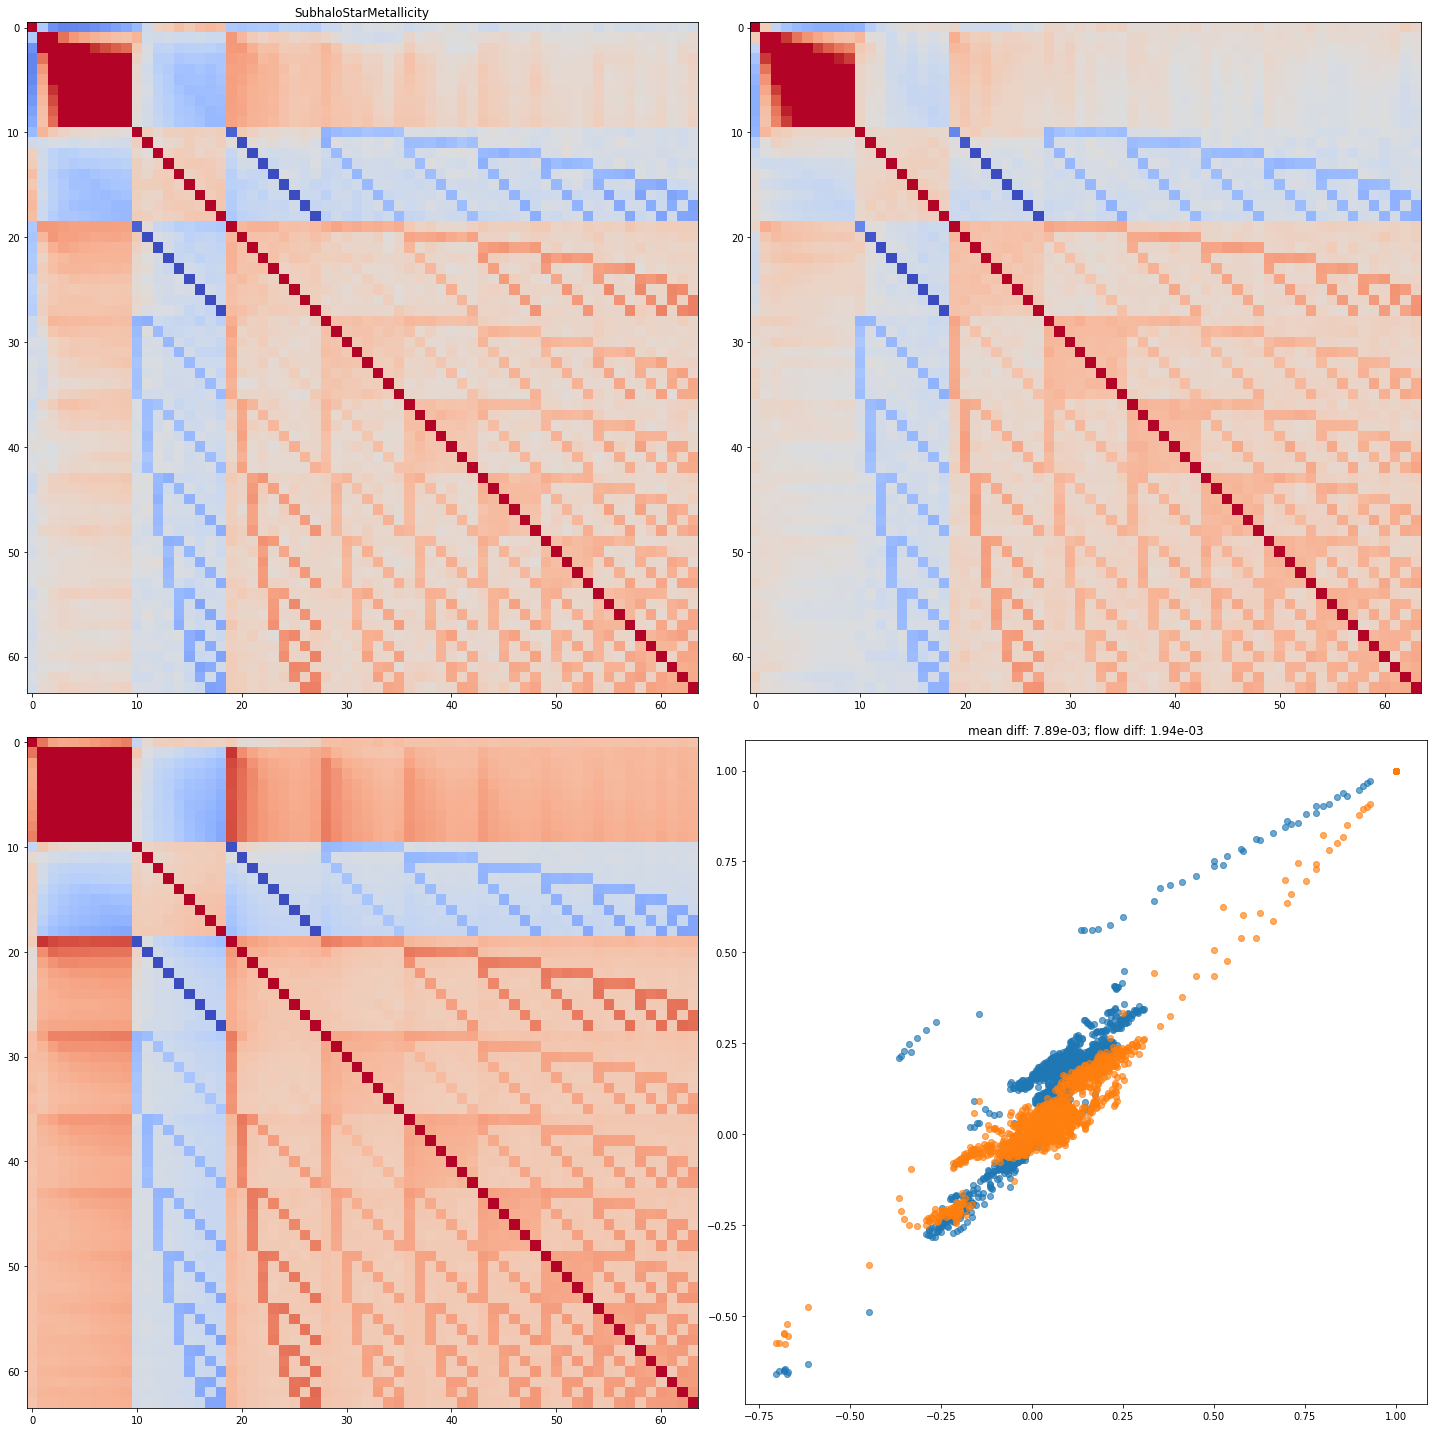

{'SubhaloStarMetallicity': [0.1, 0.2]}


<Figure size 432x288 with 0 Axes>

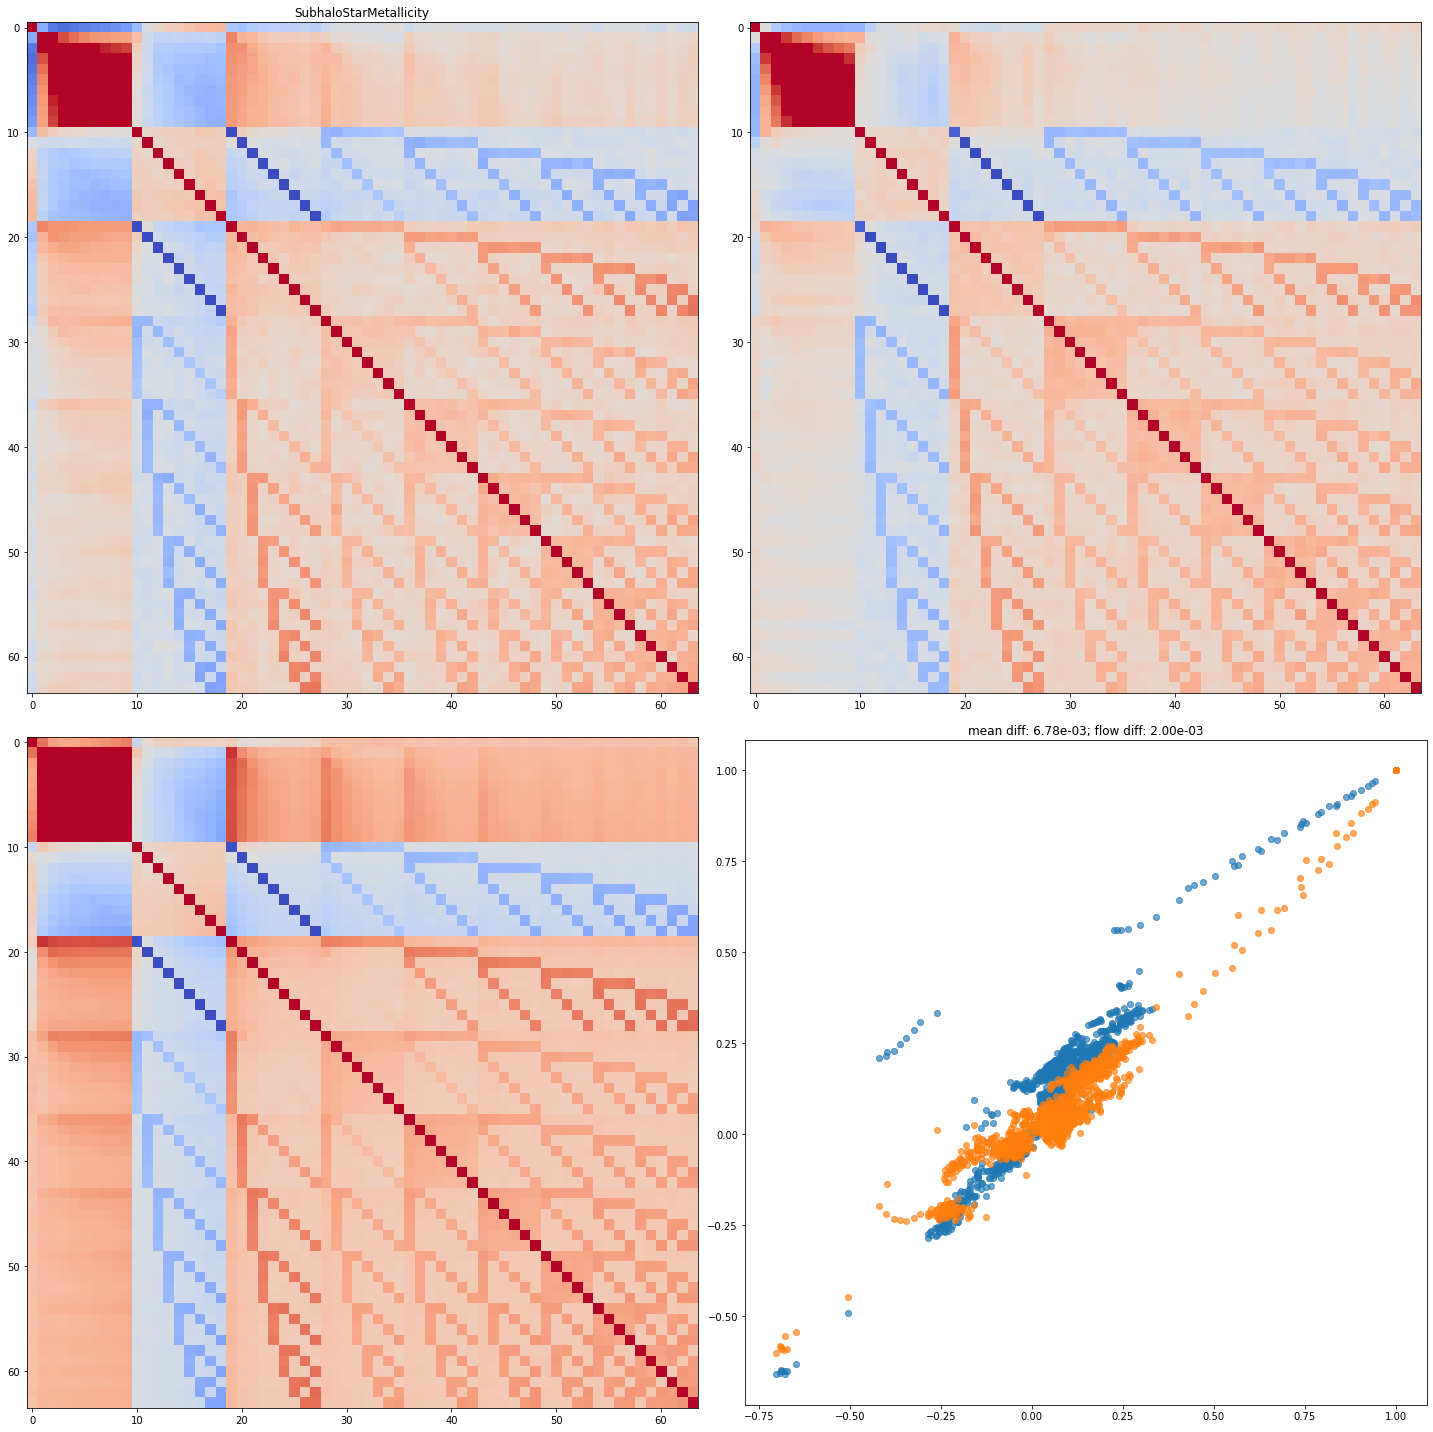

{'SubhaloStarMetallicity': [0.2, 0.30000000000000004]}


<Figure size 432x288 with 0 Axes>

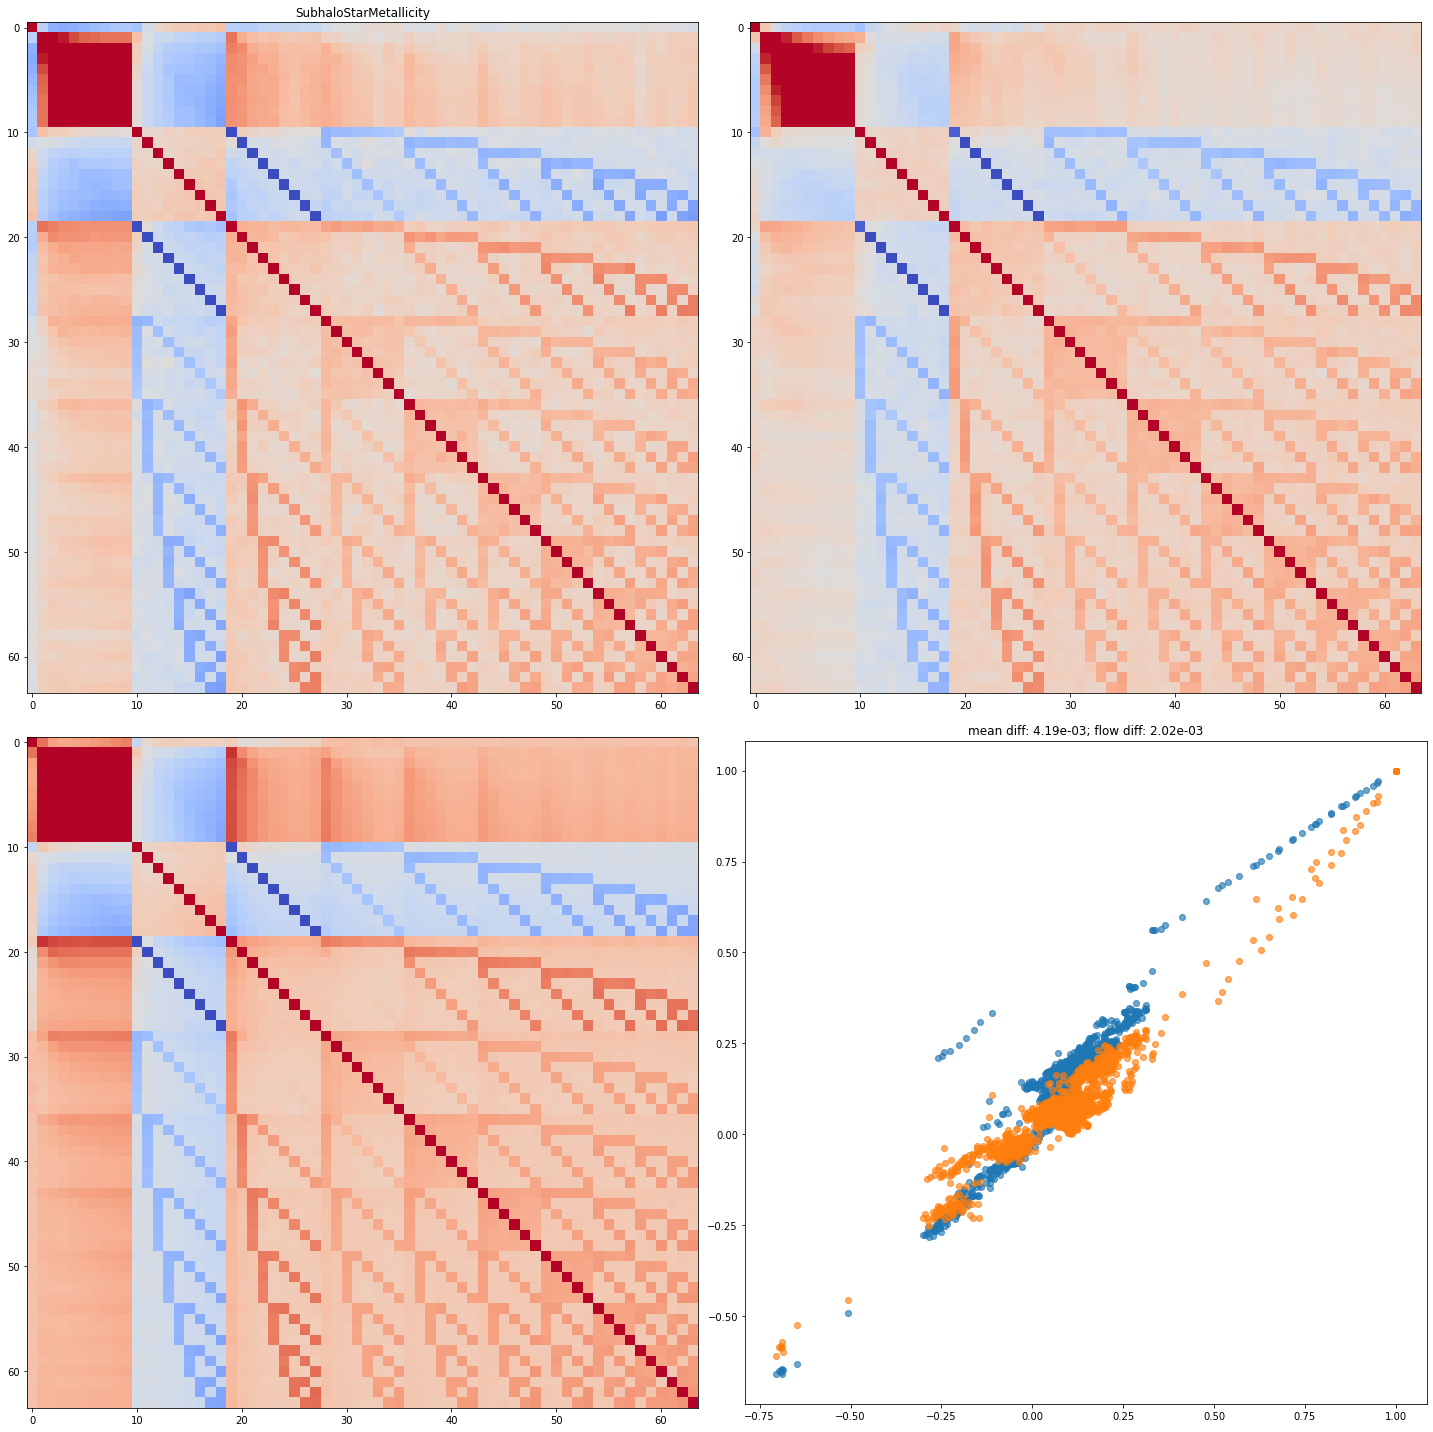

{'SubhaloStarMetallicity': [0.30000000000000004, 0.4]}


<Figure size 432x288 with 0 Axes>

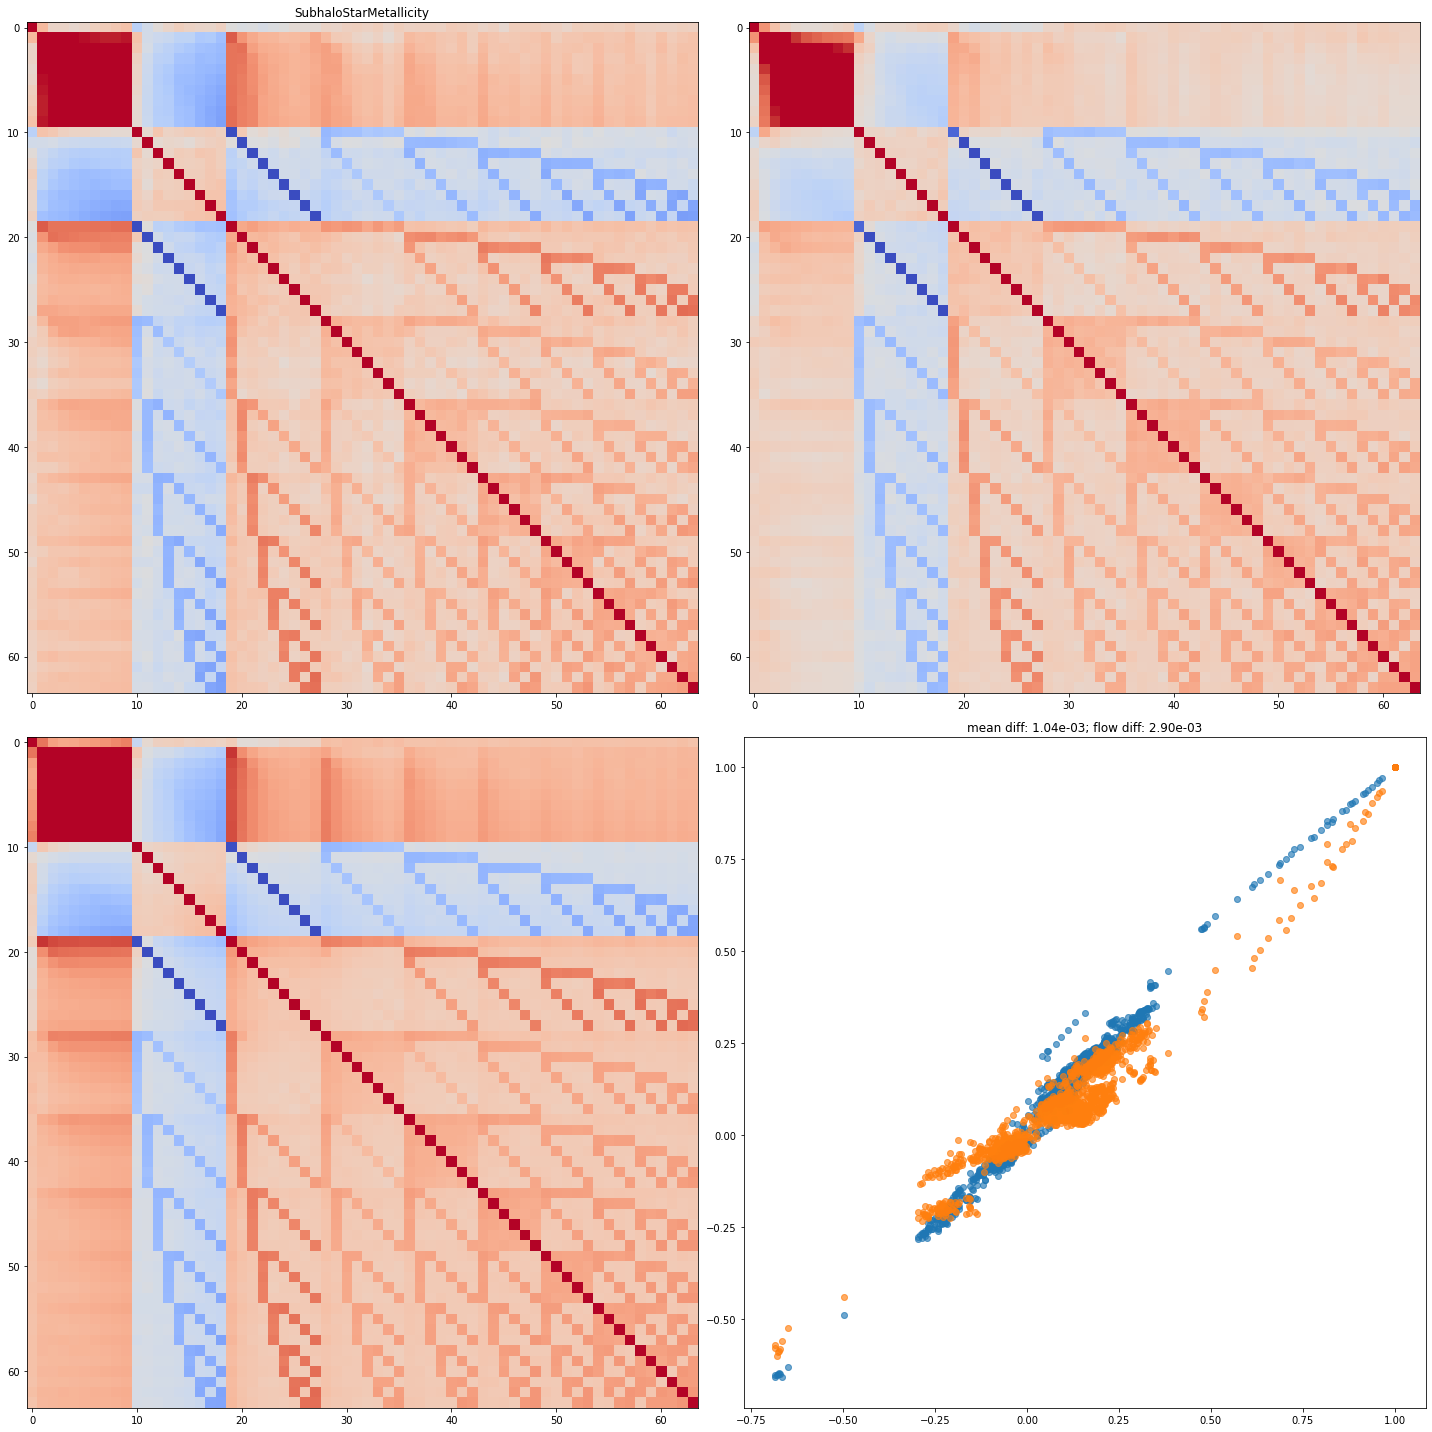

{'SubhaloStarMetallicity': [0.4, 0.5]}


<Figure size 432x288 with 0 Axes>

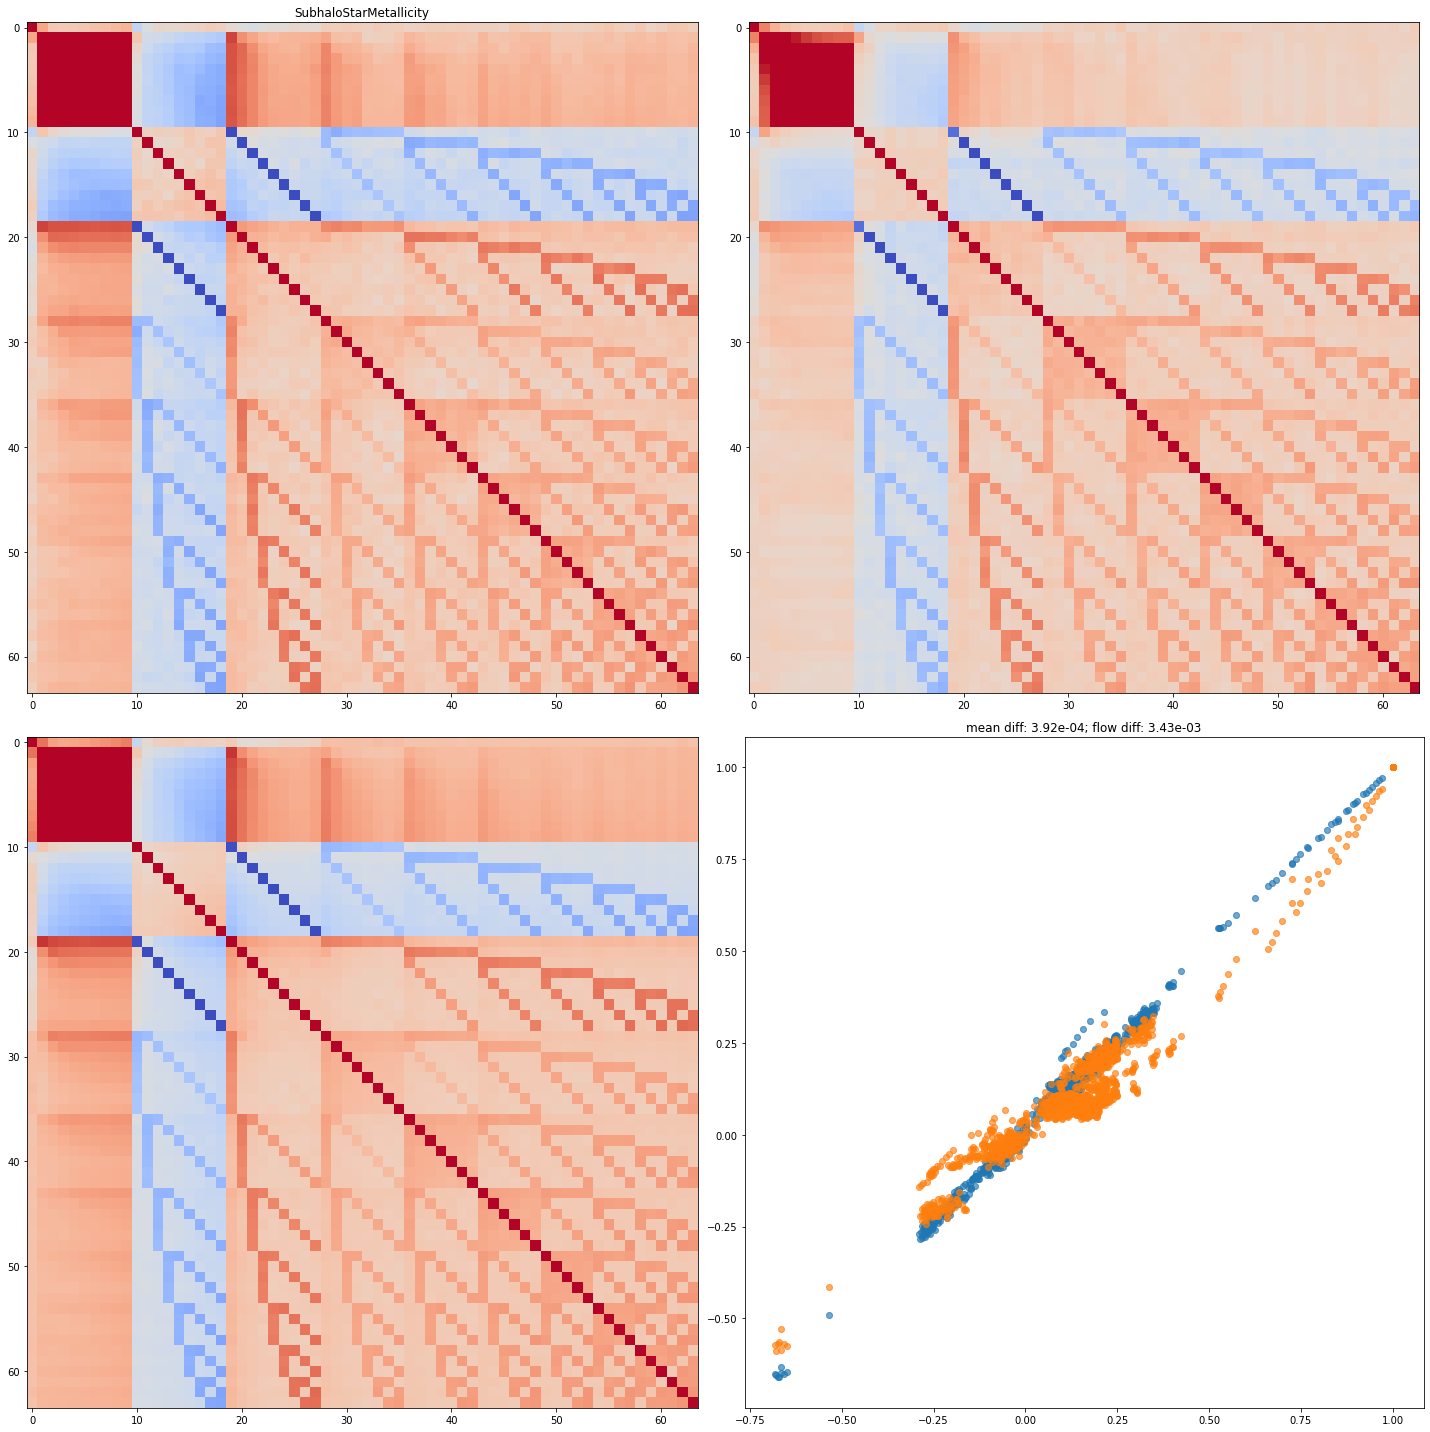

{'SubhaloStarMetallicity': [0.5, 0.6000000000000001]}


<Figure size 432x288 with 0 Axes>

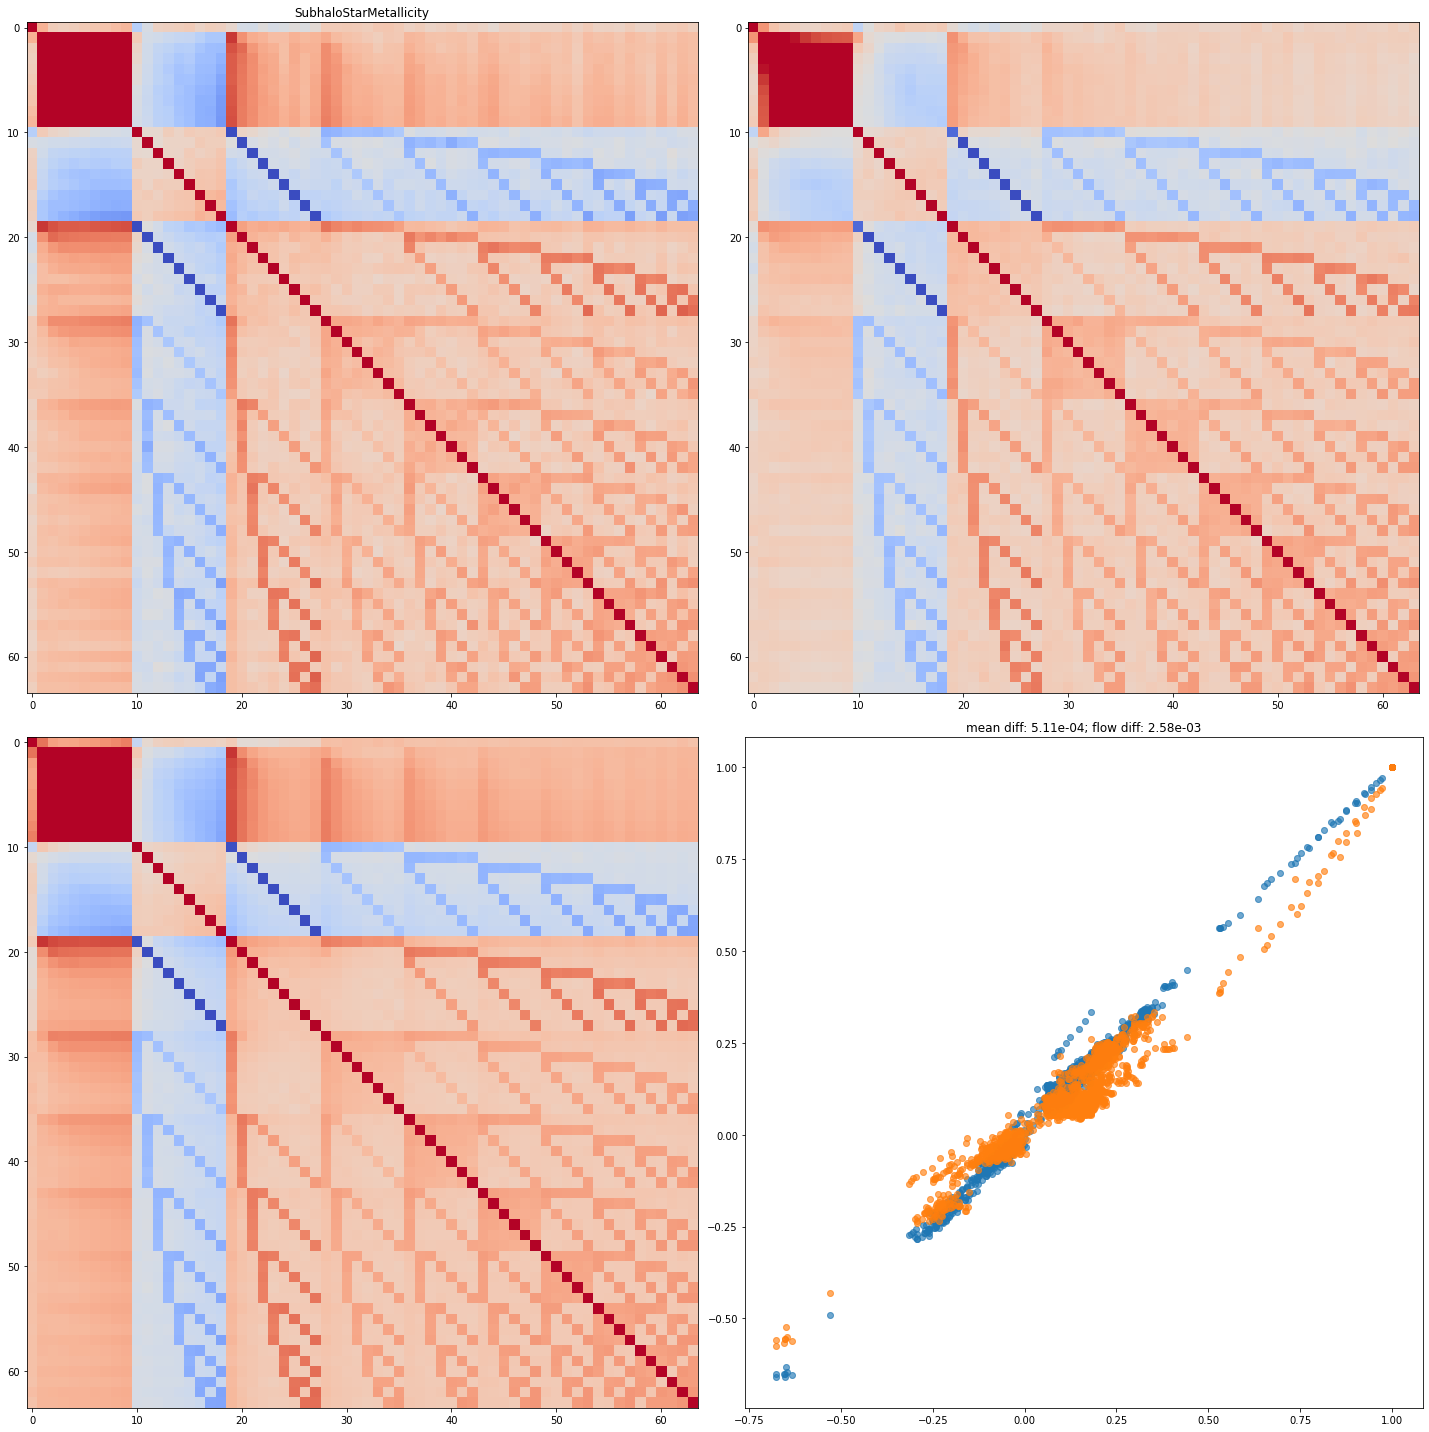

{'SubhaloStarMetallicity': [0.6000000000000001, 0.7000000000000001]}


<Figure size 432x288 with 0 Axes>

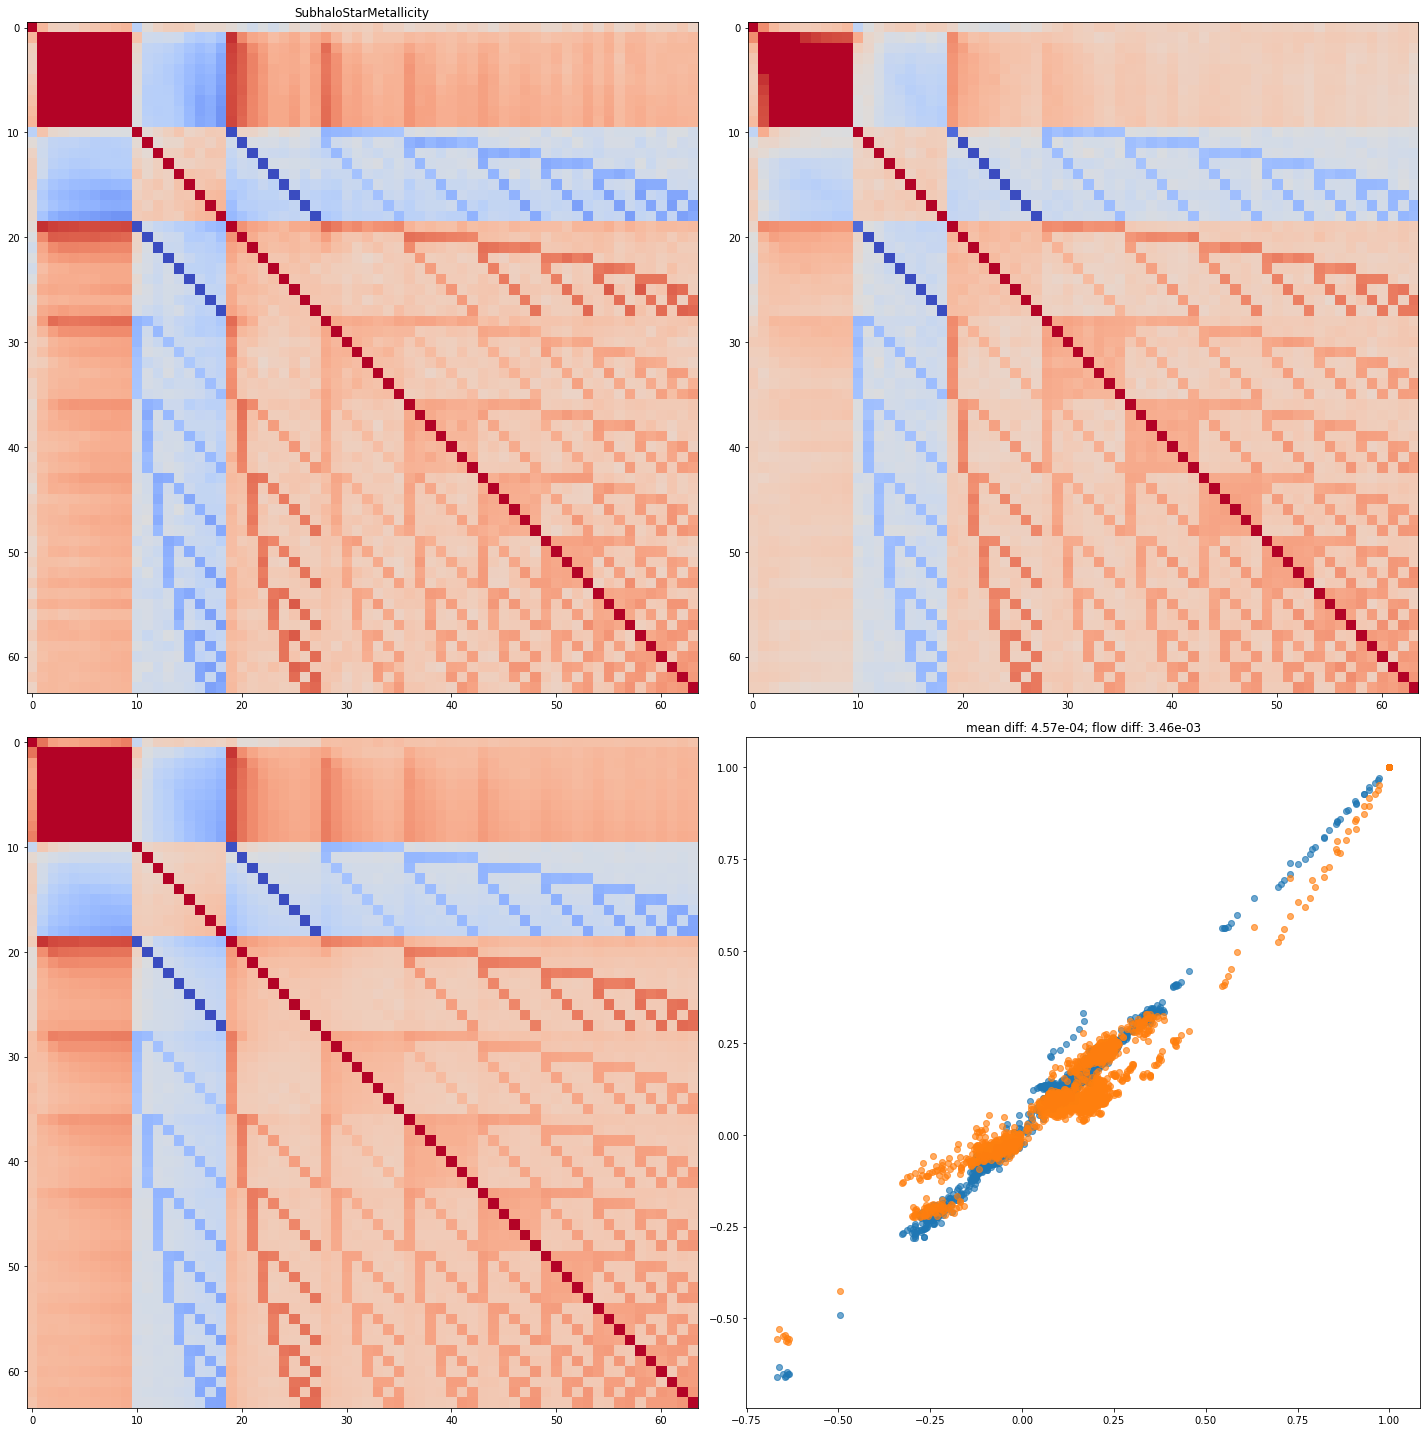

{'SubhaloStarMetallicity': [0.7000000000000001, 0.8]}


<Figure size 432x288 with 0 Axes>

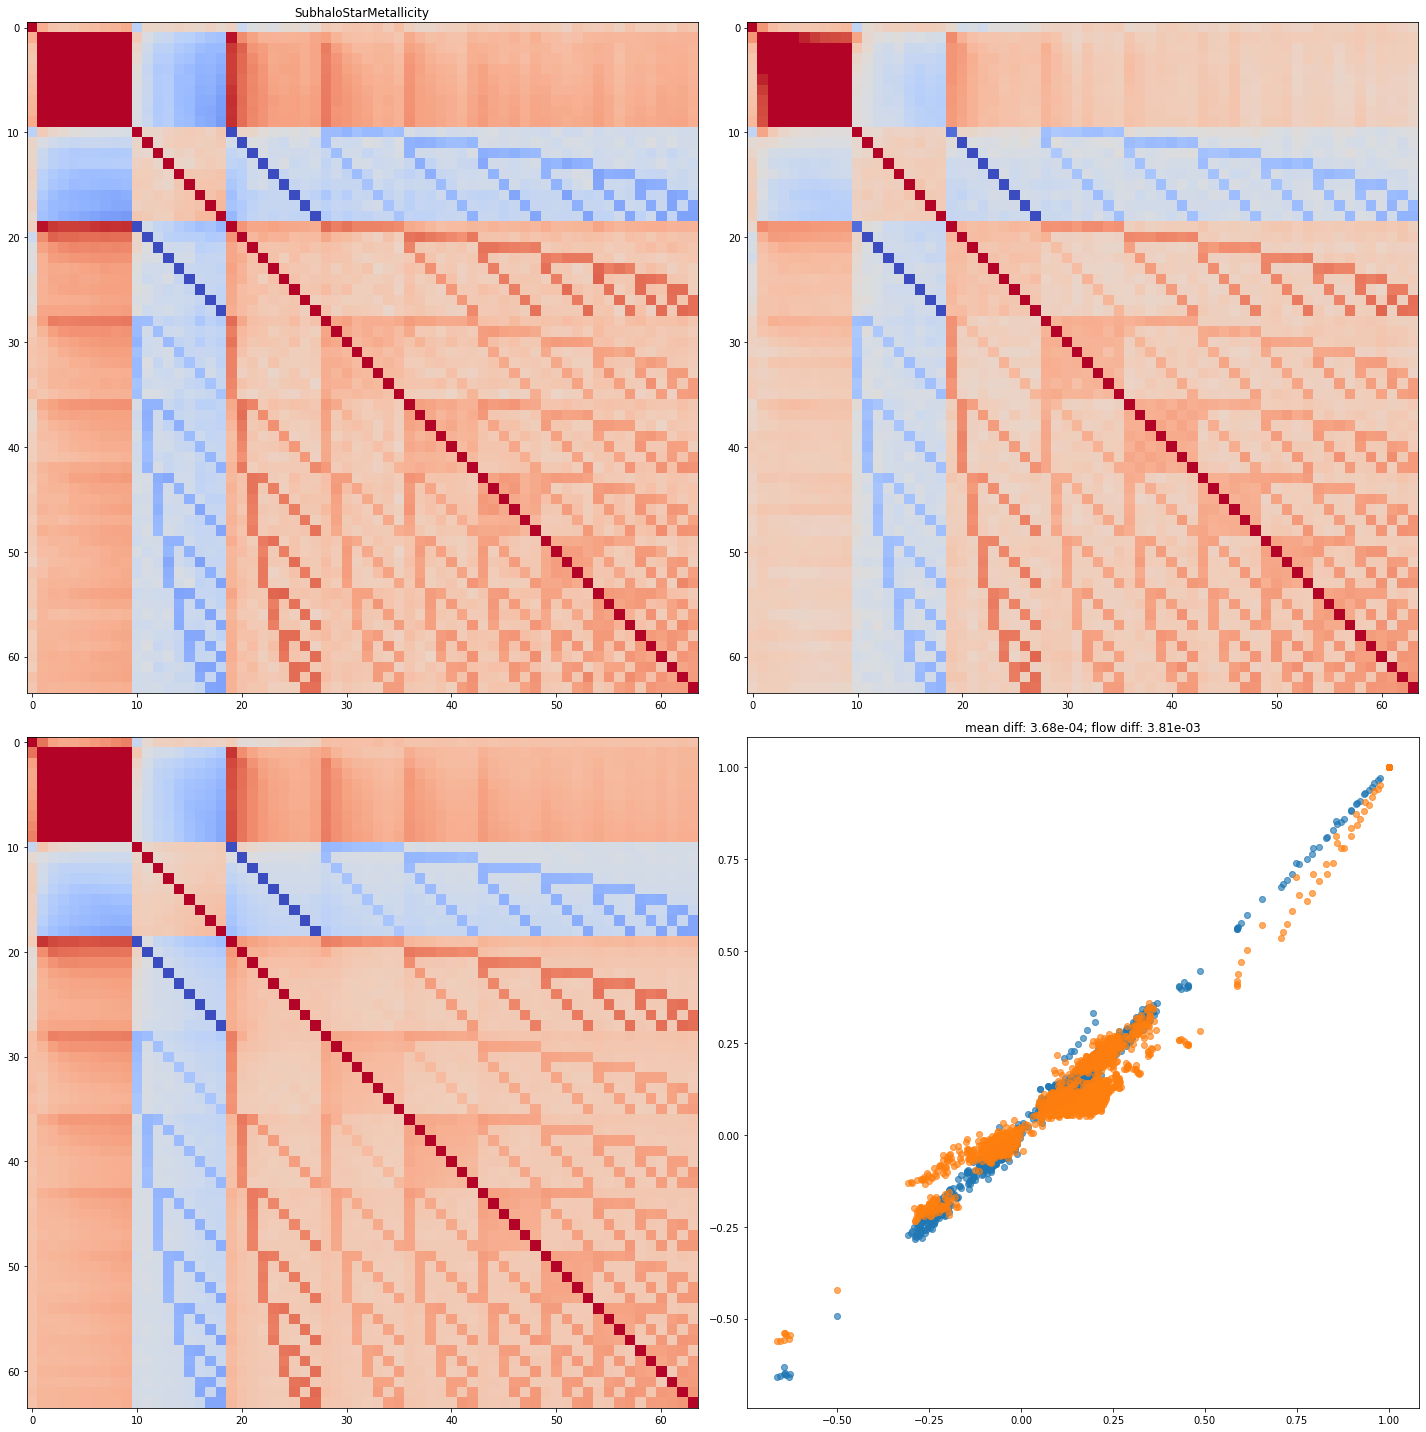

{'SubhaloStarMetallicity': [0.8, 0.9]}


<Figure size 432x288 with 0 Axes>

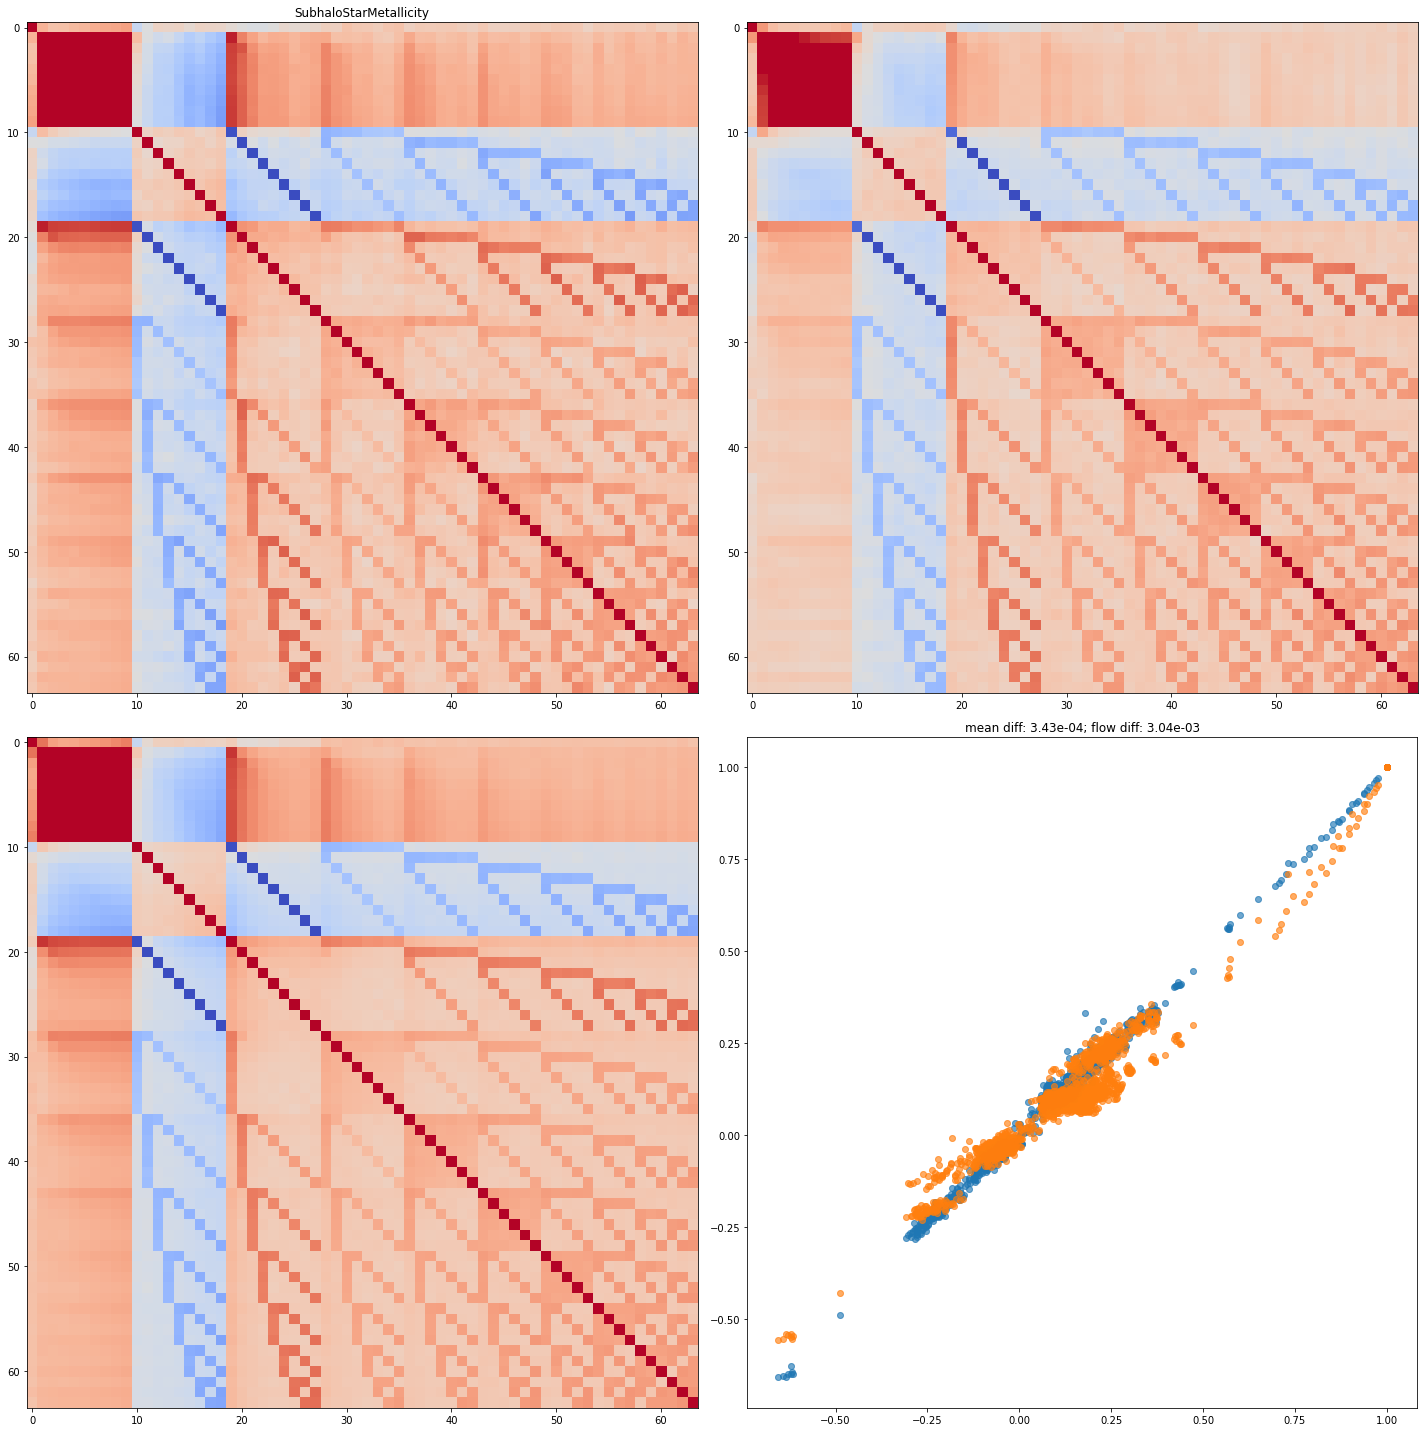

{'SubhaloStarMetallicity': [0.9, 1.0]}


<Figure size 432x288 with 0 Axes>

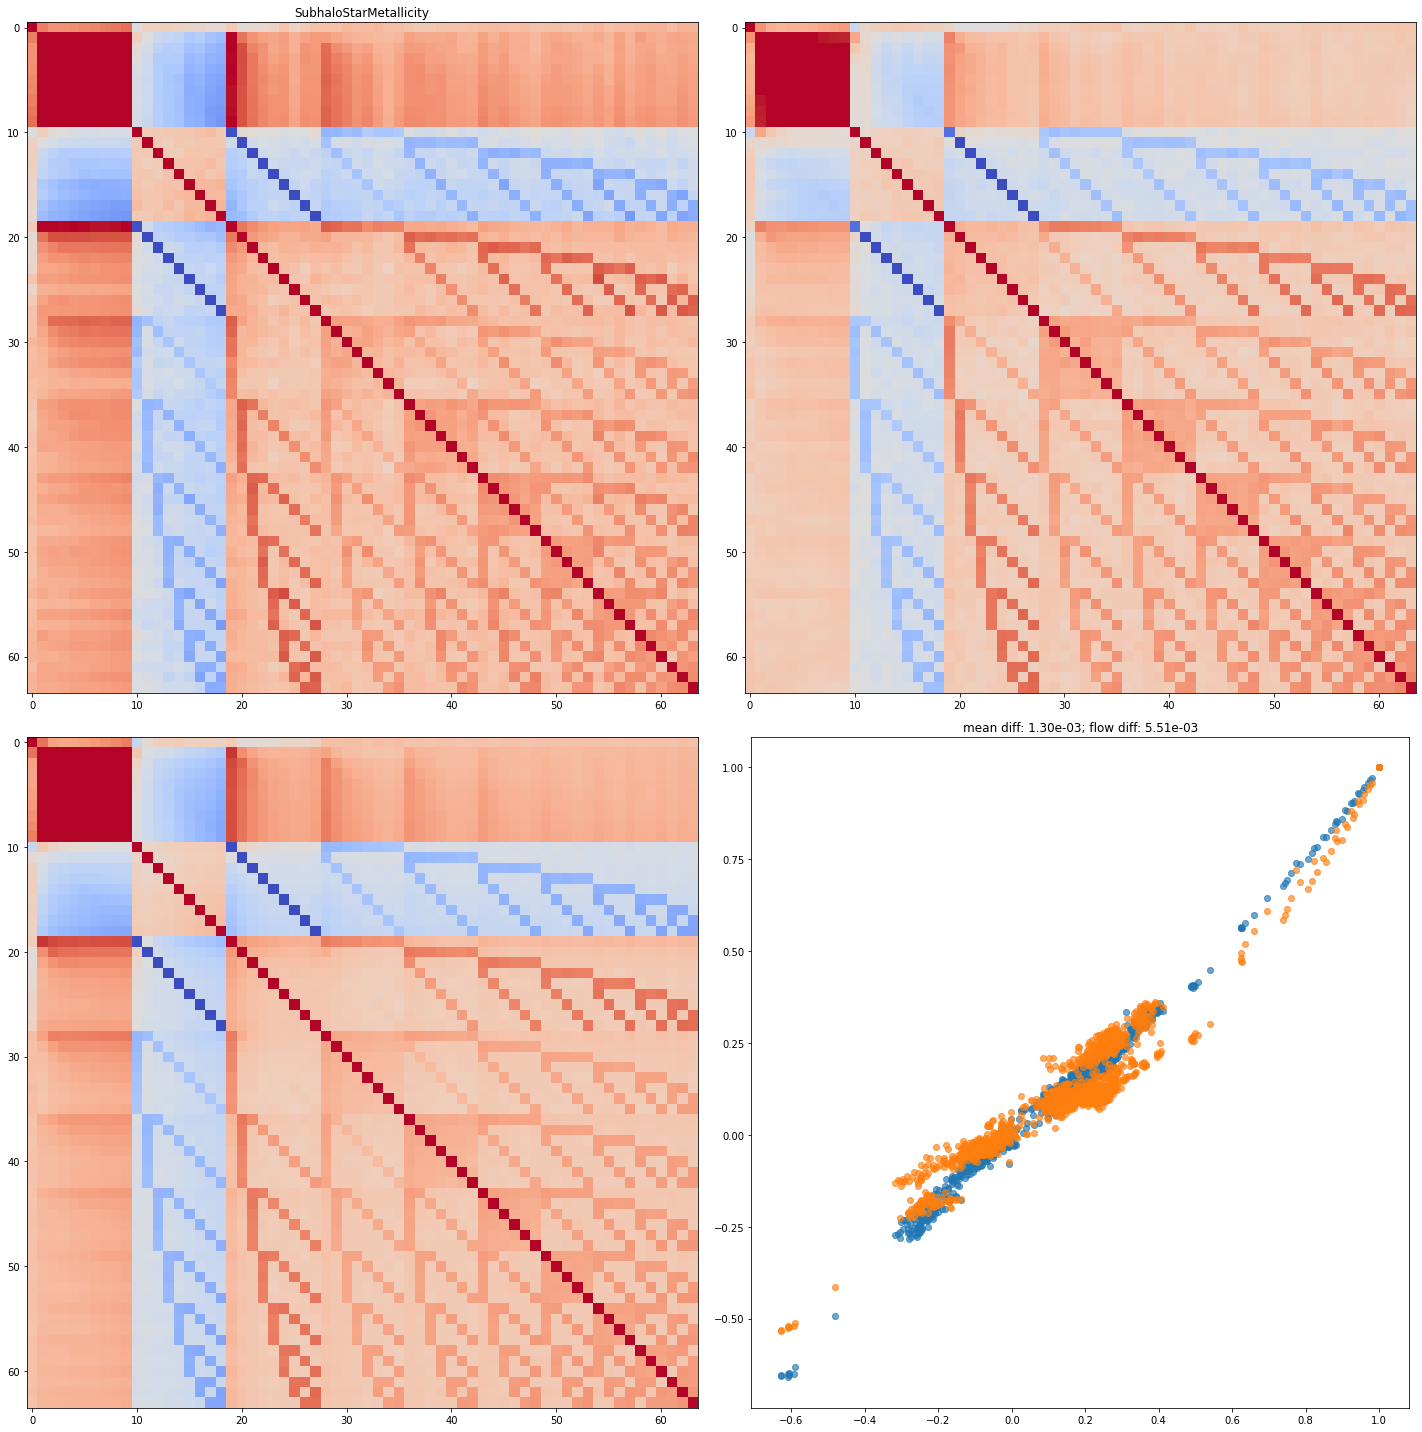

{'SubhaloMass': [0.0, 0.1]}


<Figure size 432x288 with 0 Axes>

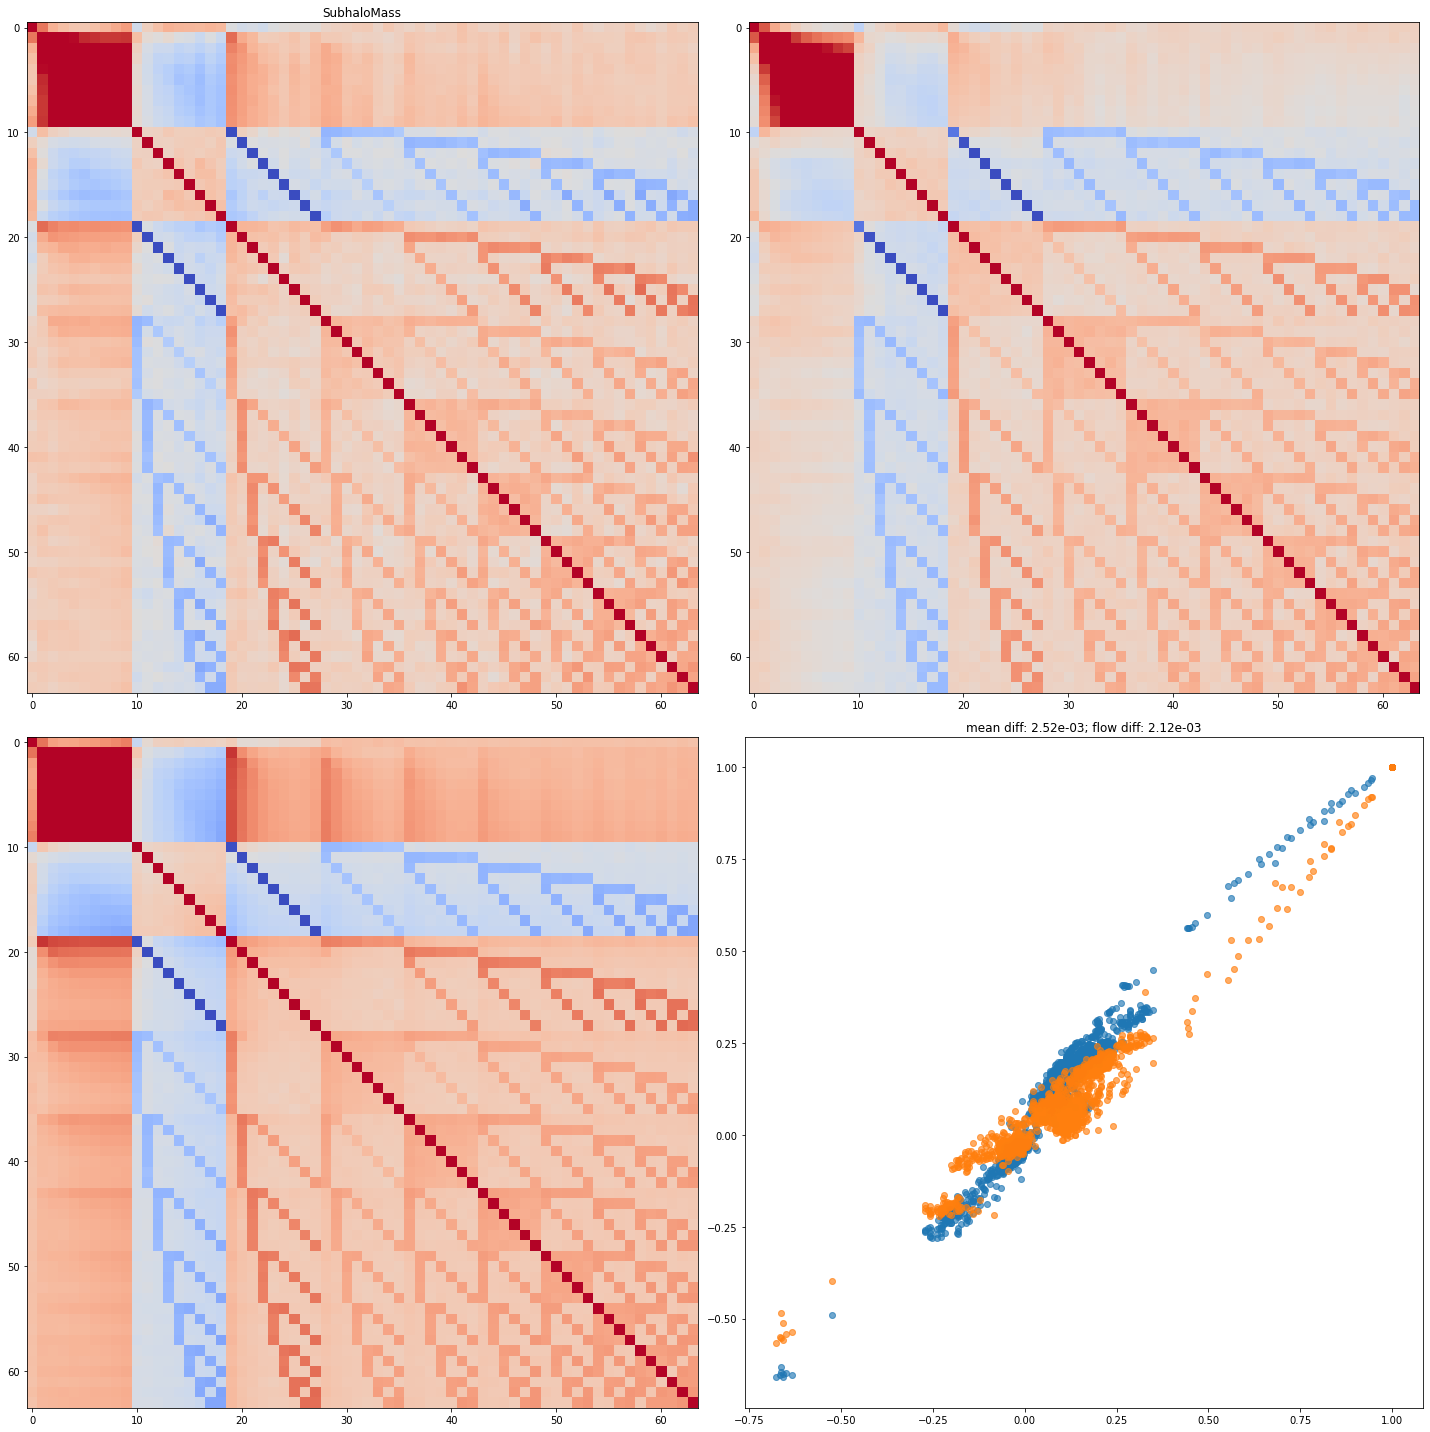

{'SubhaloMass': [0.1, 0.2]}


<Figure size 432x288 with 0 Axes>

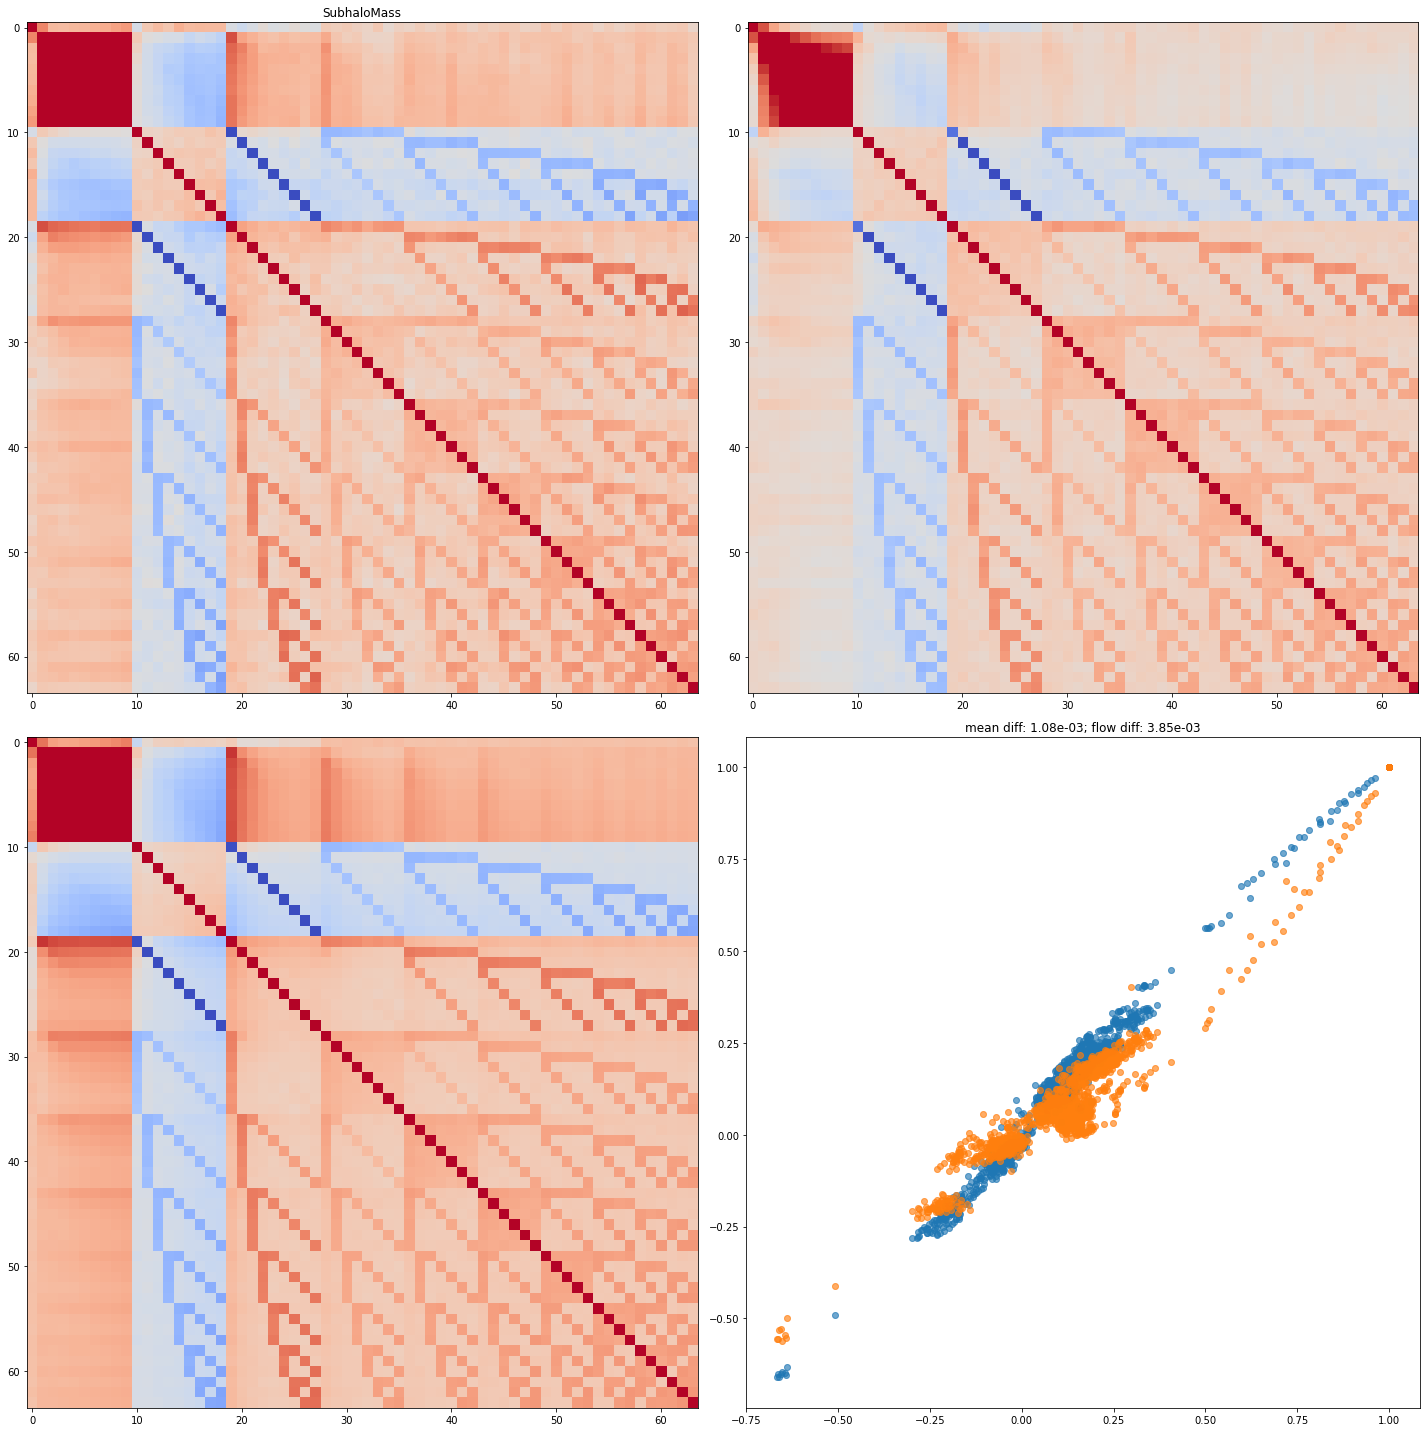

{'SubhaloMass': [0.2, 0.30000000000000004]}


<Figure size 432x288 with 0 Axes>

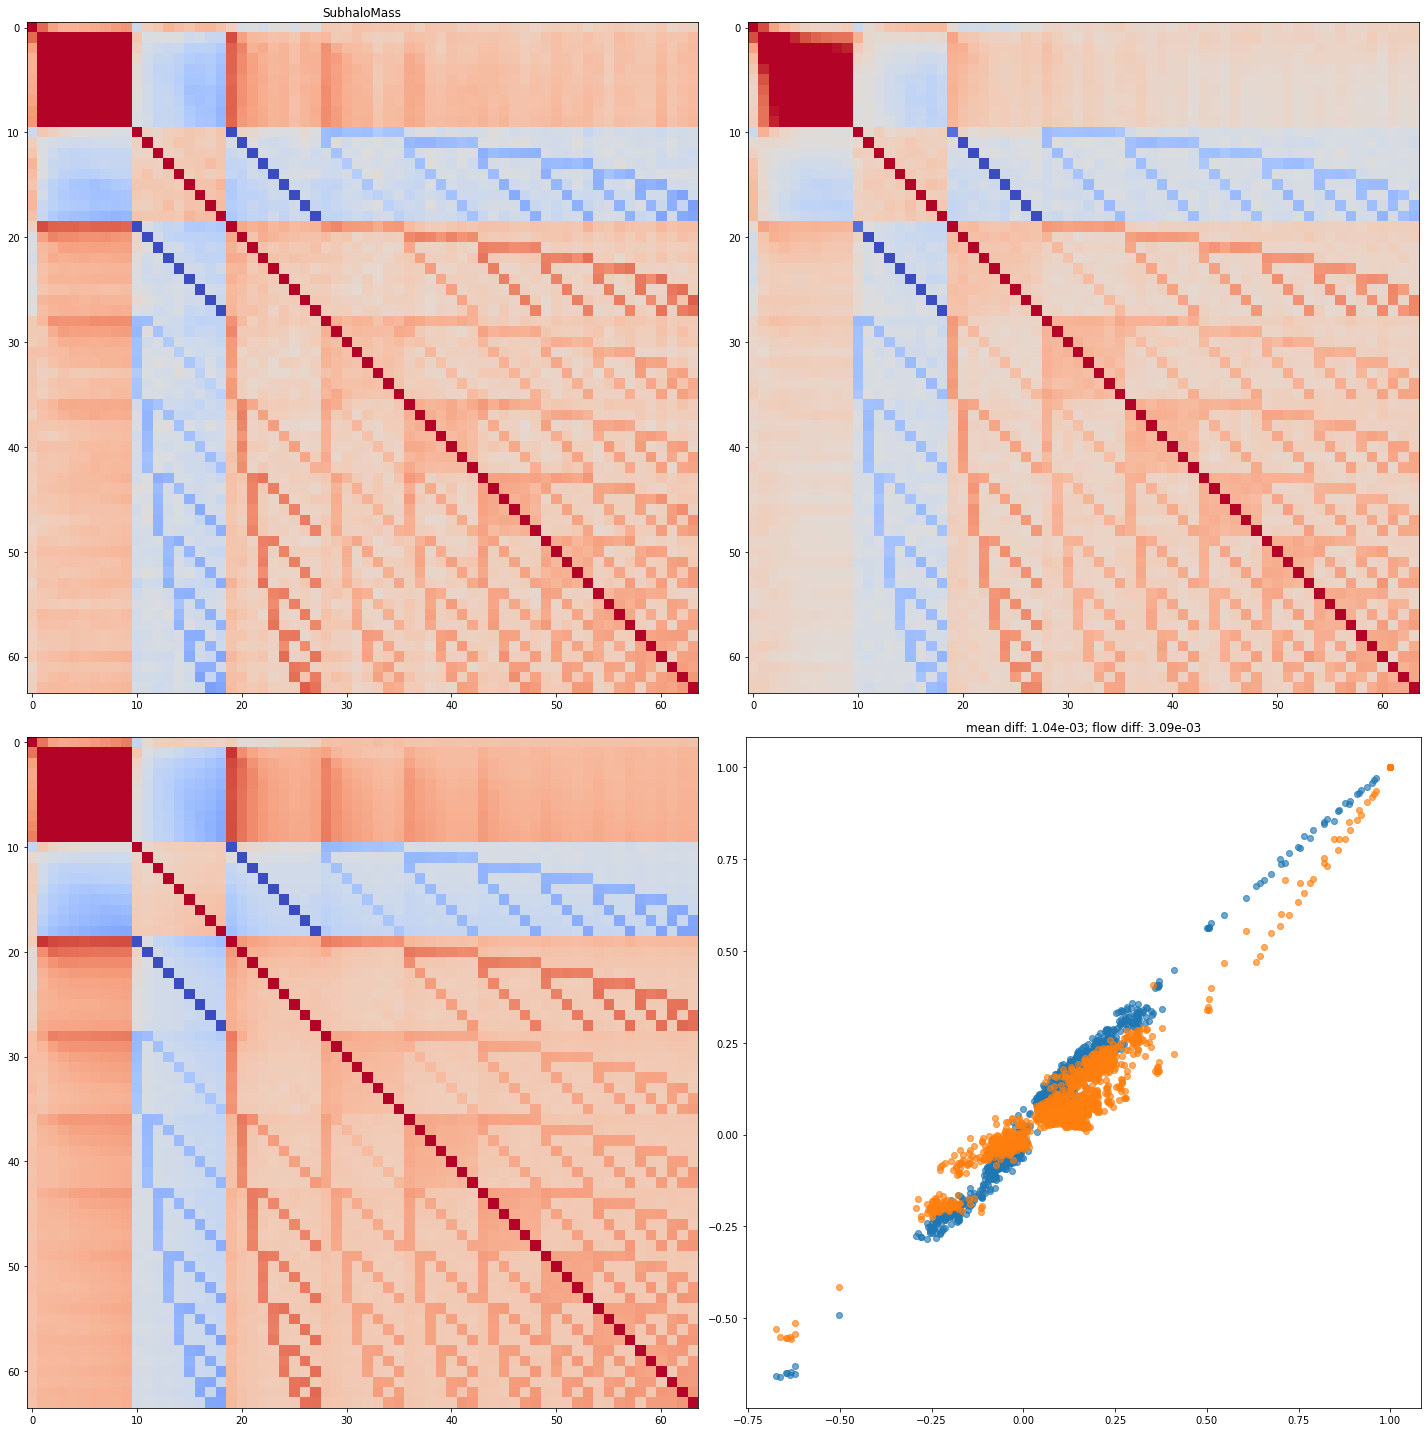

{'SubhaloMass': [0.30000000000000004, 0.4]}


<Figure size 432x288 with 0 Axes>

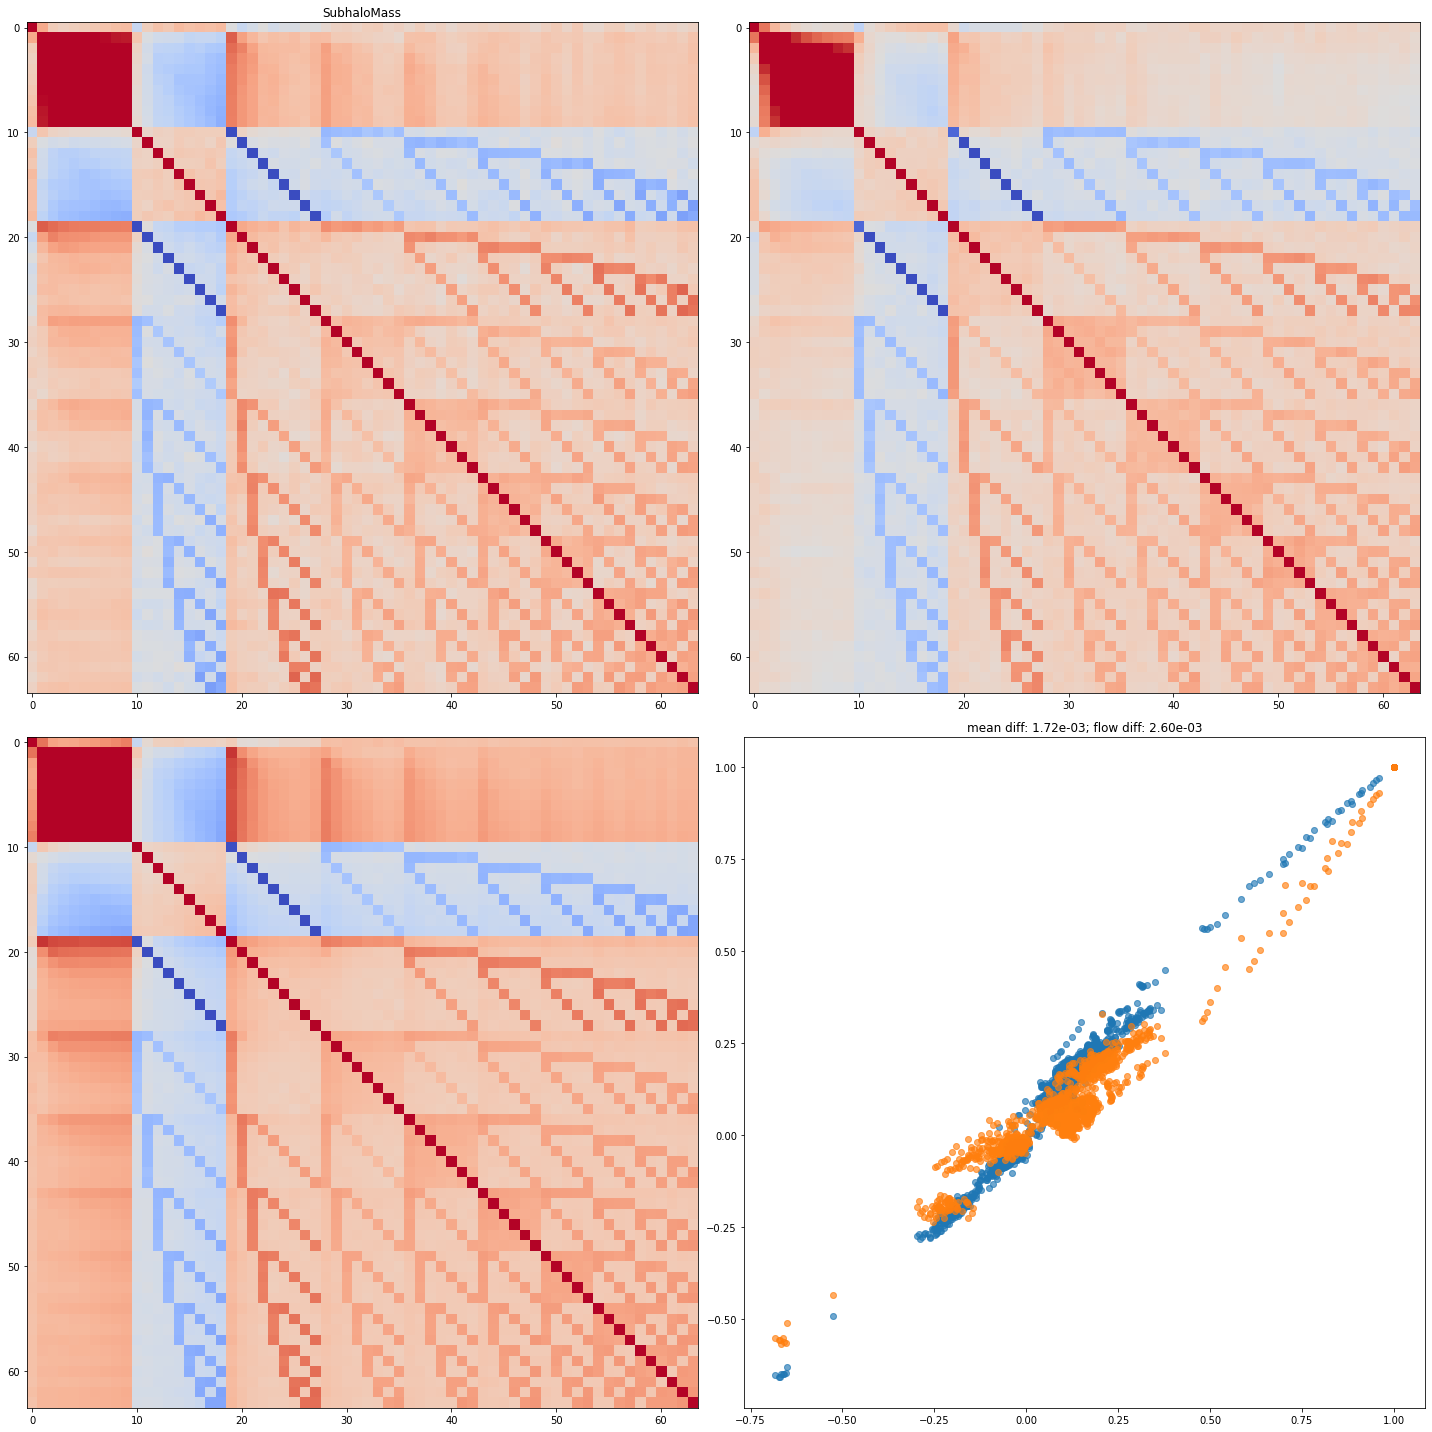

{'SubhaloMass': [0.4, 0.5]}


<Figure size 432x288 with 0 Axes>

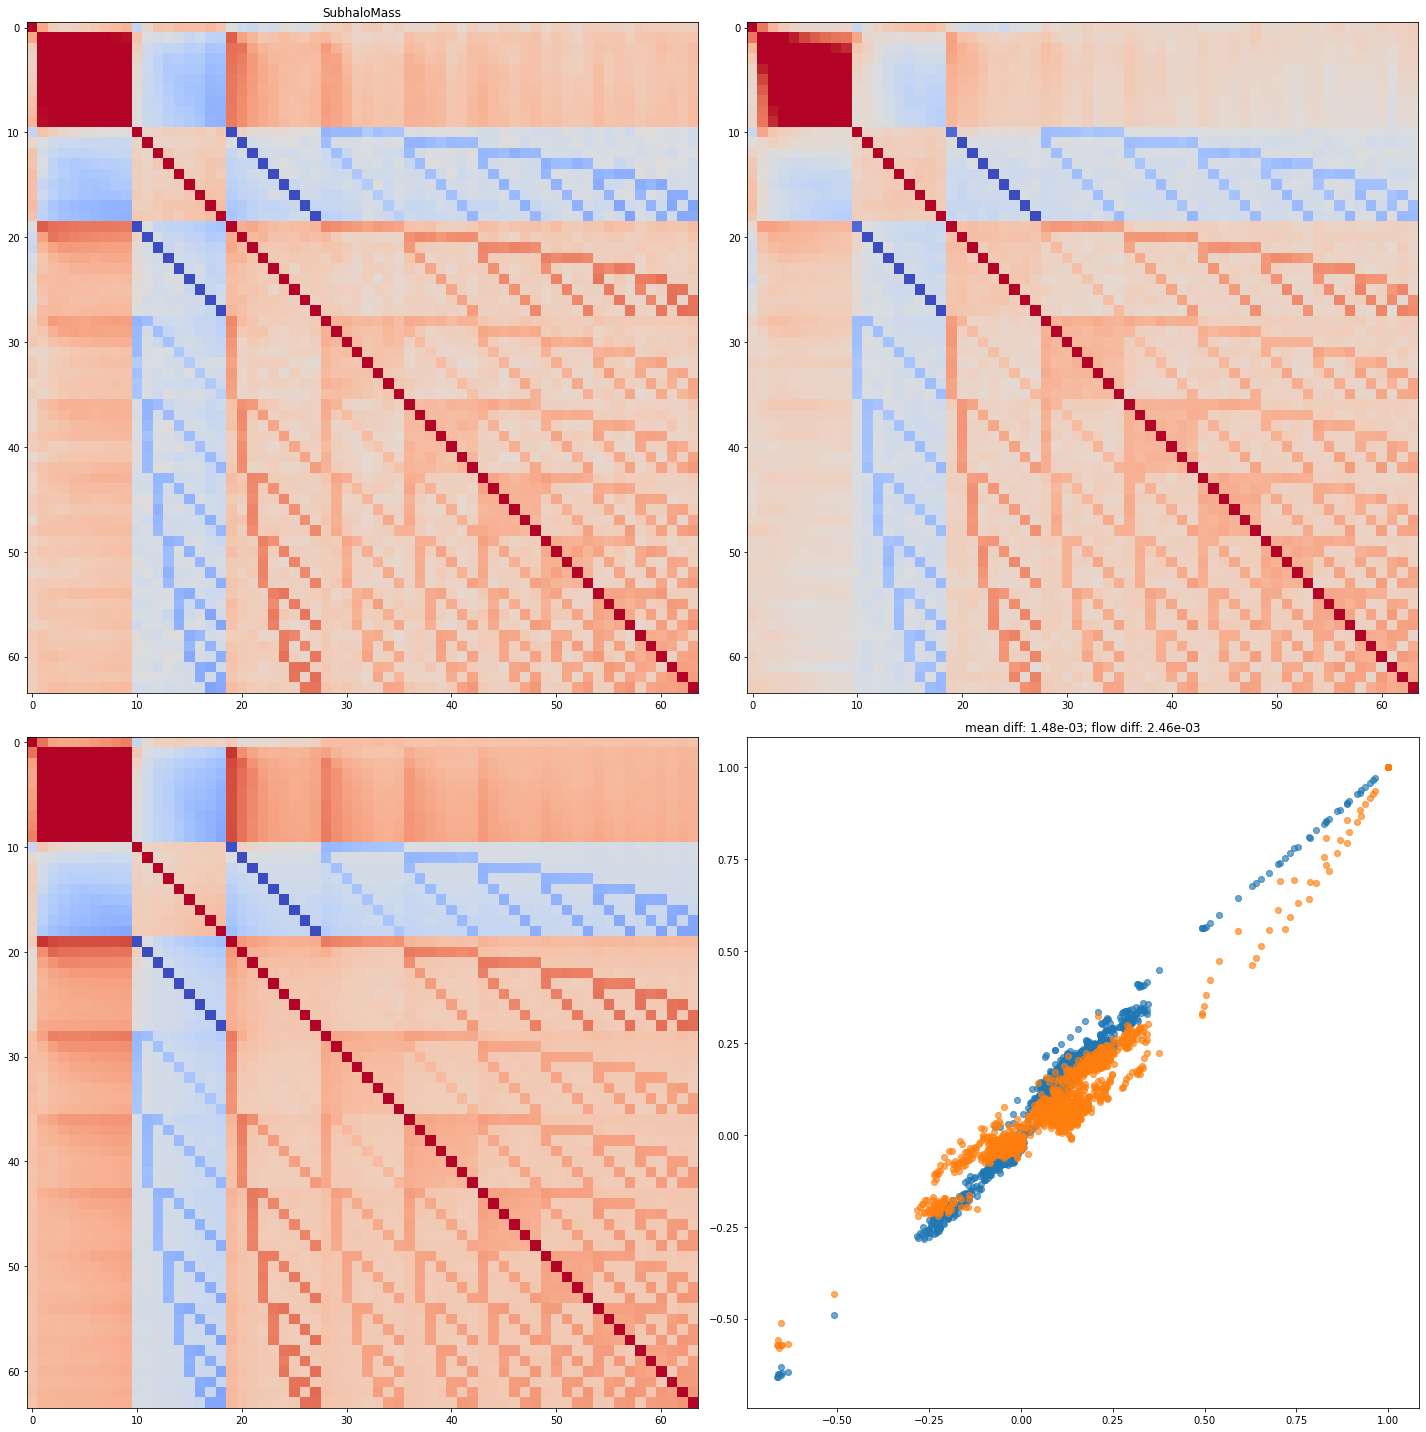

{'SubhaloMass': [0.5, 0.6000000000000001]}


<Figure size 432x288 with 0 Axes>

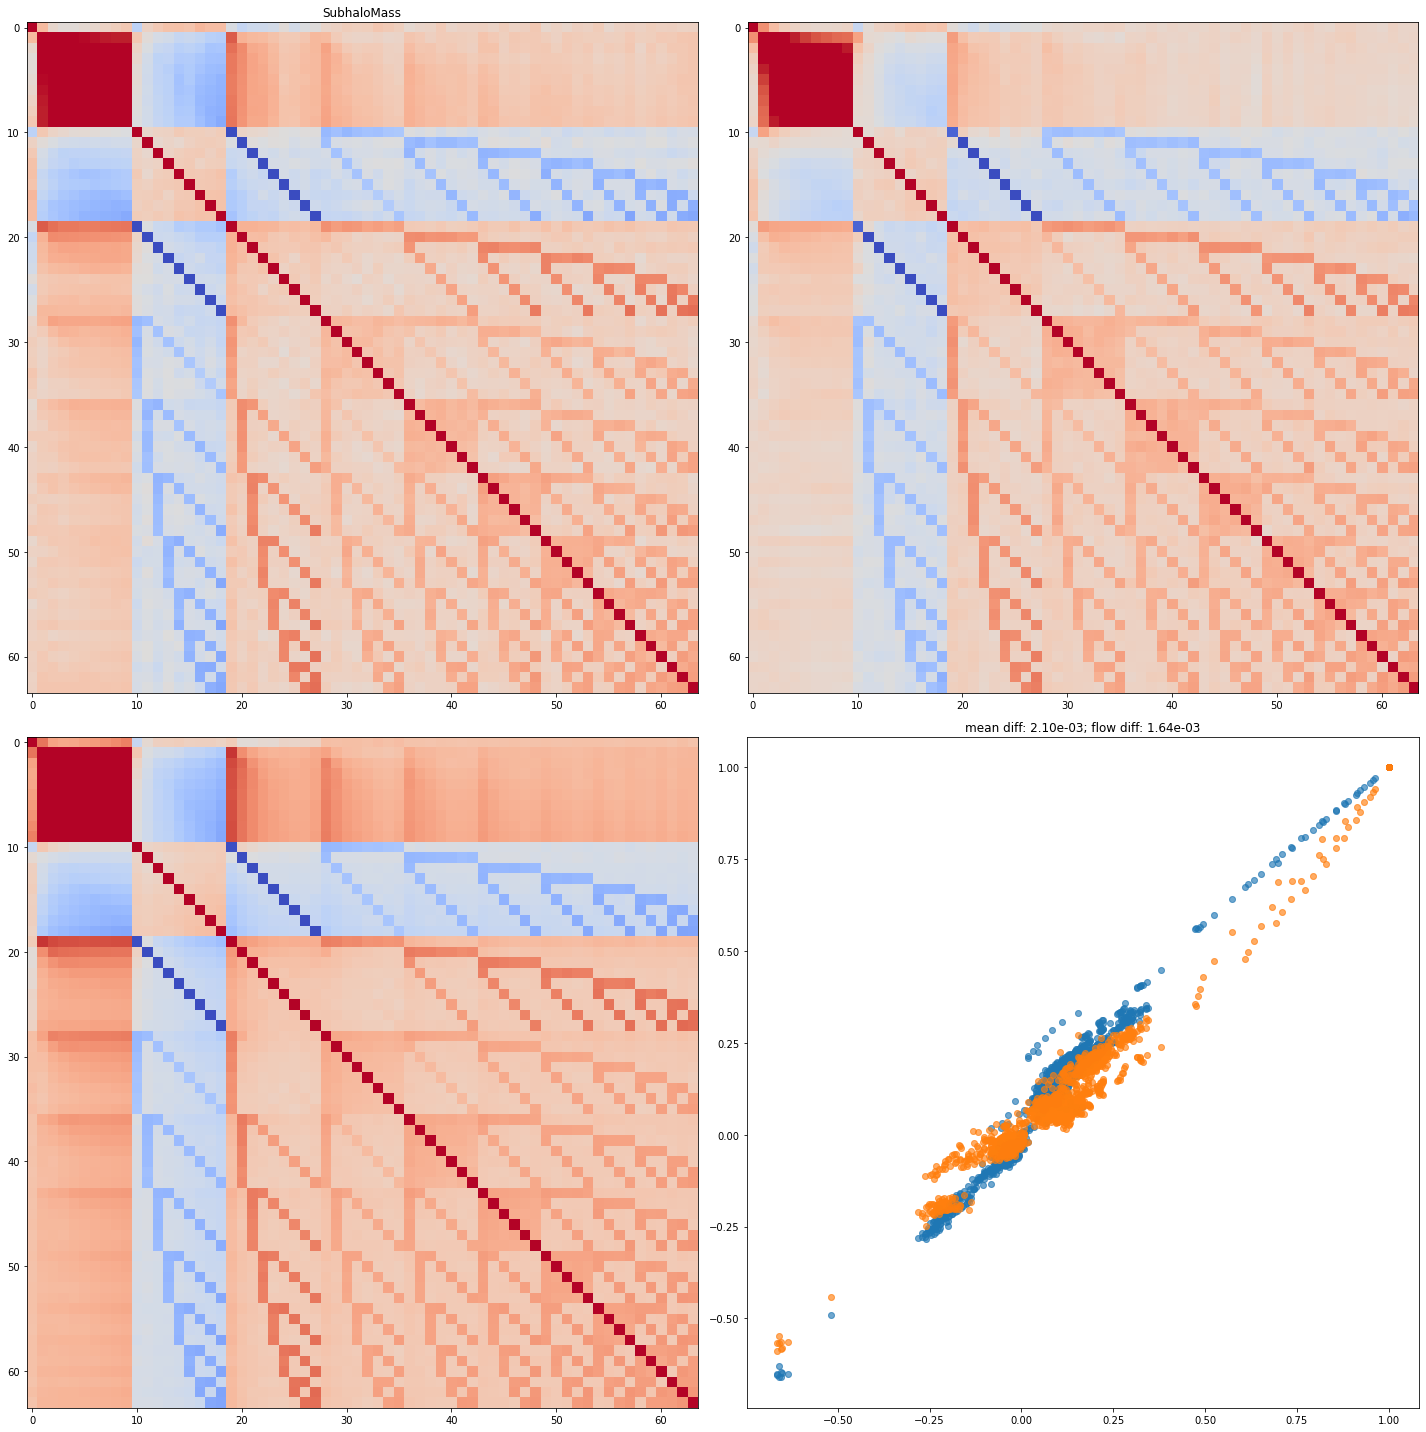

{'SubhaloMass': [0.6000000000000001, 0.7000000000000001]}


<Figure size 432x288 with 0 Axes>

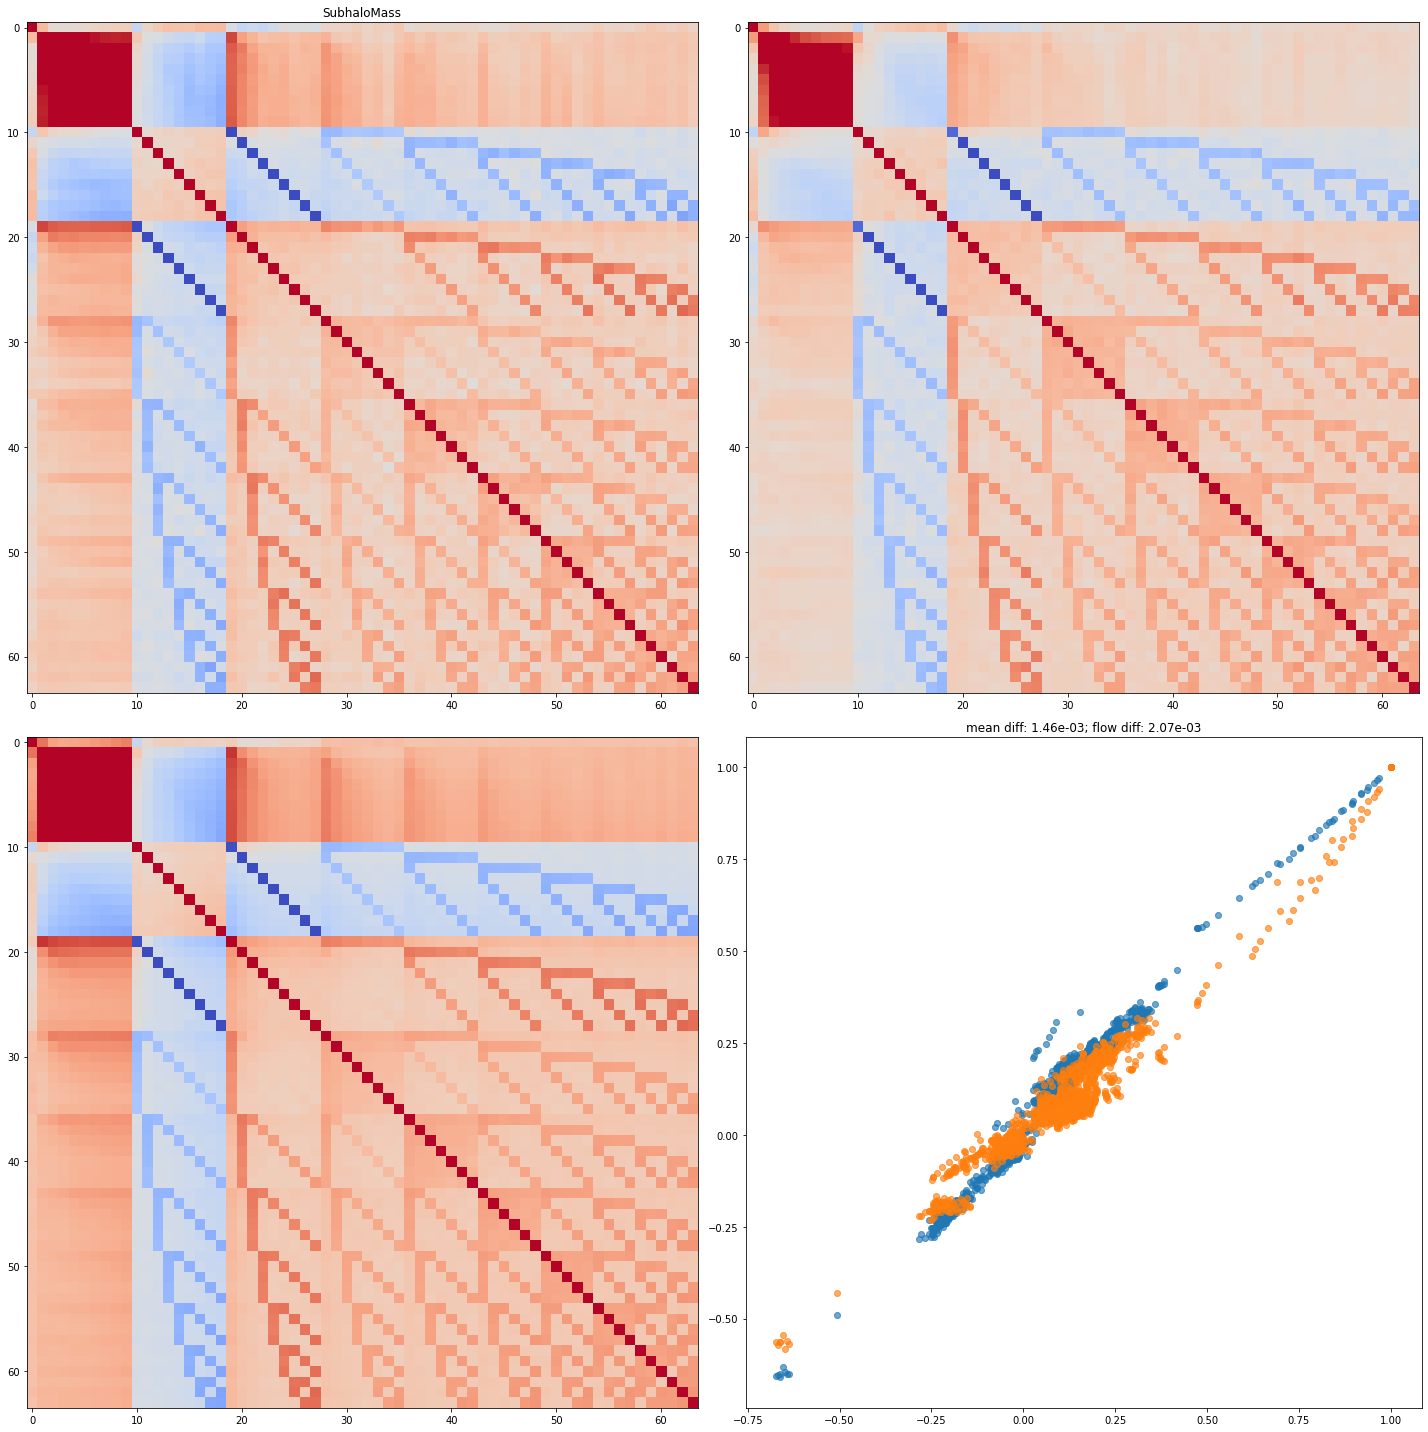

{'SubhaloMass': [0.7000000000000001, 0.8]}


<Figure size 432x288 with 0 Axes>

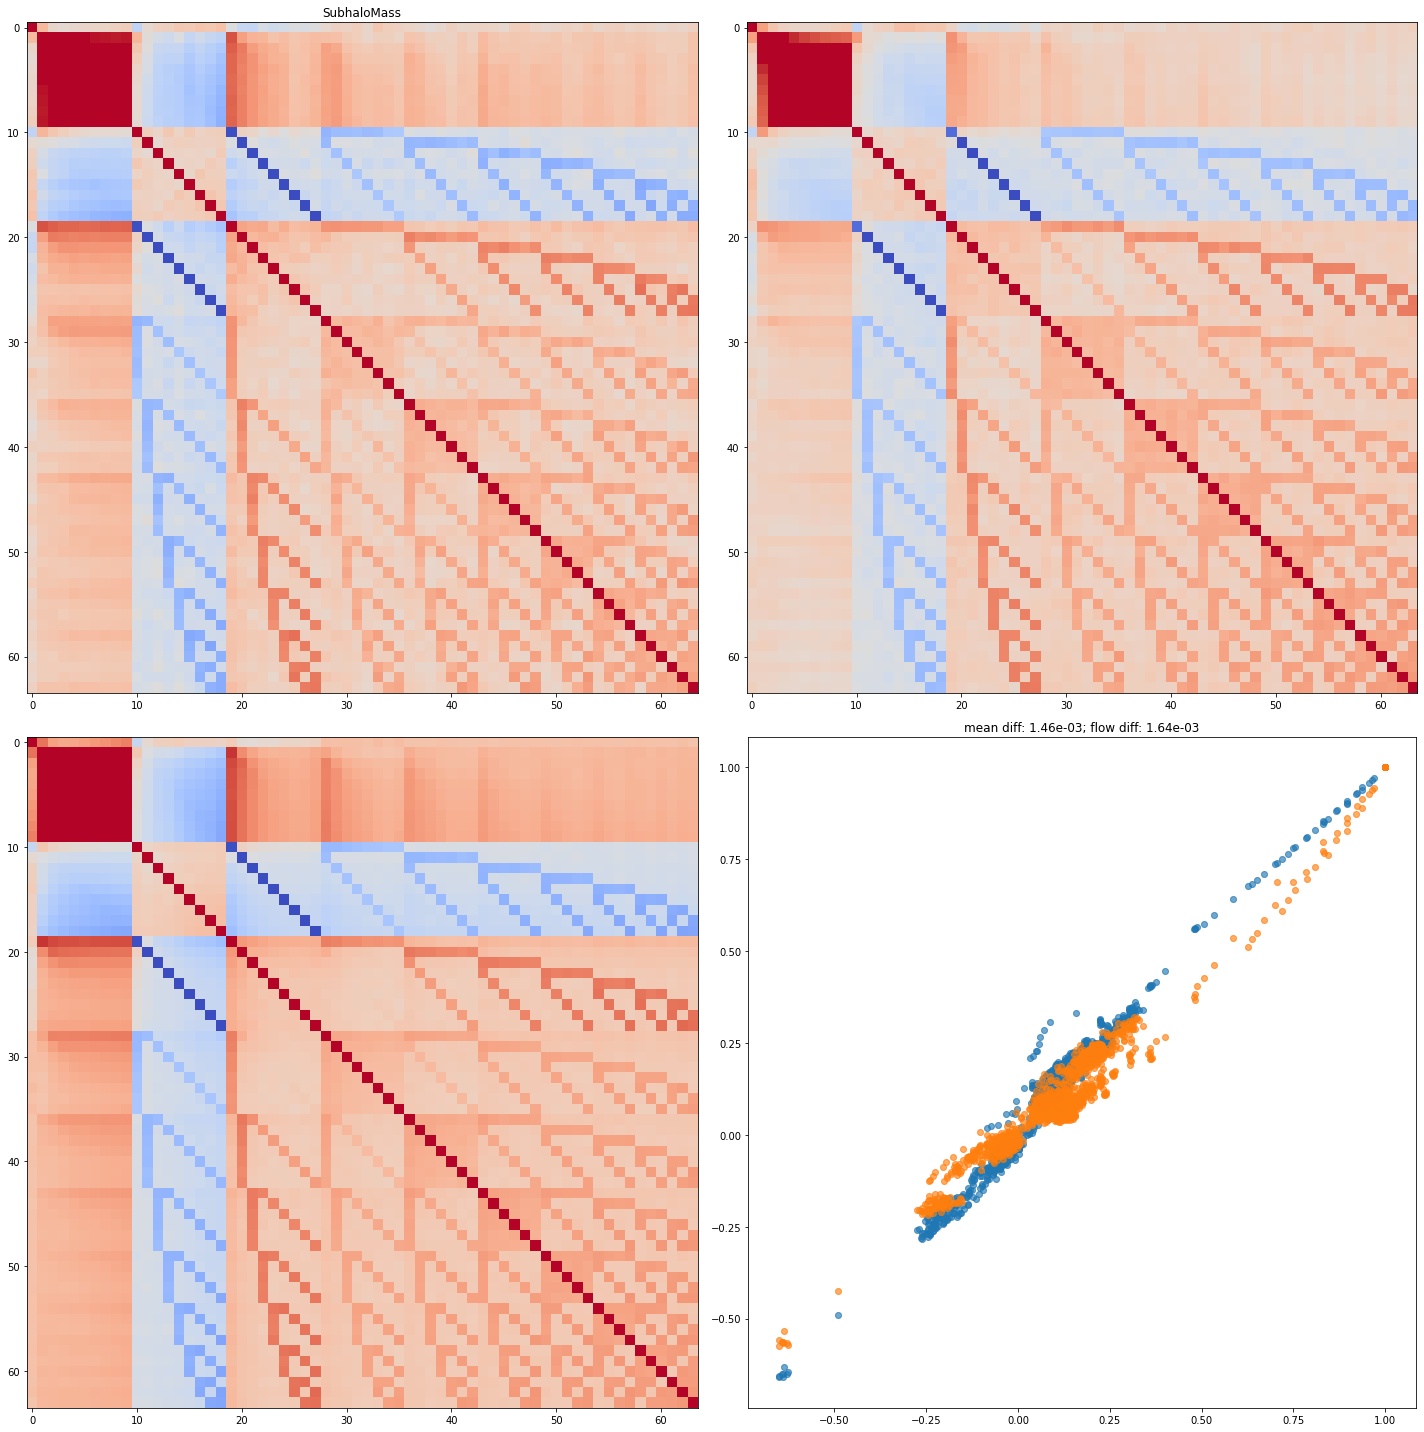

{'SubhaloMass': [0.8, 0.9]}


<Figure size 432x288 with 0 Axes>

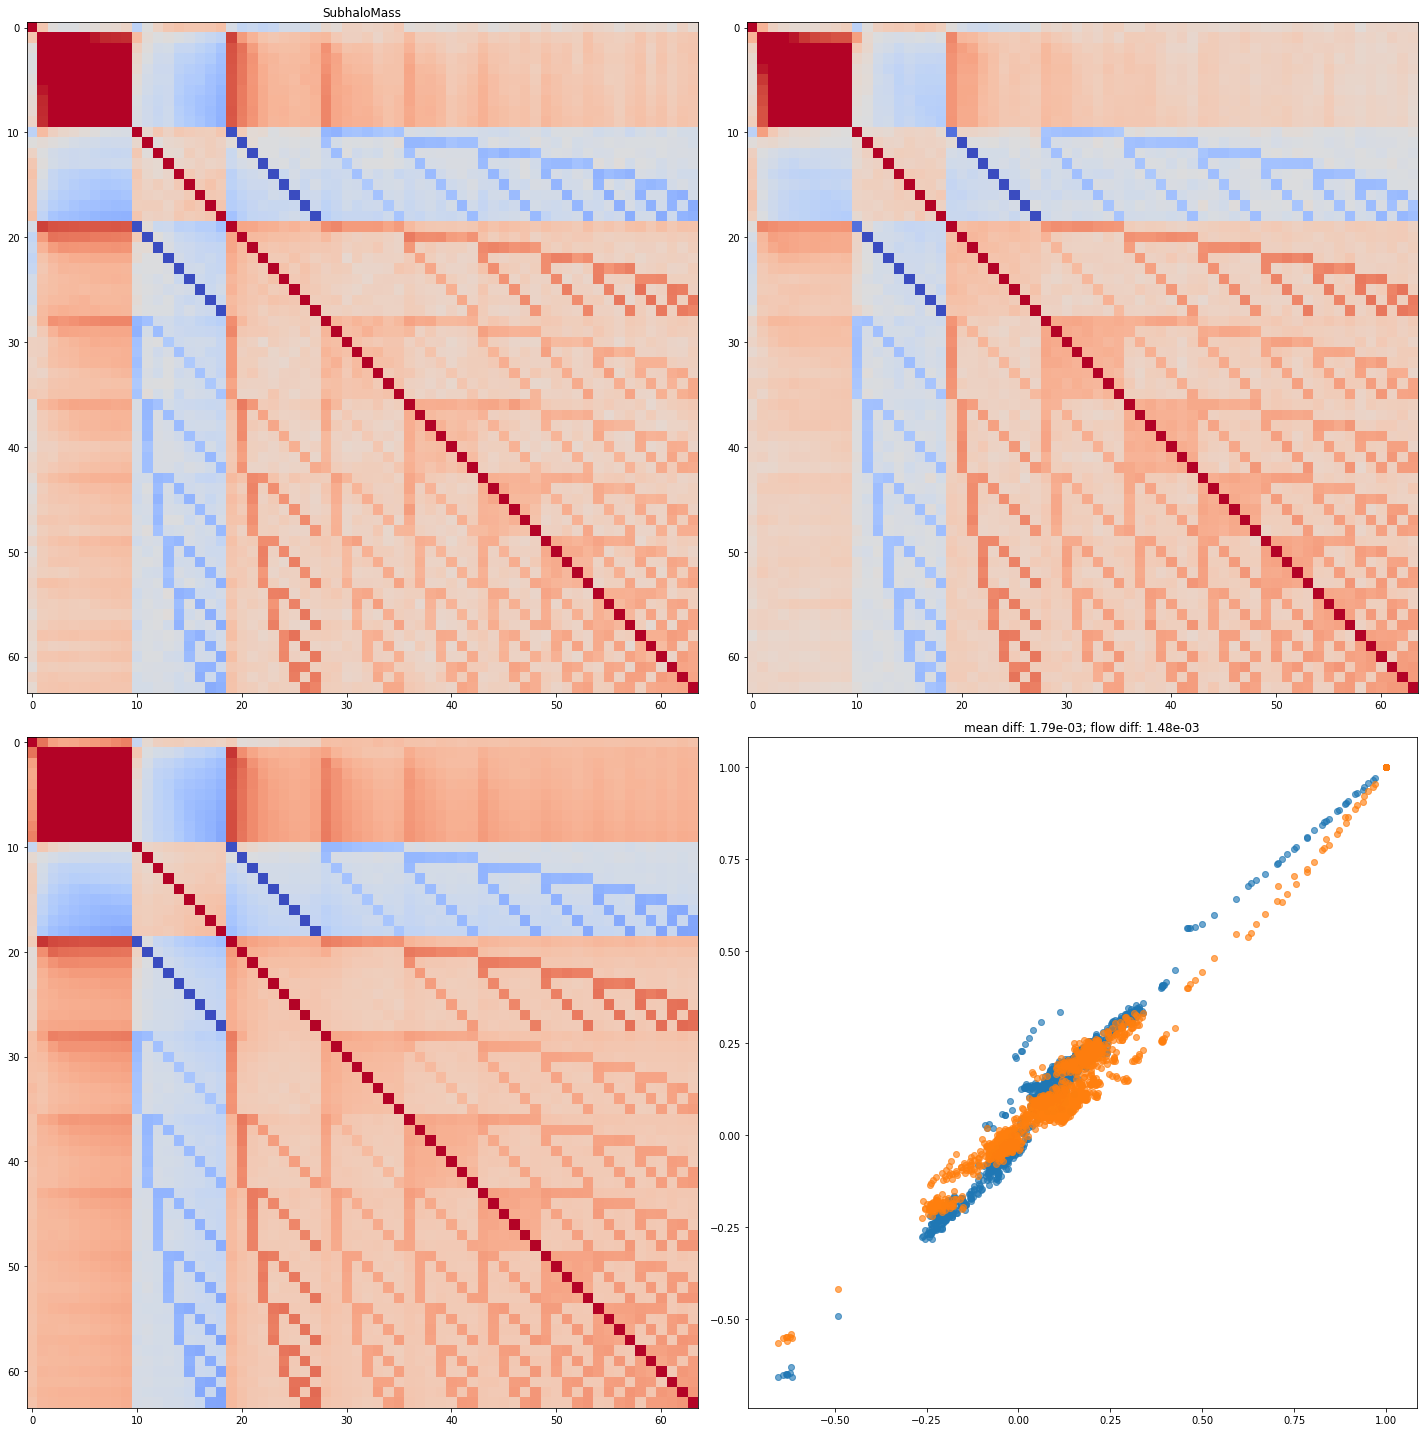

{'SubhaloMass': [0.9, 1.0]}


<Figure size 432x288 with 0 Axes>

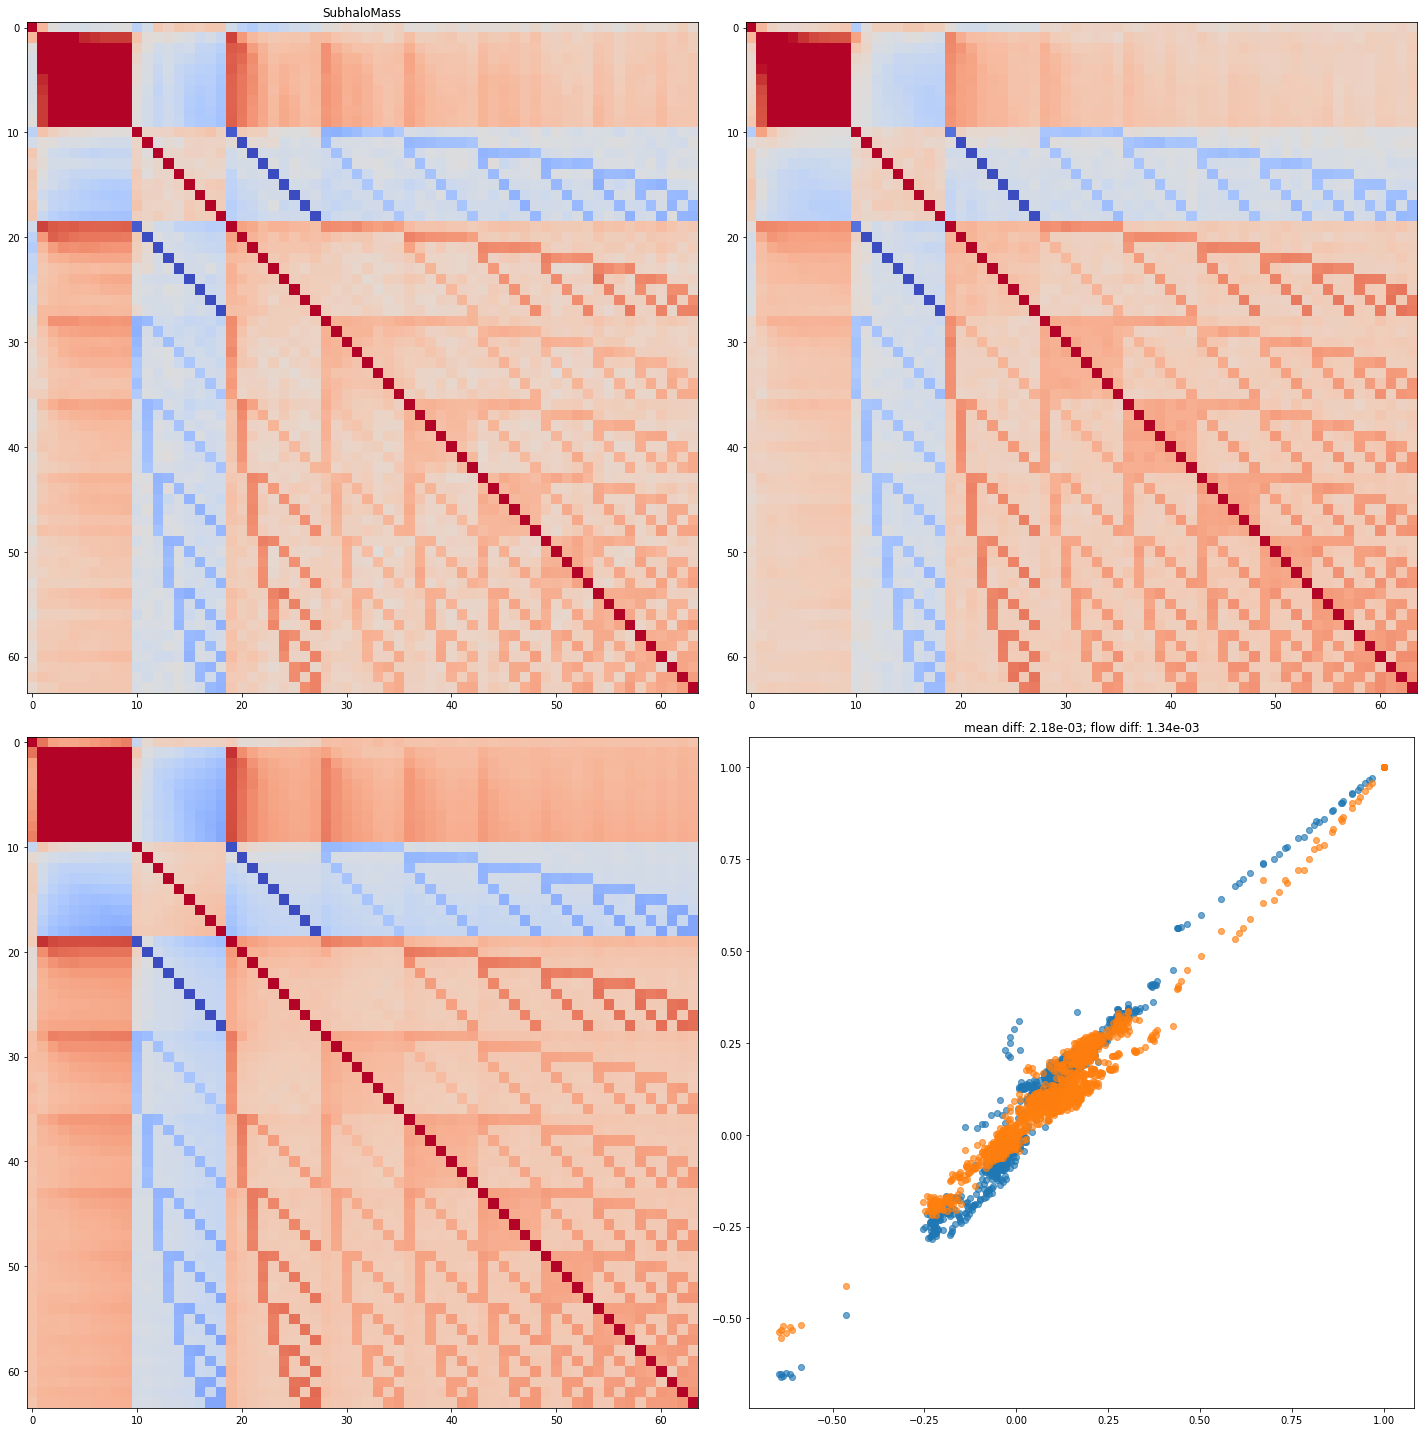

{'SubhaloSFR': [0.0, 0.1]}


ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
diff = []
for cond in dfcond.columns:
  for i in range(0,10):
    quantile_range = {
        cond: [i*0.1,(i+1)*0.1],
        }
    print(quantile_range)

    select_cond, select_feat, select_context = select_by_quantiles(dfcond_qnorm, dfcond, dffeat,quantile_range)
    df_conditioned = norm_data(select_feat[select_feat['SubhaloMass_9'] != 0 ])[cols]

    mean_corr, std_corr = bootstrap_corr(df_data, nsamples= len(select_feat), ntimes =100)
    corr = df_conditioned.corr()

    


    select_flow_feats = generate_flow_samples(
        select_context, 
        flow, 
        prior, 
        nsamples=len(select_context)
        )
    df_flowfeat = pd.DataFrame(select_flow_feats, columns=dffeat.columns)
    df_flowfeat = normalize_flowdata(df_flowfeat)
    cols = [c for c in dffeat if c != 'SubhaloMergeRedshift_0']
    df_flowfeat = df_flowfeat[cols]

    f,ax = plt.subplots(2,2, figsize=(20,20))
    
    # mask out correlation that is too negligible?
    corr_cond = df_conditioned.corr()
    flag = np.abs(df_conditioned.corr().values - mean_corr) <= 2.0*std_corr
    diff = corr_cond - mean_corr
    # corr_cond[flag] = 0

    ax.flat[0].set_title(f"{cond}")
    ax.flat[0].imshow(corr_cond, vmin=-0.5, vmax=0.5, cmap='coolwarm')

    # mask out correlation that is too negligible?
    flag = np.abs(df_flowfeat.corr().values - mean_corr) <= 2.0*std_corr
    corr_flow = df_flowfeat.corr()
    diff = corr_flow - mean_corr
    # corr_flow[flag] = 0
    ax.flat[1].imshow(corr_flow, vmin=-0.5, vmax=0.5, cmap='coolwarm')


    flag = np.abs(mean_corr) >= 2.0*std_corr
    mean_corr_mask = np.zeros_like(mean_corr)
    # mean_corr_mask[flag] = mean_corr[flag]
    ax.flat[2].imshow(mean_corr, vmin=-0.5, vmax=0.5, cmap='coolwarm')

    ax.flat[3].scatter(corr_cond.values.flatten(), mean_corr.flatten(), alpha=0.4)
    ax.flat[3].scatter(corr_cond.values.flatten(), corr_flow.values.flatten(), alpha=0.4)
    ax.flat[3].set_aspect(1.0)

    mean_diff = ((corr_cond.values.flatten()- mean_corr.flatten())**2).mean()
    flow_diff = ((corr_cond.values.flatten()- corr_flow.values.flatten())**2).mean()
    ax.flat[3].set_title(f"mean diff: {mean_diff:.2e}; flow diff: {flow_diff:.2e}")
    plt.tight_layout()
    plt.show()
    plt.clf()

    diff.append([mean_diff, flow_diff])

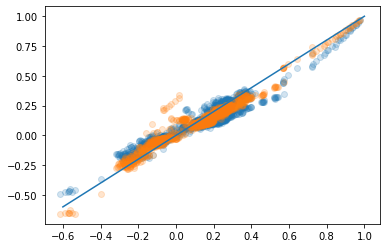

In [ ]:
corr_cond = df_conditioned.corr()
corr_flow = df_flowfeat.corr()

lower_flow = np.tril(corr_flow,k=-1)

lower_cond = np.tril(corr_cond,k=-1)

flag = (lower_flow != 0) | (lower_cond != 0)

lower_flow = lower_flow[flag]
lower_cond = lower_cond[flag]

lower_mean = np.tril(mean_corr, k=-1)
lower_mean = lower_mean[flag]

plt.scatter(lower_cond, lower_flow, alpha=0.2)
plt.scatter(lower_cond, lower_mean, alpha=0.2)
plt.plot([-0.6,1.0], [-0.6,1.0])

In [ ]:
((lower_cond - lower_flow)**2).mean(),((lower_cond - lower_mean)**2).mean()

(0.004337777358155093, 0.002595247792767056)

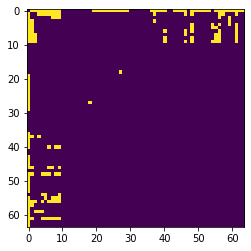

In [ ]:
plt.imshow(np.abs(df_conditioned.corr().values - mean_corr) > 2.5*std_corr)